# **Исследовательская работа по Логистической регрессии за 3 курс, студента кафедры ММП Московского Государственного Университета Федорова Артема Максимовича**

## Задача стояла в построении библиотеки логистической регрессии и изуча=ения ее работы на примере задачаи **NLP** по распознаванию токсичной речи
**Федоров Артем Максимович, 317 группа, 01.11.2023**

# Подготовка датасета

In [2]:
import pandas as pd
import numpy as np
from scipy import special, sparse
import time
import matplotlib.pyplot as plt

In [3]:
import dill

## скачивание данных

In [309]:
# !pip install -q kaggle
# files.upload()
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

In [310]:
# ! unzip {"/content/drive/MyDrive/Colab\ Notebooks/Logistic_regr/train.csv.zip"} -d train.csv

## загрузка данных

In [68]:
data = pd.read_csv('./data_toxic/toxic_train.csv')
data_test = pd.read_csv('./data_toxic/toxic_test.csv')

# Создание кодовой базы проекта

## Модули для Яндекс.Конетста.
Ничего интересного для нашей задачи, так как далее будут изменения начальной окнцепции

### Модуль oracles.py

In [312]:
import numpy as np
from scipy import special, sparse
from typing import Union


class BaseSmoothOracle:
    """
    Базовый класс для реализации оракулов.
    """

    @staticmethod
    def _get_dot_products(x: Union[np.ndarray, sparse.csr_matrix], y: np.ndarray):
        return np.sum(x * y[None, :], axis=1) if isinstance(x, np.ndarray) else np.sum(x.multiply(y), axis=1).A1

    def func(self, w):
        """
        Вычислить значение функции в точке w.
        """
        raise NotImplementedError('Func oracle is not implemented.')

    def grad(self, w):
        """
        Вычислить значение градиента функции в точке w.
        """
        raise NotImplementedError('Grad oracle is not implemented.')


class BinaryLogistic(BaseSmoothOracle):
    """
    Оракул для задачи двухклассовой логистической регрессии.

    Оракул должен поддерживать l2 регуляризацию.
    """

    def __init__(self, l2_coef):
        """
        Задание параметров оракула.

        l2_coef - коэффициент l2 регуляризации
        """

        self._l2_coef = l2_coef

    def func(self, X, y, w):
        """
        Вычислить значение функционала в точке w на выборке X с ответами y.

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        y - одномерный numpy array

        w - одномерный numpy array
        """

        margins = y * super()._get_dot_products(X, w)
        loss = np.mean(np.logaddexp(-margins, 0))
        regul = np.sum(w * w) * self._l2_coef / 2

        return loss + regul

    def grad(self, X, y, w):
        """
        Вычислить градиент функционала в точке w на выборке X с ответами y.

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        y - одномерный numpy array

        w - одномерный numpy array
        """
        margins = y * super()._get_dot_products(X, w)
        grad_main = -np.mean(X * (special.expit(-margins)
                             * y)[:, None], axis=0)
        grad_regul = self._l2_coef * w

        return grad_main + grad_regul

### Модуль optimization.py


In [313]:
import numpy as np
import time
from oracles import BinaryLogistic
from collections import Counter


class GDClassifier:
    """
    Реализация метода градиентного спуска для произвольного
    оракула, соответствующего спецификации оракулов из модуля oracles.py
    """

    def __optein_oracle(self, **kwargs):
        if self.loss_function == 'binary_logistic':
            self._oracle = BinaryLogistic(**kwargs)

    def __init__(
        # классические для задания
        self, loss_function, step_alpha=1, step_beta=0, tolerance=1e-5, max_iter=1000,
        warm_start=False, **kwargs  # дополнительные
    ):
        """
        Может принимать значения:
        - 'binary_logistic' - бинарная логистическая регрессия

        step_alpha - float, параметр выбора шага из текста задания

        step_beta- float, параметр выбора шага из текста задания

        tolerance - точность, по достижении которой, необходимо прекратить оптимизацию.
        Необходимо использовать критерий выхода по модулю разности соседних значений функции:
        если |f(x_{k+1}) - f(x_{k})| < tolerance: то выход

        max_iter - максимальное число итераций

        ---------

        warm_start - аргумент, специализирующий, нужно ли нам перезаписывать данные при повторном fit

        **kwargs - аргументы, необходимые для инициализации
        """
        self.loss_function = loss_function
        self.step_alpha = step_alpha
        self.step_beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.warm_start = warm_start

        self.coefs = None

        self.__optein_oracle(**kwargs)

    def fit(self, X, y, w_0=None, trace=False):
        """
        Обучение метода по выборке X с ответами y

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        y - одномерный numpy array

        w_0 - начальное приближение в методе

        trace - переменная типа bool

        Если trace = True, то метод должен вернуть словарь history, содержащий информацию
        о поведении метода. Длина словаря history = количество итераций + 1 (начальное приближение)

        history['time']: list of floats, содержит интервалы времени между двумя итерациями метода
        history['func']: list of floats, содержит значения функции на каждой итерации
        (0 для самой первой точки)
        """

        BREAK_ON_MAX_ITER = True

        if w_0 is not None:
            self.coefs = w_0.copy()
        elif not self.warm_start or self.coefs is None:
            self.coefs = np.random.normal(size=X.shape[1])

        history = {
            'time': [time.time()],
            'func': [self._oracle.func(X, y, self.coefs)]
        }

        def stepper(k): return self.step_alpha / (k ** self.step_beta)
        for step in map(stepper, range(1, self.max_iter + 1)):
            self.coefs -= step * self._oracle.grad(X, y, self.coefs)

            history['time'].append(time.time())
            history['func'].append(self._oracle.func(X, y, self.coefs))

            if len(history['func']) > 1 and abs(history['func'][-1] - history['func'][-2]) < self.tolerance:
                BREAK_ON_MAX_ITER = False
                break

        # if BREAK_ON_MAX_ITER:
        #     print(
        #         'Model did not converged. Try increasing the max_iter attribute or make regularization stronger')

        return history if trace else self

    def predict(self, X):
        """
        Получение меток ответов на выборке X

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        return: одномерный numpy array с предсказаниями
        """

        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1) * 2 - 1

    def predict_proba(self, X):
        """
        Получение вероятностей принадлежности X к классу k

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        return: двумерной numpy array, [i, k] значение соответветствует вероятности
        принадлежности i-го объекта к классу k
        """
        if self.loss_function == 'binary_logistic':
            positive_proba = self._oracle.decision_function(X, self.coefs)

            return np.vstack([1 - positive_proba, positive_proba])

        return None

    def get_objective(self, X, y):
        """
        Получение значения целевой функции на выборке X с ответами y

        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array

        return: float
        """
        return self._oracle.func(X, y, self.coefs)

    def get_gradient(self, X, y):
        """
        Получение значения градиента функции на выборке X с ответами y

        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array

        return: numpy array, размерность зависит от задачи
        """

        return self._oracle.grad(X, y, self.coefs)

    def get_weights(self):
        """
        Получение значения весов функционала
        """
        return self.coefs


class SGDClassifier(GDClassifier):
    """
    Реализация метода стохастического градиентного спуска для произвольного
    оракула, соответствующего спецификации оракулов из модуля oracles.py
    """

    def __init__(
        self, loss_function, batch_size=None, step_alpha=1, step_beta=0,
        tolerance=1e-5, max_iter=1000, random_seed=153, warm_start=False, **kwargs
    ):
        """
        loss_function - строка, отвечающая за функцию потерь классификатора.
        Может принимать значения:
        - 'binary_logistic' - бинарная логистическая регрессия

        batch_size - размер подвыборки, по которой считается градиент
                     если batch_size - int => берутся наборы объектов batch_size размерности
                     если batch_size - float => берутся наборы объектов размерности мощности выборки на batch_size
                                                batch_size обязан быть в пределах 0 и 1

        step_alpha - float, параметр выбора шага из текста задания

        step_beta - float, параметр выбора шага из текста задания

        tolerance - точность, по достижении которой, необходимо прекратить оптимизацию
        Необходимо использовать критерий выхода по модулю разности соседних значений функции:
        если |f(x_{k+1}) - f(x_{k})| < tolerance: то выход

        max_iter - максимальное число итераций (эпох)

        random_seed - в начале метода fit необходимо вызвать np.random.seed(random_seed).
        Этот параметр нужен для воспроизводимости результатов на разных машинах.

        ---------

        warm_start - аргумент, специализирующий, нужно ли нам перезаписывать данные при повторном fit

        **kwargs - аргументы, необходимые для инициализации
        """
        super().__init__(loss_function, step_alpha, step_beta,
                         tolerance, max_iter, warm_start, **kwargs)
        self.batch_size = 0.1 if batch_size is None else batch_size
        self.random_seed = random_seed

    def fit(self, X, y, w_0=None, trace=False, log_freq=1):
        """
        Обучение метода по выборке X с ответами y

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        y - одномерный numpy array

        w_0 - начальное приближение в методе

        Если trace = True, то метод должен вернуть словарь history, содержащий информацию
        о поведении метода. Если обновлять history после каждой итерации, метод перестанет
        превосходить в скорости метод GD. Поэтому, необходимо обновлять историю метода лишь
        после некоторого числа обработанных объектов в зависимости от приближённого номера эпохи.
        Приближённый номер эпохи:
            {количество объектов, обработанных методом SGD} / {количество объектов в выборке}

        log_freq - float от 0 до 1, параметр, отвечающий за частоту обновления.
        Обновление должно проиходить каждый раз, когда разница между двумя значениями приближённого номера эпохи
        будет превосходить log_freq.

        history['epoch_num']: list of floats, в каждом элементе списка будет записан приближённый номер эпохи:
        history['time']: list of floats, содержит интервалы времени между двумя соседними замерами
        history['func']: list of floats, содержит значения функции после текущего приближённого номера эпохи
        history['weights_diff']: list of floats, содержит квадрат нормы разности векторов весов с соседних замеров
        (0 для самой первой точки)
        """
        saved_random_state = np.random.get_state()
        np.random.seed(self.random_seed)

        BREAK_ON_MAX_ITER = True

        if w_0 is not None:
            self.coefs = w_0.copy()
        elif not self.warm_start or self.coefs is None:
            self.coefs = np.random.normal(size=X.shape[1])

        X_working = X.copy()
        batch_divider = self.batch_size if isinstance(
            self.batch_size, int) else int(X_working.shape[0] * self.batch_size)

        history = {
            'epoch_num': [0],
            'time': [time.time()],
            'func': [self._oracle.func(X, y, self.coefs)],
            'weights_diff': [np.linalg.norm(self.coefs) ** 2]
        }
        prev_coefs = self.coefs.copy()

        def stepper():
            i = 0
            while True:
                i += 1
                yield self.step_alpha / (i ** self.step_beta)

        step = stepper()
        for epoch_num in range(self.max_iter):
            proccessed_entities_count = 0
            np.random.shuffle(X_working)
            for X_batch in np.split(X_working, [*range(batch_divider, X_working.shape[0], batch_divider)]):
                proccessed_entities_count += X_batch.shape[0]
                self.coefs -= next(step) * \
                    self._oracle.grad(X, y, self.coefs)

                if proccessed_entities_count / X_working.shape[0] >= log_freq:
                    proccessed_entities_count = 0
                    history['time'].append(time.time())
                    history['func'].append(self._oracle.func(X, y, self.coefs))
                    history['epoch_num'].append(epoch_num)
                    history['weights_diff'].append(
                        np.linalg.norm(self.coefs - prev_coefs) ** 2)
                    prev_coefs = self.coefs.copy()

                if len(history['func']) > 1 and abs(history['func'][-1] - history['func'][-2]) < self.tolerance:
                    BREAK_ON_MAX_ITER = False
                    break

        np.random.set_state(saved_random_state)

        return history if trace else self

## Разработка модулей для работы с LogisticRegression

Здесь мы попробуем подробно дать определение задачам, которые решались сверх кода для Яндекс.Контеста

### Модуль oracles.py

В изначальной версии мы никак не учитываем intercept, свободный коэффициент, учавствующий в расчете марджина. Обозначим intercept за коэффициент b

$$\sigma(X_i, w, b) = frac{1}{1 + e^{-(<X_i, w> + b)}}$$

Тогда значений функции эмпирического риска и градиента примут новый вид:

$$loss = \frac{1}{l}\sum_{i=1}^{l}{ln(\sigma^{-1}(y_i X_i, w, y_i b))} + \frac{C}{2}{||w||}^2=\frac{1}{l}\sum_{i=1}^{l}{1 + e^{-y_i(<X_i, w> + b)}} + \frac{C}{2}{||w||}$$
$$\text{grad body} = -\frac{1}{l}\sum_{i=1}^{l}{\sigma(-y_iX_i, w, -y_ib)y_iX_i} + Сw=
-\frac{1}{l}\sum_{i=1}^{l}{\frac{1}{1 + e^{y_i(<X_i, w> + b)}}y_iX_i} + Сw$$
$$\text{grad intercept}=-\frac{1}{l}\sum_{i=1}^{l}{\sigma(-y_iX_i, w, -y_ib)y_iX_i}=
-\frac{1}{l}\sum_{i=1}^{l}{\frac{1}{1 + e^{y_i(<X_i, w> + b)}}}$$


Тогда добваим возможность считать intercept либо не считать в модуль oracles.py

In [132]:
from typing import Union


class BaseSmoothOracle:
    """
    Базовый класс для реализации оракулов.
    """

    @staticmethod
    def _get_dot_products(x: Union[np.ndarray, sparse.csr_matrix], y: np.ndarray, intercept: float = 0.0):
        return np.sum(x * y[None, :], axis=1) + intercept if isinstance(x, np.ndarray) else np.sum(x.multiply(y), axis=1) + intercept

    def func(self, w):
        """
        Вычислить значение функции в точке w.
        """
        raise NotImplementedError('Func oracle is not implemented.')

    def grad(self, w):
        """
        Вычислить значение градиента функции в точке w.
        """
        raise NotImplementedError('Grad oracle is not implemented.')


class BinaryLogistic(BaseSmoothOracle):
    """
    Оракул для задачи двухклассовой логистической регрессии.

    Оракул должен поддерживать l2 регуляризацию.
    """

    def __init__(self, l2_coef):
        """
        Задание параметров оракула.

        l2_coef - коэффициент l2 регуляризации

        """

        self._l2_coef = l2_coef

    def func(self, X, y, w, intercept=None):
        """
        Вычислить значение функционала в точке w на выборке X с ответами y.

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        y - одномерный numpy array

        w - одномерный numpy array
        """
        margins = (super()._get_dot_products(X, w, intercept if intercept is not None else 0)).flat * y
        loss = np.mean(np.logaddexp(-margins, 0))
        regul = np.sum(w * w) * self._l2_coef / 2

        return loss + regul

    def grad(self, X, y, w, intercept=None):
        """
        Вычислить градиент функционала в точке w на выборке X с ответами y.

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        y - одномерный numpy array

        w - одномерный numpy array
        """
        margins = (super()._get_dot_products(X, w, intercept if intercept is not None else 0)).flat * y
        grad_main = -np.mean(X.multiply(((1 - special.expit(margins)) * y)[:, None]), axis=0).A1 if not isinstance(X, np.ndarray) else \
                    -np.mean(X * ((1 - special.expit(margins)) * y)[:, None], axis=0)
        grad_regul = self._l2_coef * w
        grad_intercept = -np.mean((1 - special.expit(margins)) * y) if intercept is not None else None

        return grad_main + grad_regul, grad_intercept

    def decision_function(self, X, w, intercept=None):
        margins = super()._get_dot_products(X, w, intercept if intercept is not None else 0)
        return special.expit(margins)


class BinaryLogisticL1(BaseSmoothOracle):
    """
    Оракул для задачи двухклассовой логистической регрессии.

    Оракул должен поддерживать L1 регуляризацию.
    """

    def __init__(self, l1_coef):
        """
        Задание параметров оракула.

        l1_coef - коэффициент l1 регуляризации
        """

        self._l1_coef = l1_coef

    def func(self, X, y, w, intercept=None):
        """
        Вычислить значение функционала в точке w на выборке X с ответами y.

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        y - одномерный numpy array

        w - одномерный numpy array
        """

        margins = (super()._get_dot_products(X, w, intercept if intercept is not None else 0)).flat * y

        loss = np.mean(np.logaddexp(-margins, 0))
        regul = np.sum(np.abs(w) * self._l1_coef / 2)

        return loss + regul

    def grad(self, X, y, w, intercept=None):
        """
        Вычислить градиент функционала в точке w на выборке X с ответами y.

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        y - одномерный numpy array

        w - одномерный numpy array
        """

        margins = (super()._get_dot_products(X, w, intercept if intercept is not None else 0)).flat * y
        grad_main = -np.mean(X.multiply(((1 - special.expit(margins)) * y)[:, None]), axis=0).A1 if not isinstance(X, np.ndarray) else \
                    -np.mean(X * ((1 - special.expit(margins)) * y)[:, None], axis=0)

        grad_regul = (self._l1_coef / 2) * np.sign(w)

        grad_intercept = -np.mean(special.expit(-margins) * y) if intercept is not None else None

        return grad_main + grad_regul, grad_intercept

    def decision_function(self, X, w, intercept=None):
        margins = super()._get_dot_products(X, w, intercept if intercept is not None else 0)
        return special.expit(margins)

### Модуль learning_rates.py

Вместо того, чтобы использовать только один подход с invert_scale реализуем модуль с несколькими уже собранными функциями-итераторами, возвращающими learn_step

In [7]:
from itertools import count
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def exponential_lr(eta, gamma):
    if gamma < 0:
        raise ValueError('Gamma must be positive or equal to 0')

    for i in count():
        yield eta * gamma ** (i + 1)


def linear_lr(a, b, max_iter):
    if a > b:
        raise ValueError('Right limit must be greater than left limit')

    for i in range(max_iter):
        yield b - (b - a) * i / max_iter


def cosine_lr(a, b, max_iter):
    if a > b:
        raise ValueError('Right limit must be greater than left limit')

    for i in range(max_iter):
        yield a + 0.5 * (b - a) * (1 + np.cos(np.pi * i / max_iter))


def inv_scale_lr(step_alpha=1, step_beta=0.0):
    if step_alpha < 0 or step_beta < 0:
        raise ValueError('alpha and beta can not be below zero')

    for i in count():
        yield step_alpha / ((i + 1) ** step_beta)

### Модуль optimization.py

Добваим в модуль возможность warm_start, а так же вышеоговоренные возможности указывать уже собранную learing_rate и возможность добавлять intercept или нет.

In [133]:
import numpy as np
import time


class GDClassifier:
    """
    Реализация метода градиентного спуска для произвольного
    оракула, соответствующего спецификации оракулов из модуля oracles.py
    """

    def __optein_oracle(self, **kwargs):
        if self.loss_function == 'binary_logistic':
            self._oracle = BinaryLogistic(self.l2_coef, **kwargs)
        if self.loss_function == 'binary_logistic_L1':
            self._oracle = BinaryLogisticL1(self.l1_coef, **kwargs)

    def __init__(

        self, loss_function='binary_logistic', *, learning_rate=inv_scale_lr(), tolerance=1e-5, max_iter=100,
        warm_start=False, fit_intercept=True, l2_coef=0, l1_coef=0, **kwargs
    ):
        """
        Может принимать значения:
        - 'binary_logistic' - бинарная логистическая регрессия

        learning_rate - функция learning_rate, что дает шаги градиента. Определена в модуле learning_rate

        tolerance - точность, по достижении которой, необходимо прекратить оптимизацию.
        Необходимо использовать критерий выхода по модулю разности соседних значений функции:
        если |f(x_{k+1}) - f(x_{k})| < tolerance: то выход

        max_iter - максимальное число итераций

        warm_start - аргумент, специализирующий, нужно ли нам перезаписывать данные при повторном fit

        fit_intercept - bool, определяет, хотим ли мы добавлять свободный коэффициент

        **kwargs - аргументы, необходимые для инициализации
        """
        self.loss_function = loss_function
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.warm_start = warm_start
        self.learning_rate = learning_rate
        self.fit_intercept = fit_intercept
        self.l2_coef = l2_coef
        self.l1_coef = l1_coef

        self.coefs = None
        self.intercept = None

        self.__optein_oracle(**kwargs)

    def fit(self, X, y, w_0=None, intercept=None, trace=False, X_test=None, y_test=None):
        """
        Обучение метода по выборке X с ответами y

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        y - одномерный numpy array

        w_0 - начальное приближение в методе

        trace - переменная типа bool

        Если trace = True, то метод должен вернуть словарь history, содержащий информацию
        о поведении метода. Длина словаря history = количество итераций + 1 (начальное приближение)

        history['time']: list of floats, содержит интервалы времени между двумя итерациями метода
        history['func']: list of floats, содержит значения функции на каждой итерации
        (0 для самой первой точки)

        X_test - если не None, то если trace=True и y_test не None => будет считаться precision

        y_test - если не None, то если trace=True и X_test не None => будет считаться precision

        """
        if (X_test is not None and y_test is None) or (X_test is None and y_test is not None):
            raise ValueError('X_train and y_train both must be None or not None')

        BREAK_ON_MAX_ITER = self.tolerance is not None

        if w_0 is not None:
            self.coefs = w_0.copy()
        elif not self.warm_start or self.coefs is None:
            self.coefs = np.random.normal(size=X.shape[1])

        if self.fit_intercept:
            if intercept is not None:
                self.intercept = intercept
            elif not self.warm_start or self.intercept is None:
                self.intercept = np.random.normal(size=(1))[0]

        history = {
            'time': [time.time()],
            'func': [self._oracle.func(X, y, self.coefs, self.intercept)],
            'precision': [],
            'precision_train': [],
            'recall': [],
            'recall_train': [],
            'accuracy': [],
            'accuracy_train': [],
        }
        for _ in range(self.max_iter):
            step = next(self.learning_rate)
            grad_body, grad_intercept = self._oracle.grad(X, y, self.coefs, self.intercept)
            self.coefs -= step * grad_body
            if self.fit_intercept:
                self.intercept -= step * grad_intercept

            history['time'].append(time.time())
            history['func'].append(self._oracle.func(X, y, self.coefs, self.intercept))

            if trace and X_test is not None:
                probs = self.predict_proba(X_test)
                positives = np.argmax(probs, axis=1).flat == 1
                negatives = np.argmax(probs, axis=1).flat == 0
                true_pos = positives & (y_test == 1)
                true_neg = negatives & (y_test == -1)
                history['precision'].append(np.sum(true_pos) / np.sum(positives) if np.sum(positives) != 0 else 0)
                history['recall'].append(np.sum(true_pos) / np.sum(y_test == 1))
                history['accuracy'].append((np.sum(true_pos) + np.sum(true_neg)) / X_test.shape[0])

                probs_train = self.predict_proba(X)
                positives_train = np.argmax(probs_train, axis=1).flat == 1
                negatives_train = np.argmax(probs_train, axis=1).flat == 0
                true_pos_train = positives_train & (y == 1)
                true_neg_train = negatives_train & (y == -1)
                history['precision_train'].append(np.sum(true_pos_train) / np.sum(positives_train) if np.sum(positives_train) != 0 else 0)
                history['recall_train'].append(np.sum(true_pos_train) / np.sum(y == 1))
                history['accuracy_train'].append((np.sum(true_pos_train) + np.sum(true_neg_train)) / X.shape[0])

            if self.tolerance is not None and \
               len(history['func']) > 1 and abs(history['func'][-1] - history['func'][-2]) < self.tolerance:
                BREAK_ON_MAX_ITER = False
                break

        if BREAK_ON_MAX_ITER:
            print('WARNING: Model did not converged. Try increasing the max_iter attribute or make regularization stronger', end='\n\n')
            history['max_iter_limit'] = True

        return history if trace else self

    def predict(self, X):
        """
        Получение меток ответов на выборке X

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        return: одномерный numpy array с предсказаниями
        """

        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1) * 2 - 1

    def predict_proba(self, X):
        """
        Получение вероятностей принадлежности X к классу k

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        return: двумерной numpy array, [i, k] значение соответветствует вероятности
        принадлежности i-го объекта к классу k
        """
        positive_proba = self._oracle.decision_function(X, self.coefs, self.intercept)

        return np.hstack([1 - positive_proba, positive_proba])

    def get_objective(self, X, y):
        """
        Получение значения целевой функции на выборке X с ответами y

        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array

        return: float
        """
        return self._oracle.func(X, y, self.coefs, self.intercept)

    def get_gradient(self, X, y):
        """
        Получение значения градиента функции на выборке X с ответами y

        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array

        return: numpy array, размерность зависит от задачи
        """
        return self._oracle.grad(X, y, self.coefs, self.intercept)

    def get_weights(self):
        """
        Получение значения весов функционала
        """
        return self.coefs

    def get_intercept(self):
        """
        Получить значение intercept
        """
        return self.intercept


class SGDClassifier(GDClassifier):
    """
    Реализация метода стохастического градиентного спуска для произвольного
    оракула, соответствующего спецификации оракулов из модуля oracles.py
    """

    def __init__(
        self, loss_function='binary_logistic', *, batch_size=None, learning_rate=inv_scale_lr(), l2_coef=1, l1_coef=1,
        tolerance=1e-5, max_iter=100, random_seed=153, warm_start=False, fit_intercept=True, **kwargs
    ):
        """
        loss_function - строка, отвечающая за функцию потерь классификатора.
        Может принимать значения:
        - 'binary_logistic' - бинарная логистическая регрессия

        batch_size - размер подвыборки, по которой считается градиент
                     если batch_size - int => берутся наборы объектов batch_size размерности
                     если batch_size - float => берутся наборы объектов размерности мощности выборки на batch_size
                                                batch_size обязан быть в пределах 0 и 1

        tolerance - точность, по достижении которой, необходимо прекратить оптимизацию
        Необходимо использовать критерий выхода по модулю разности соседних значений функции:
        если |f(x_{k+1}) - f(x_{k})| < tolerance: то выход

        max_iter - максимальное число итераций (эпох)

        random_seed - в начале метода fit необходимо вызвать np.random.seed(random_seed).
        Этот параметр нужен для воспроизводимости результатов на разных машинах.

        ---------

        learning_rate - функция learning_rate, что дает шаги градиента. Определена в модуле learning_rate

        warm_start - аргумент, специализирующий, нужно ли нам перезаписывать данные при повторном fit

        fit_intercept - bool, определяет, хотим ли мы добавлять свободный коэффициент


        **kwargs - аргументы, необходимые для инициализации
        """
        super().__init__(loss_function=loss_function, learning_rate=learning_rate, tolerance=tolerance, max_iter=max_iter,
                         warm_start=warm_start, fit_intercept=fit_intercept,
                         l2_coef=l2_coef, l1_coef=l1_coef, **kwargs)

        self.batch_size = 0.1 if batch_size is None else batch_size
        self.random_seed = random_seed

    def fit(self, X, y, w_0=None, intercept=None, trace=False, log_freq=1, X_test=None, y_test=None):
        """
        Обучение метода по выборке X с ответами y

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        y - одномерный numpy array

        w_0 - начальное приближение в методе

        Если trace = True, то метод должен вернуть словарь history, содержащий информацию
        о поведении метода. Если обновлять history после каждой итерации, метод перестанет
        превосходить в скорости метод GD. Поэтому, необходимо обновлять историю метода лишь
        после некоторого числа обработанных объектов в зависимости от приближённого номера эпохи.
        Приближённый номер эпохи:
            {количество объектов, обработанных методом SGD} / {количество объектов в выборке}

        log_freq - float от 0 до 1, параметр, отвечающий за частоту обновления.
        Обновление должно проиходить каждый раз, когда разница между двумя значениями приближённого номера эпохи
        будет превосходить log_freq.

        history['epoch_num']: list of floats, в каждом элементе списка будет записан приближённый номер эпохи:
        history['time']: list of floats, содержит интервалы времени между двумя соседними замерами
        history['func']: list of floats, содержит значения функции после текущего приближённого номера эпохи
        history['weights_diff']: list of floats, содержит квадрат нормы разности векторов весов с соседних замеров
        (0 для самой первой точки)
        """
        saved_random_state = np.random.get_state()
        np.random.seed(self.random_seed)

        if (X_test is not None and y_test is None) or (X_test is None and y_test is not None):
            raise ValueError('X_train and y_train both must be None or not None')

        BREAK_ON_MAX_ITER = self.tolerance is not None

        if w_0 is not None:
            self.coefs = w_0.copy()
        elif not self.warm_start:
            self.coefs = np.random.normal(size=X.shape[1])

        if self.fit_intercept:
            if intercept is not None:
                self.intercept = intercept
            elif not self.warm_start or self.intercept is None:
                self.intercept = np.random.normal(size=(1))[0]

        X_working = X.copy()
        y_working = y.copy()
        batch_divider = self.batch_size if isinstance(self.batch_size, int) else int(X_working.shape[0] * self.batch_size)

        history = {
            'epoch_num': [0],
            'time': [time.time()],
            'func': [self._oracle.func(X, y, self.coefs, self.intercept)],
            'weights_diff': [np.linalg.norm(self.coefs) ** 2],
            'precision': [],
            'precision_train': [],
            'recall': [],
            'recall_train': [],
            'accuracy': [],
            'accuracy_train': [],
        }
        prev_coefs = self.coefs.copy()

        for epoch_num in range(self.max_iter):
            proccessed_entities_count = X_working.shape[0] + 1
            perm = np.random.permutation(X_working.shape[0])
            X_working = X_working[perm]
            y_working = y_working[perm]

            for i in range(0, X_working.shape[0] - batch_divider + 1, batch_divider):
                step = next(self.learning_rate)
                X_batch = X_working[i:i + batch_divider]
                y_batch = y_working[i:i + batch_divider]
                proccessed_entities_count += X_batch.shape[0]
                grad_body, grad_intercept = self._oracle.grad(X_batch, y_batch, self.coefs, self.intercept)

                self.coefs -= step * grad_body
                if self.fit_intercept:
                    self.intercept -= step * grad_intercept

                if proccessed_entities_count / X_working.shape[0] >= log_freq:
                    proccessed_entities_count = 0
                    history['time'].append(time.time())
                    history['func'].append(self._oracle.func(X, y, self.coefs, self.intercept))
                    history['epoch_num'].append(epoch_num)
                    history['weights_diff'].append(
                        np.linalg.norm(self.coefs - prev_coefs) ** 2)
                    prev_coefs = self.coefs.copy()

                    if trace and X_test is not None:

                        probs = self.predict_proba(X_test)
                        positives = np.argmax(probs, axis=1).flat == 1
                        negatives = np.argmax(probs, axis=1).flat == 0
                        true_pos = positives & (y_test == 1)
                        true_neg = negatives & (y_test == -1)
                        history['precision'].append(np.sum(true_pos) / np.sum(positives) if np.sum(positives) != 0 else 0)
                        history['recall'].append(np.sum(true_pos) / np.sum(y_test == 1))
                        history['accuracy'].append((np.sum(true_pos) + np.sum(true_neg)) / X_test.shape[0])

                        probs_train = self.predict_proba(X)
                        positives_train = np.argmax(probs_train, axis=1).flat == 1
                        negatives_train = np.argmax(probs_train, axis=1).flat == 0
                        true_pos_train = positives_train & (y == 1)
                        true_neg_train = negatives_train & (y == -1)
                        history['precision_train'].append(np.sum(true_pos_train) / np.sum(positives_train) if np.sum(positives_train) != 0 else 0)
                        history['recall_train'].append(np.sum(true_pos_train) / np.sum(y == 1))
                        history['accuracy_train'].append((np.sum(true_pos_train) + np.sum(true_neg_train)) / X.shape[0])

            if self.tolerance is not None and \
                    len(history['func']) > 1 and abs(history['func'][-1] - history['func'][-2]) < self.tolerance:
                BREAK_ON_MAX_ITER = False
                break

        if BREAK_ON_MAX_ITER:
            print('WARNING: Model did not converged. Try increasing the max_iter attribute or make regularization stronger', end='\n\n')
            history['max_iter_limit'] = True

        np.random.set_state(saved_random_state)

        return history if trace else self

### Модуль utils.py

In [9]:
def grad_finite_diff(function, w, eps=1e-8):
    """
    Возвращает численное значение градиента, подсчитанное по следующией формуле:
        result_i := (f(w + eps * e_i) - f(w)) / eps,
        где e_i - следующий вектор:
        e_i = (0, 0, ..., 0, 1, 0, ..., 0)
                          >> i <<
    """

    anchor_value = function(w)
    eps_func = np.array([function(w + eps * e) for e in np.eye(w.shape[0])])

    return (eps_func - anchor_value) / eps

# Эксперименты

В виду того, что изначальные данные в первостепенном виде не совсем пригодны для какой-либо работы, мы будем стараться улучшить работу модели посредством предобработки текстов. Из-за этого и существующего большого количества различных способов это сделать, в дальнейшем будет использоваться сразу несколько датасетов, полученных из друг друга посредством применения тех или иных техник по предобработке текстов.

## Эксперимент №1


Произведем первоначальную обработку текста. Имеются несколько раличных приемов сделать это:

*   Приведение всех фрагментов к нижнему регистру
*   Замена все символов, что не являются буквами или символами, на пробелы
*   Замена всех чисел на эквиваленты им в виде текста (например 79 -> семьдесят девять)
*   удаление множественных пробелов
*   Удаление стоп-слов, не несущих смысла для классификации
*   Использование стемминга
*   Использование Лемматизации



In [318]:
import re


# дефолтный датасет
default_data = data.copy()
default_data['comment_text'] = default_data.comment_text.apply(lambda st: re.sub('[\W_]+', ' ', st.lower()))
default_data['comment_text'] = default_data.comment_text.apply(lambda st: ' '.join(st.split()))

default_data_test = data_test.copy()
default_data_test['comment_text'] = default_data_test.comment_text.apply(lambda st: re.sub('[\W_]+', ' ', st.lower()))
default_data_test['comment_text'] = default_data_test.comment_text.apply(lambda st: ' '.join(st.split()))

Теперь создадим датасет с обработанным текстом, где так же будут удалены абсолютно все числа, а вместо них будут поставлены словестное их написание.

Для этого будем использвать библиотеку num2words, что поможет правильно описать числа с точки зрения английской грамматики

In [319]:
! pip install num2words

  Using cached docopt-0.6.2-py2.py3-none-any.whl
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/143.3 kB ? eta -:--:--

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 1.3 MB/s eta 0:00:00a 0:00:01


In [320]:
from num2words import num2words


def change_nums_to_str(st: str) -> str:
    matches = re.finditer('\d+', st)
    answ = ''
    indexes = [0]
    for start, end in [(m.start(), m.end()) for m in matches]:
        indexes.append(start)
        indexes.append(end)
    indexes.append(len(st))
    flipper = True
    for start, end in zip(indexes, indexes[1:]):
        try:
            answ += st[start:end] if flipper else f' {num2words(int(st[start:end]))} '
        except:
            answ += ' '
        flipper = not flipper
    return answ


# датасет с применением перевода чисел в слова
num_data = data.copy()
num_data['comment_text'] = num_data.comment_text.apply(lambda st: change_nums_to_str(st))
num_data['comment_text'] = num_data.comment_text.apply(lambda st: re.sub('[\W_]+', ' ', st.lower()))
num_data['comment_text'] = num_data.comment_text.apply(lambda st: ' '.join(st.split()))

num_data_test = data_test.copy()
num_data_test['comment_text'] = num_data_test.comment_text.apply(lambda st: change_nums_to_str(st))
num_data_test['comment_text'] = num_data_test.comment_text.apply(lambda st: re.sub('[\W_]+', ' ', st.lower()))
num_data_test['comment_text'] = num_data_test.comment_text.apply(lambda st: ' '.join(st.split()))

Теперь же попробуем удалить все ненужные (не несущие особого смысла, не являющимися специфичнми для какой-либо направленности текста) стоп слова. Например это могут быть союзы, местоименя и так далее.

Для этого юудем использовать библиотеку Gensim, знакомую многим по word2vec.

In [ ]:
! pip install gensim

In [ ]:
from gensim.parsing.preprocessing import remove_stopwords

# датасет с удалением стоп слов
stop_wrds_data = num_data.copy()
stop_wrds_data['comment_text'] = stop_wrds_data.comment_text.apply(lambda st: remove_stopwords(st))

stop_wrds_data_test = num_data_test.copy()
stop_wrds_data_test['comment_text'] = stop_wrds_data_test.comment_text.apply(lambda st: remove_stopwords(st))

Разовьем датасет и теперь сделаем два последних, конкурирующих между собой датасета: один с использованием стемминга, а другой с использованием лемматизации

In [ ]:
! pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 1.2 MB/s eta 0:00:00a 0:00:010m
  Obtaining dependency information for click from https://files.pythonhosted.org/packages/00/2e/d53fa4befbf2cfa713304affc7ca780ce4fc1fd8710527771b58311a3229/click-8.1.7-py3-none-any.whl.metadata
  Obtaining dependency information for joblib from https://files.pythonhosted.org/packages/10/40/d551139c85db202f1f384ba8bcf96aca2f329440a844f924c8a0040b6d02/joblib-1.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for regex>=2021.8.3 from https://files.pythonhosted.org/packages/4d/d3/38b09813a32618acd437906c4d0194119e27139dbcd7486e69d58e375a27/regex-2023.10.3-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Using cached regex-2023.10.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (40 kB)
  Obtaining dependency information for tqdm from https://files.pythonhosted.org/packages/00/e5/f12a80907d0884e6dff9c16d0c0114d81b8cd07dc3ae54c5e962cc83037e/tqdm-4.66.1-py3-none-any.whl.metadata
  Using cached tq

In [ ]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
nltk.download('wordnet')

ps = PorterStemmer()
lm = WordNetLemmatizer()


def stemmer(st):
    words = []
    for word in st.split():
        try:
            words.append(ps.stem(word))
        except:
            print(f'broken word in stemming: {word}')
            continue
    return ' '.join(words)


def lemmatizer(st):
    words = []
    for word in st.split():
        try:
            words.append(lm.lemmatize(word))
        except:
            print(f'broken word in lemmatization: {word}')
            continue
    return ' '.join(words)


# датасет со стеммингом
stem_data = num_data.copy()
stem_data['comment_text'] = stem_data.comment_text.apply(lambda st: stemmer(st))

stem_data_test = num_data_test.copy()
stem_data_test['comment_text'] = stem_data_test.comment_text.apply(lambda st: stemmer(st))

# датасет с лемматизацией
lemmatize_data = num_data.copy()
lemmatize_data['comment_text'] = lemmatize_data.comment_text.apply(lambda st: lemmatizer(st))

lemmatize_data_test = num_data_test.copy()
lemmatize_data_test['comment_text'] = lemmatize_data_test.comment_text.apply(lambda st: lemmatizer(st))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


broken word in stemming: and
broken word in stemming: five


In [ ]:
# with open('./data_pickles/default_data.pickle', 'wb') as f:
#   pickle.dump(default_data, f)
# with open('./data_pickles/num_data.pickle', 'wb') as f:
#   pickle.dump(num_data, f)
# with open('./data_pickles/stop_wrds_data.pickle', 'wb') as f:
#   pickle.dump(stop_wrds_data, f)
# with open('./data_pickles/stem_data.pickle', 'wb') as f:
#   pickle.dump(stem_data, f)
# with open('./data_pickles/lemmatize_data.pickle', 'wb') as f:
#   pickle.dump(lemmatize_data, f)

# with open('./data_pickles/default_data_test.pickle', 'wb') as f:
#   pickle.dump(default_data_test, f)
# with open('./data_pickles/num_data_test.pickle', 'wb') as f:
#   pickle.dump(num_data_test, f)
# with open('./data_pickles/stop_wrds_data_test.pickle', 'wb') as f:
#   pickle.dump(stop_wrds_data_test, f)
# with open('./data_pickles/stem_data_test.pickle', 'wb') as f:
#   pickle.dump(stem_data_test, f)
# with open('./data_pickles/lemmatize_data_test.pickle', 'wb') as f:
#   pickle.dump(lemmatize_data_test, f)

In [ ]:
with open('./data_pickles/default_data.pickle', 'rb') as f:
    default_data = pickle.load(f)
# with open('./data_pickles/num_data.pickle', 'rb') as f:
#   num_data = pickle.load(f)
# with open('./data_pickles/stop_wrds_data.pickle', 'rb') as f:
#   stop_wrds_data = pickle.load(f)
# with open('./data_pickles/stem_data.pickle', 'rb') as f:
#   stem_data = pickle.load(f)
# with open('./data_pickles/lemmatize_data.pickle', 'rb') as f:
#   lemmatize_data = pickle.load(f)

with open('./data_pickles/default_data_test.pickle', 'rb') as f:
    default_data_test = pickle.load(f)
# with open('./data_pickles/num_data_test.pickle', 'rb') as f:
#   num_data_test = pickle.load(f)
# with open('./data_pickles/stop_wrds_data_test.pickle', 'rb') as f:
#   stop_wrds_data_test = pickle.load(f)
# with open('./data_pickles/stem_data_test.pickle', 'rb') as f:
#   stem_data_test = pickle.load(f)
# with open('./data_pickles/lemmatize_data_test.pickle', 'rb') as f:
#   lemmatize_data_test = pickle.load(f)

**Итоговые датасеты:**
Мы получили набор датасетов, перечислим их для удобства в будущем:



*   `default_data` - датасет с применением только понижения регистра и удалением всех специальных символов. *Является основой для всех остальных*
*   `num_data` - датасет, где все числа заменены словестными описаниями. В нашем случае данный подход должем быть уместен, так как комментарии редко содержат в себе сложные математическуие конструкции, тем более комментарии, что мы хотим проверить на агрессию
*   `stop_wrds_data` - датасет, полученный из `num_data`, в котором были удалены все не специализированные слова. Такие лова не могут быть причислены к какому-либо тексту как характерные только ему, а потому мало могут нам помочь в классификации
*   `stem_data` - датасет, полученный из `stop_wrds_data`, посредством стемминга всех слов
*   `lemmatize_data` - оппозит для `stem_data`, что так же получен из `stop_wrds_data`, однако в свою очередь через применение стемминга ко всем словам





## Эксперимент №2

Для начала пройдемся по default_data. Разделим ее на обучающую и тестовые выборки
При этом важно заметить, что именно здесь решается, как будет вести себя модель в ближайшее время, так как именно здесь решается размерность признакового пространства. На данный момент было принято решение ограничить число слов, формирующих мешок слов, лишь теми, что встреччаются минимум в 30 текстах, и при этом они не являются настолько частыми словами, что употреблялись бы более, чем в 80% всех текстов.

Тем самым мы уберем спциальную лексику, слова с ошибками и наиболее часто употрбляемые конструкции, не несущие смысла как такового

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

default_CountVectorizer = CountVectorizer(min_df=50).fit(default_data.comment_text)
default_sparse = default_CountVectorizer.transform(default_data.comment_text.values)
default_sparse_test = default_CountVectorizer.transform(default_data_test.comment_text.values)

In [ ]:
print(f'Размерность нового пространства: {default_sparse.shape[1]}')

Размерность нового пространства: 3928


## Эксперимент №3

Сравним работу аналитической функции градиента с приближенной. Для этого создадим синтетическую выборку и сравним работу нашего градиента с приближенным


In [ ]:
from sklearn.datasets import make_classification
from functools import partial

X, y = make_classification(n_samples=5000, n_features=32, n_classes=2, shuffle=True)
w = np.random.normal(size=(X.shape[1]))

In [ ]:
log_oracle = BinaryLogistic(l2_coef=0)
analitic_grad = log_oracle.grad(X, y, w)[0]
test_grad = grad_finite_diff(partial(log_oracle.func, X, y), w, eps=1e-7)

In [ ]:
print(f'Разность по норме: {np.linalg.norm(analitic_grad - test_grad)}')

Разность по норме: 5.254547753391202e-09


Посмотрим на статичтические данные о различии аналитического градиента от конечного-разностного приближения.

In [ ]:
log_oracle = BinaryLogistic(l2_coef=0)
res = []

for eps in np.logspace(-1, -9, 14):
    for i in range(100):
        X, y = make_classification(n_samples=5000, n_features=32, n_classes=2, shuffle=True)
        w = np.random.normal(size=(X.shape[1]))
        analitic_grad = log_oracle.grad(X, y, w)[0]
        test_grad = grad_finite_diff(partial(log_oracle.func, X, y), w, eps=eps)
        res.append(np.linalg.norm(analitic_grad - test_grad))

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

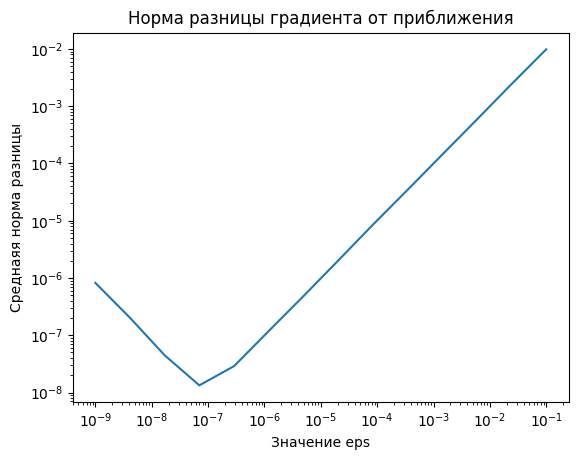

In [ ]:
plt.title('Норма разницы градиента от приближения')
res_np = np.array(res)
res_np = np.reshape(np.array(res), (14, 100))
stats = res_np.mean(axis=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Значение eps')
plt.ylabel('Среднаяя норма разницы')
plt.plot(np.logspace(-1, -9, 14), stats)
plt.savefig('./figures/norm_of_grad_diff_utils_test.eps', format='eps')

## Эксперимент №4

### Определим зависимость от alpha и beta

**Начнем исследование градиентного спуска с изучения поведения при разном learning_rate**

Посмотрим на то, как себя ведет градиентный алгоритм в зависимости от learning_rate. 
Для начала посмотрим на поведение при использовании именно inv_linear, а варьировать параметры мы будем alpha и beta. 
Для этого мы хотим посмотреть на такие статичтики, как:

*   loss
*   accuracy
*   precision по положительному классу
*   recall по положительному классу

При чем выбор такого обусловлен самой задачей, ведь нам хочется выявлять токсичные комментарии

Изначально нам зочется оценить содимость алгоримтов. Вряд ли нам будут интересны те алгоритмы, что не могут найти глобальный минимум, либо попадают в локалдьные ямы, не сходясь за разумное количество опреаций. Поэтому сначала оценим на различных alpha сходимость функции loss. Для этого зафиксируем несколько beta и для каждого проведем ряд экспериментов

Выбор beta будет состоять из набора 0, 0.3, 0.7, так как он хорошо приближает реальную действительность. Если мы не хотим никак уменьшать шаг, мы будем исполльзовать 0, если мы проваливаемся в локальные минимумы или не можем сойтись, однако не хотим испытывать проблемы с асцилированием модели, будем брать значения до единицы, например 0.7 выглядит сбалансированно, если нам надо очень быстро убрать шаг, будем использовать значения больше единицы, в нашем случае 2

In [ ]:
X_train = default_sparse
X_test = default_sparse_test
y_train = default_data.is_toxic.values * 2 - 1
y_test = default_data_test.is_toxic.values * 2 - 1

In [ ]:
alpha_stats = []
for beta in [0.0, 0.3, 0.7]:
    for alpha in np.sort(np.hstack([np.logspace(-3.5, 0.7, 32)])):
        model = GDClassifier(learning_rate=inv_scale_lr(alpha, beta), tolerance=None, max_iter=200)
        alpha_stats.append({'alpha': alpha, 'beta': beta, **model.fit(X_train, y_train, trace=True, X_test=X_test, y_test=y_test)})

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


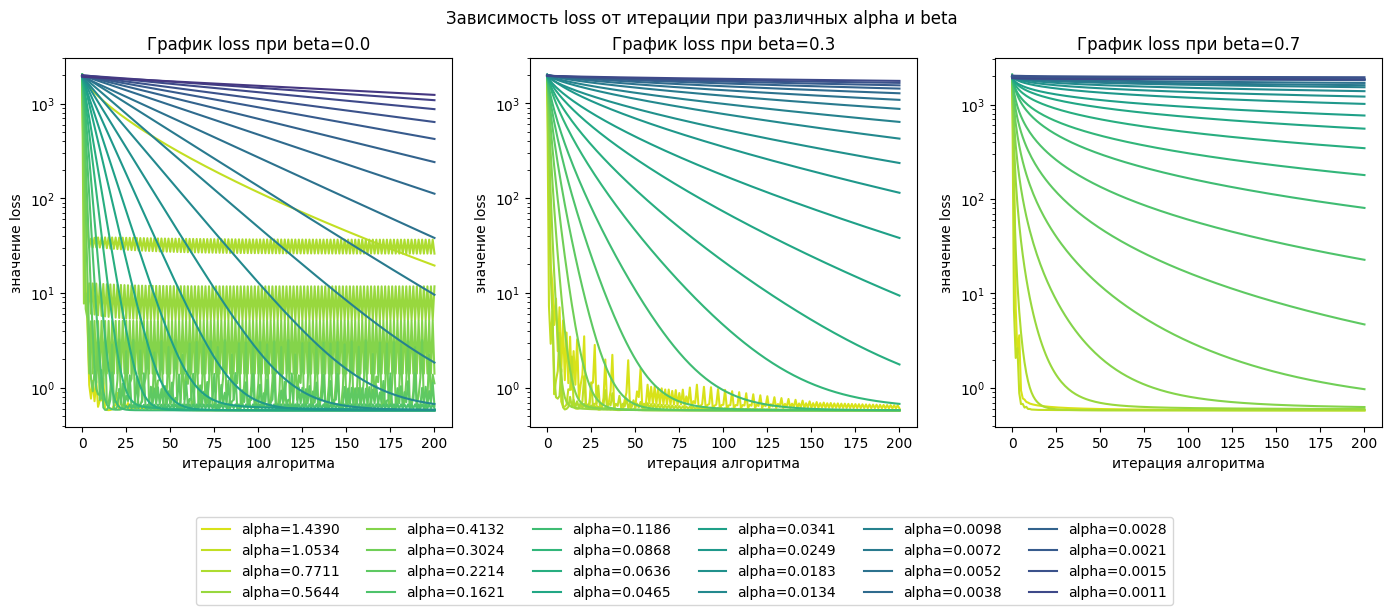

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

fig, axis = plt.subplots(1, 3)
fig.set_figwidth(17)
fig.suptitle('Зависимость loss от итерации при различных alpha и beta')

cmap = plt.get_cmap('viridis')
axis[0].set_prop_cycle(color=[cmap(1 - 1.*(i + 2)/32) for i in range(32)])
axis[0].set_title('График loss при beta=0.0')
axis[1].set_prop_cycle(color=[cmap(1 - 1.*(i + 2)/32) for i in range(32)])
axis[1].set_title('График loss при beta=0.3')
axis[2].set_prop_cycle(color=[cmap(1 - 1.*(i + 2)/32) for i in range(32)])
axis[2].set_title('График loss при beta=0.7')
for hist in alpha_stats[::-1]:
    axis[0].set_title('График loss при beta=0.0')
    if hist['alpha'] > 1.5 or hist['alpha'] < 0.0009:
        continue
    if hist['beta'] == 0.0:
        axis[0].plot(np.arange(201), hist['func'], label=f'alpha={hist["alpha"]:.4f}')
    elif hist['beta'] == 0.3:
        axis[1].plot(np.arange(201), hist['func'], label=f'alpha={hist["alpha"]:.4f}')
    elif hist['beta'] == 0.7:
        axis[2].plot(np.arange(201), hist['func'], label=f'alpha={hist["alpha"]:.4f}')

for ax in axis:
    ax.set_yscale('log')
    ax.set_xlabel('итерация алгоритма')
    ax.set_ylabel('значение loss')

plt.legend(loc='lower center', ncol=6, bbox_to_anchor=(-0.8, -0.5))
plt.savefig('./figures/gdc_loss_compare.eps', format='eps', bbox_inches='tight')

Как следует из начального предположения, от alpha зависит начальная скорость обучения (за исключением графика для beta=0), от beta же явным образом зависит скорость убывания.
Из графиков видно, что для всех beta присутствуют такие alpha, что модели с соответсвующим learning_rate не смогли сойтись за 200 итераций градиентного спуска. 
Такое наблюдение естественно и ожидаемо, при чем с ростом beta растет и количество таких alpha, соответственные модели которых не успевают сойтись.

Отдельно отметим особенность, что пропадает с ростом beta: алогритм, при относительно больших alpha и относительно малом beta имеет свойство асцилировать в районе оптимума 
(ярко видно на примере beta=0 и так же присутсвует на beta=0.3). Однако при таком поведении алгоритм быстрее всего выходит на плата, вокруг которого начинаются затухающие колебания (кроме как в случае с beta=0)

Теперь, переходя к оценке классифицирующей способности модели в зависимости от alpha, нам стоит учитывать указанную асциляцию модели, так как она явно не в лучшую сторону повлияет на метрики.
Потому исследуем сначала модель с beta=0.3, как переходную между остальными.

In [ ]:
alpha_stats_fix_beta = list(filter(lambda x: x['beta'] == 0.3, alpha_stats))

In [ ]:
alpha_stats = dill.load(open('./data_pickles/alpha_stats.db', 'rb'))

Стоит отделить часть наиболее больших alpha, так как асчиляция повлияла не только на график loss, но и на прочие метрики. Отобразим лишь те alpha, что меньше 1.0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


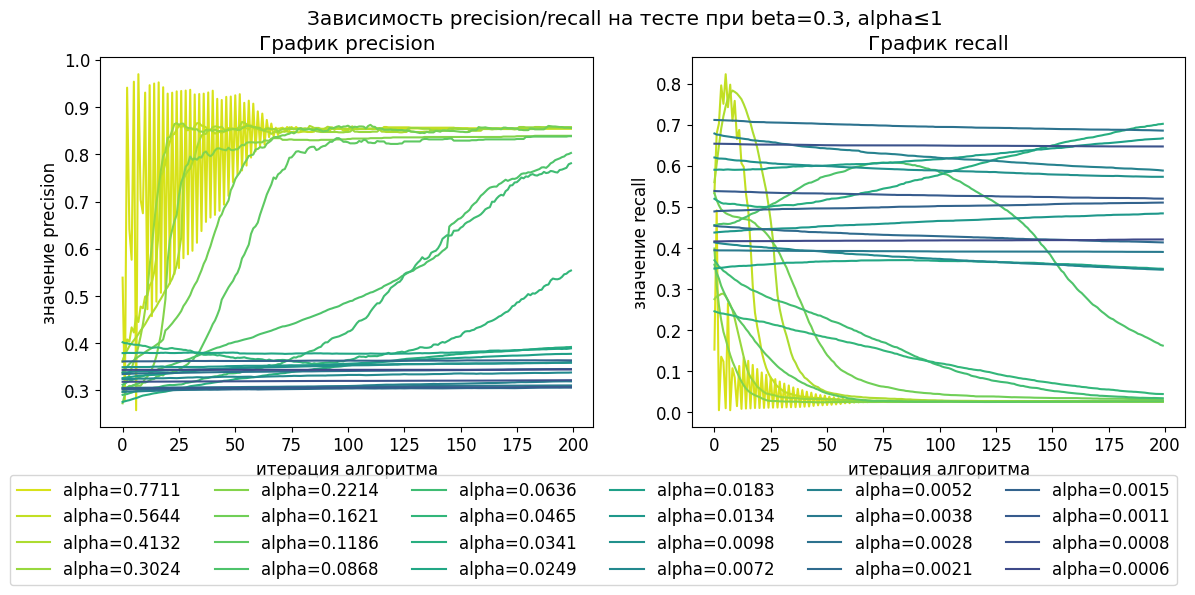

In [410]:
fig, axis = plt.subplots(1, 2)
fig.set_figwidth(14)
fig.suptitle('Зависимость precision/recall на тесте при beta=0.3, alpha≤1')

cmap = plt.get_cmap('viridis')
axis[0].set_prop_cycle(color=[cmap(1 - 1.*(i + 2)/32) for i in range(32)])
axis[0].set_title('График precision')
axis[1].set_prop_cycle(color=[cmap(1 - 1.*(i + 2)/32) for i in range(32)])
axis[1].set_title('График recall')

for hist in alpha_stats_fix_beta[::-1]:
    if hist['alpha'] > 1 or hist['alpha'] < 0.0005:
        continue
    axis[0].plot(np.arange(200), hist['precision'], label=f'alpha={hist["alpha"]:.4f}')
    axis[1].plot(np.arange(200), hist['recall'], label=f'alpha={hist["alpha"]:.4f}')

axis[0].set_ylabel('значение precision')
axis[1].set_ylabel('значение recall')
for ax in axis:
    ax.set_xlabel('итерация алгоритма')

plt.legend(loc='lower center', ncol=6, bbox_to_anchor=(-0.2, -0.45))
plt.savefig('./figures/gdc_precsion_recall_compare.eps', format='eps', bbox_inches='tight')

Как видно из графиков, модели с показателем alpha выше 0.1 смогли получить точность (precision) в районе 1, пока остальные модели оставались на одном уровне, примерно в 0.3-0.4. Однако стоит посмотреть на график recall, так как мы поймем, что данные модели получили крайне малый recall, тем самым оптимизировав задачу так, чтобы почти не определять положительный класс.  

Модели разделились по признаку величины покзателя alpha, где меньший коэффициент шага ведет к меньшей обучаемости модели, а потому к большему recall и меньшему precision. И наборот. Все указывает на то, что классы, учавствующие в классификации, не сбалансированные. Проверить косвенно это можно с помощью accuracy и F1_score.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


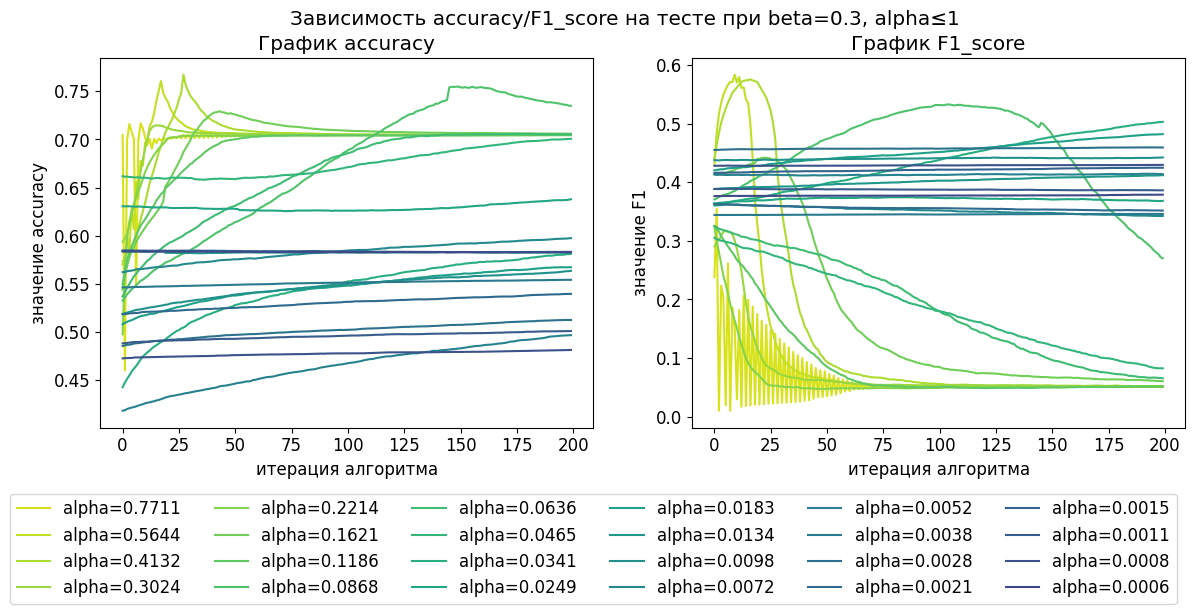

In [413]:
fig, axis = plt.subplots(1, 2)
fig.set_figwidth(14)
fig.suptitle('Зависимость accuracy/F1_score на тесте при beta=0.3, alpha≤1')

cmap = plt.get_cmap('viridis')
axis[0].set_prop_cycle(color=[cmap(1 - 1.*(i + 2)/32) for i in range(32)])
axis[0].set_title('График accuracy')
axis[1].set_prop_cycle(color=[cmap(1 - 1.*(i + 2)/32) for i in range(32)])
axis[1].set_title('График F1_score')

i = 1
for hist in alpha_stats_fix_beta[::-1]:
    if hist['alpha'] > 1 or hist['alpha'] < 0.0005:
        continue
    axis[0].plot(np.arange(200), hist['accuracy'], label=f'alpha={hist["alpha"]:.4f}')
    axis[1].plot(np.arange(200), 2 / (np.array(hist['recall']) ** -1 + np.array(hist['precision']) ** -1), label=f'alpha={hist["alpha"]:.4f}')

for ax in axis:
    ax.set_xlabel('итерация алгоритма')

axis[0].set_ylabel('значение accuracy')
axis[1].set_ylabel('значение F1')


plt.legend(loc='lower center', ncol=6, bbox_to_anchor=(-0.2, -0.5))
plt.savefig('./figures/gdc_accuracy_f1_compare.eps', format='eps', bbox_inches='tight')

Видно, что все модели, показывающие большие значения precision, стремятся к примерно одному значению accuracy, однако некоторые модели, в виду крайне малого learning_rate из-за малого показателя alpha, не могут выйти из ямы и остаются с качествтом на уровне 0.5. Ярко видна несбалансированность классов, так как такое хорошее значение точности алгоритма получается занулением какого-либо определния положительного класса, что видно по F1_score, который поволяет сгладить несбалансированность классов. На нем отчетливо выдно, что все модели с большим precision и accuracy, имеют самую малую данную метрику.

Посмотрим теперь на поведение модели с beta=0.7

In [ ]:
alpha_stats_fix_beta = list(filter(lambda x: x['beta'] == 0.7, alpha_stats))

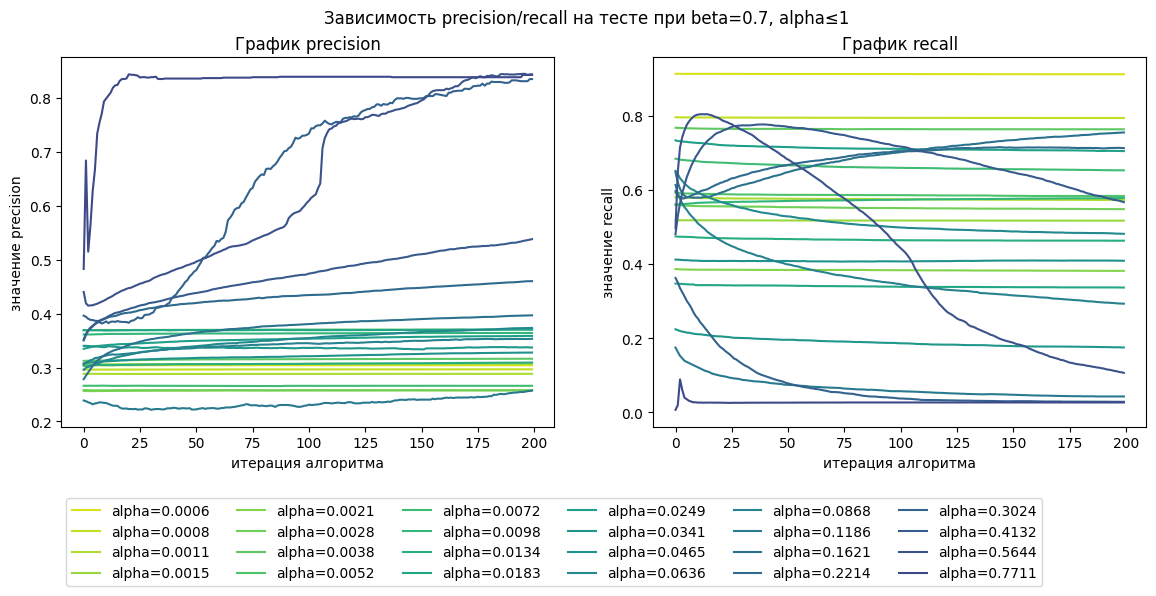

In [ ]:
fig, axis = plt.subplots(1, 2)
fig.set_figwidth(14)
fig.suptitle('Зависимость precision/recall на тесте при beta=0.7, alpha≤1')

cmap = plt.get_cmap('viridis')
axis[0].set_prop_cycle(color=[cmap(1 - 1.*(i + 2)/32) for i in range(32)])
axis[0].set_title('График precision')
axis[1].set_prop_cycle(color=[cmap(1 - 1.*(i + 2)/32) for i in range(32)])
axis[1].set_title('График recall')

for hist in alpha_stats_fix_beta:
    if hist['alpha'] > 1 or hist['alpha'] < 0.0005:
        continue
    axis[0].plot(np.arange(200), hist['precision'], label=f'alpha={hist["alpha"]:.4f}')
    axis[1].plot(np.arange(200), hist['recall'], label=f'alpha={hist["alpha"]:.4f}')

axis[0].set_ylabel('значение precision')
axis[1].set_ylabel('значение recall')
for ax in axis:
    ax.set_xlabel('итерация алгоритма')

plt.legend(loc='lower center', ncol=6, bbox_to_anchor=(-0.2, -0.45))

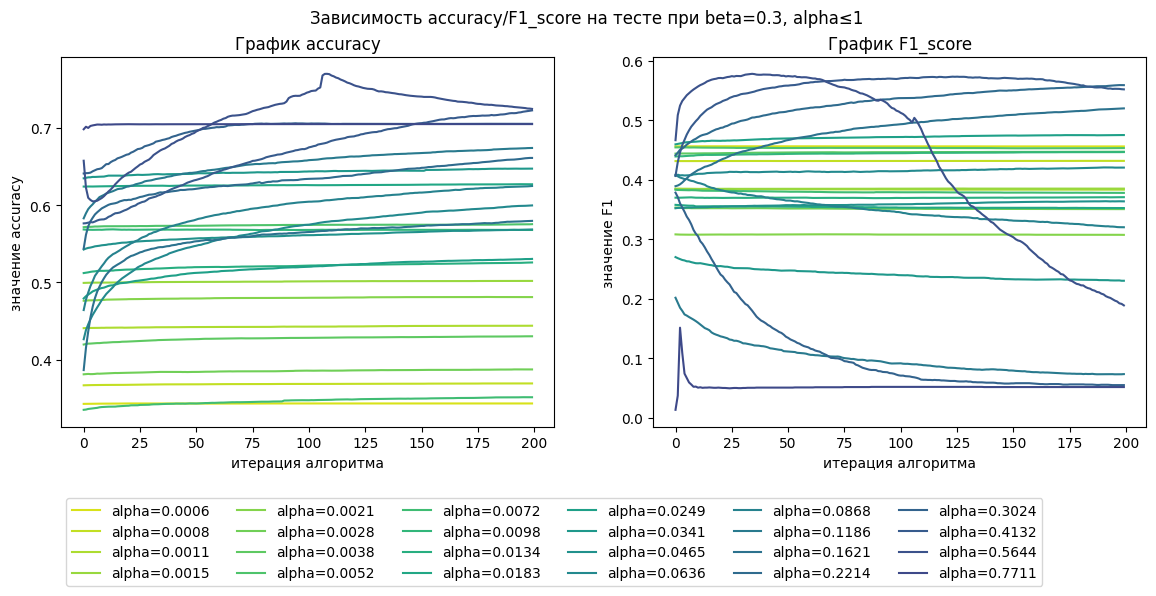

In [ ]:
fig, axis = plt.subplots(1, 2)
fig.set_figwidth(14)
fig.suptitle('Зависимость accuracy/F1_score на тесте при beta=0.3, alpha≤1')

cmap = plt.get_cmap('viridis')
axis[0].set_prop_cycle(color=[cmap(1 - 1.*(i + 2)/32) for i in range(32)])
axis[0].set_title('График accuracy')
axis[1].set_prop_cycle(color=[cmap(1 - 1.*(i + 2)/32) for i in range(32)])
axis[1].set_title('График F1_score')

i = 1
for hist in alpha_stats_fix_beta:
    if hist['alpha'] > 1 or hist['alpha'] < 0.0005:
        continue
    axis[0].plot(np.arange(200), hist['accuracy'], label=f'alpha={hist["alpha"]:.4f}')
    axis[1].plot(np.arange(200), 2 / (np.array(hist['recall']) ** -1 + np.array(hist['precision']) ** -1), label=f'alpha={hist["alpha"]:.4f}')

for ax in axis:
    ax.set_xlabel('итерация алгоритма')

axis[0].set_ylabel('значение accuracy')
axis[1].set_ylabel('значение F1')

plt.legend(loc='lower center', ncol=6, bbox_to_anchor=(-0.2, -0.45))

Здесь наблюдается такое же положение дел, с той лишь разницей, что увеличенный показатель beta не позволяет моделям так же стремительно переходить в состояние переобучения, из-за чего мы видим лучшие в среднем результаты на графике F1_score

**Определим зависимость от beta**

Учитывая неустойчивость модели относительно alpha, выберем alpha с чистого листа: зафиксируем alpha как 0.04, 0.8, 1.7. Данный выбор сделан специально и призван показать на практике работу 
коэффициента затухания шага градиентного спуска

In [ ]:
beta_stats = []
for alpha in [0.04, 0.8, 1.7]:
    for beta in np.sort(np.hstack([np.linspace(0, 3, 32)])):
        model = GDClassifier(learning_rate=inv_scale_lr(alpha, 0.3), tolerance=None, max_iter=200)
        beta_stats.append({'alpha': alpha, 'beta': beta, **model.fit(X_train, y_train, trace=True, X_test=X_test, y_test=y_test)})

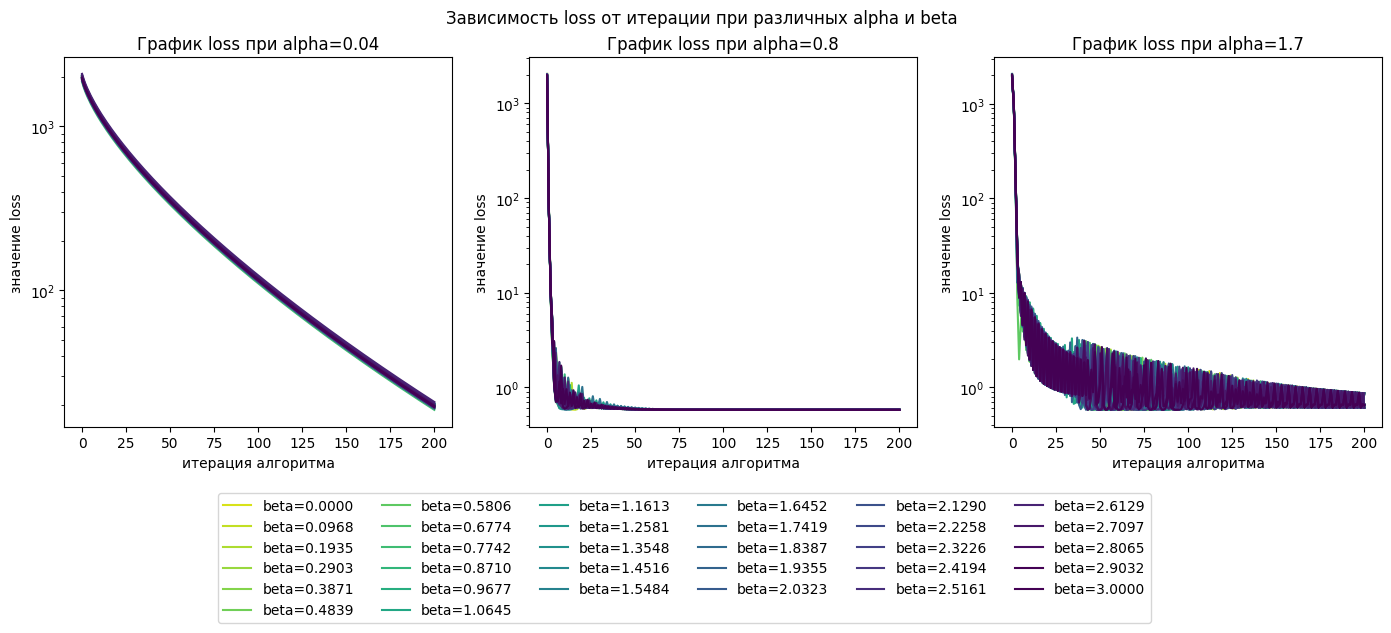

In [ ]:
fig, axis = plt.subplots(1, 3)
fig.set_figwidth(17)
fig.suptitle('Зависимость loss от итерации при различных alpha и beta')

cmap = plt.get_cmap('viridis')
axis[0].set_prop_cycle(color=[cmap(1 - 1.*(i + 2)/32) for i in range(32)])
axis[0].set_title('График loss при alpha=0.04')
axis[1].set_prop_cycle(color=[cmap(1 - 1.*(i + 2)/32) for i in range(32)])
axis[1].set_title('График loss при alpha=0.8')
axis[2].set_prop_cycle(color=[cmap(1 - 1.*(i + 2)/32) for i in range(32)])
axis[2].set_title('График loss при alpha=1.7')

for hist in beta_stats:
    if hist['alpha'] == 0.04:
        axis[0].plot(np.arange(201), hist['func'], label=f'beta={hist["beta"]:.4f}')
    elif hist['alpha'] == 0.8:
        axis[1].plot(np.arange(201), hist['func'], label=f'beta={hist["beta"]:.4f}')
    else:
        axis[2].plot(np.arange(201), hist['func'], label=f'beta={hist["beta"]:.4f}')

for ax in axis:
    ax.set_yscale('log')
    ax.set_xlabel('итерация алгоритма')
    ax.set_ylabel('значение loss')

plt.legend(loc='lower center', ncol=6, bbox_to_anchor=(-0.8, -0.55))

### Зависимость обучения модели от начальных приближений

Посмотрим теперь, как начальное приближение влияет на изменение функции эмпирического риска в зависимости от итерации. Посмотрим на основные виды приближений:



*   Случайное приближение из Гауссовского распределения
*   Случайное приближение из Равномерного распределения
*   Случайное приближение из распределения Лапласа
*   Случайное приближение из распределения Гампбела
*   Приближение нулем
*   $w_i = \frac{(f_i, y)}{(f_i, f_i)}$, где $f_i$ - соответсвующий столбец признака у объектов


Важным аспектом жксперимента является доля случайности процесса обучения. Потому для правильно сделанных выводов необзодимо смотреть усреднение показателей на каждом шаге по всем запускам обучения модели с одинаковыми начальными распределениями.


In [1198]:
model = GDClassifier(learning_rate=inv_scale_lr(0.5, 0.5), tolerance=None, max_iter=200, warm_start=False)


def get_smart_first_weights(X, y):
    return (y @ X) / np.sum(X * X, axis=0)


STATISTIC_COUNT = 5

history = {
    'history_gauss': [],
    'history_uniform': [],
    'history_laplas': [],
    'history_gumbel': [],
    'history_zeros': [],
    'history_smart': []
}

for _ in range(STATISTIC_COUNT):
    history['history_gauss'].append(
        model.fit(default_sparse, default_data.is_toxic.values * 2 - 1, w_0=np.random.normal(size=default_sparse.shape[1]),
                  X_test=default_sparse_test, y_test=default_data_test.is_toxic.values * 2 - 1, trace=True)
    )
    history['history_uniform'].append(
        model.fit(default_sparse, default_data.is_toxic.values * 2 - 1, w_0=np.random.uniform(low=-1, high=1, size=default_sparse.shape[1]),
                  X_test=default_sparse_test, y_test=default_data_test.is_toxic.values * 2 - 1, trace=True)
    )
    history['history_laplas'].append(
        model.fit(default_sparse, default_data.is_toxic.values * 2 - 1, w_0=np.random.laplace(size=default_sparse.shape[1]),
                  X_test=default_sparse_test, y_test=default_data_test.is_toxic.values * 2 - 1, trace=True)
    )
    history['history_gumbel'].append(
        model.fit(default_sparse, default_data.is_toxic.values * 2 - 1, w_0=np.random.gumbel(size=default_sparse.shape[1]),
                  X_test=default_sparse_test, y_test=default_data_test.is_toxic.values * 2 - 1, trace=True)
    )
    history['history_zeros'].append(
        model.fit(default_sparse, default_data.is_toxic.values * 2 - 1, w_0=np.zeros(default_sparse.shape[1]).astype(np.float64),
                  X_test=default_sparse_test, y_test=default_data_test.is_toxic.values * 2 - 1, trace=True)
    )
    history['history_smart'].append(
        model.fit(default_sparse, default_data.is_toxic.values * 2 - 1, w_0=get_smart_first_weights(default_sparse.toarray(), default_data.is_toxic.values * 2 - 1),
                  X_test=default_sparse_test, y_test=default_data_test.is_toxic.values * 2 - 1, trace=True)
    )

dill.dump(history, open('./data_pickles/init_weights_test_history_GDC.db', 'wb'))

In [1195]:
history = dill.load(open('./data_pickles/init_weights_test_history_GDC.db', 'rb'))

In [1199]:
history_to_np = {}
for key, lists in history.items():
    ls_precision = np.array([l['precision'] for l in lists])
    ls_recall = np.array([l['recall'] for l in lists])
    ls_accuracy = np.array([l['accuracy'] for l in lists])
    ls_F1_score = 2 / (ls_recall ** -1 + ls_precision ** -1)
    ls_func = np.array([l['func'] for l in lists])
    history_to_np[key] = {
        'precision_mean': np.mean(ls_precision, axis=0),
        'precision_std': np.std(ls_precision, axis=0),
        'recall_mean': np.mean(ls_recall, axis=0),
        'recall_std': np.std(ls_recall, axis=0),
        'accuracy_mean': np.mean(ls_accuracy, axis=0),
        'accuracy_std': np.std(ls_accuracy, axis=0),
        'F1_score_mean': np.mean(ls_F1_score, axis=0),
        'F1_score_std': np.std(ls_F1_score, axis=0),
        'func_mean': np.mean(ls_func, axis=0),
        'func_std': np.std(ls_func, axis=0),
    }

/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_17319/1389694041.py:6: RuntimeWarning: divide by zero encountered in reciprocal
  ls_F1_score = 2 / (ls_recall ** -1 + ls_precision ** -1)


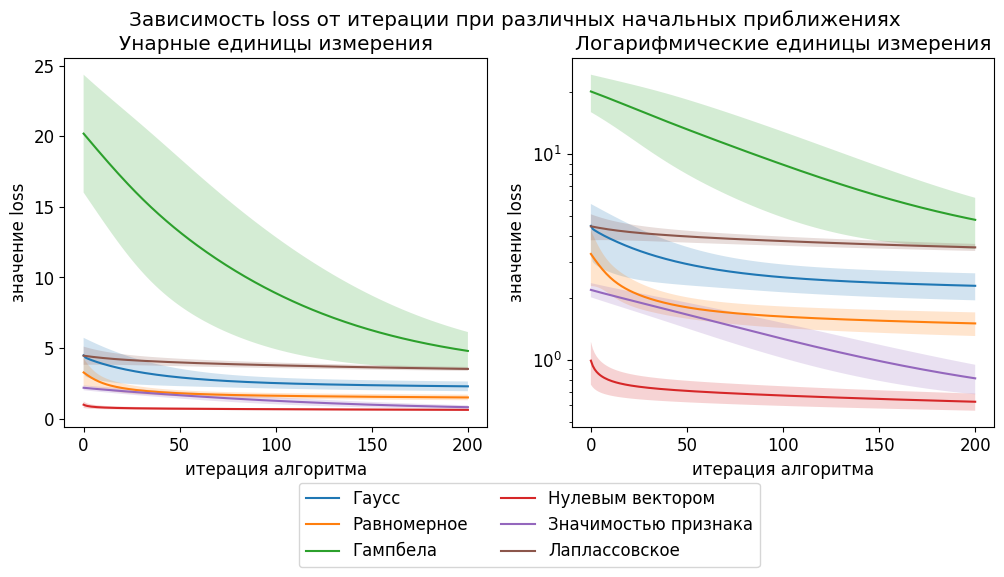

In [1200]:
fig, axis = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.suptitle('Зависимость loss от итерации при различных начальных приближениях')

axis[0].set_title('Унарные единицы измерения')
axis[0].plot(np.arange(201), history_to_np['history_gauss']['func_mean'], label='Гаусс')
axis[0].plot(np.arange(201), history_to_np['history_uniform']['func_mean'], label='Равномерное')
axis[0].plot(np.arange(201), history_to_np['history_gumbel']['func_mean'], label='Гампбела')
axis[0].plot(np.arange(201), history_to_np['history_zeros']['func_mean'], label='Нулевым вектором')
axis[0].plot(np.arange(201), history_to_np['history_smart']['func_mean'], label='Значимостью признака')
axis[0].plot(np.arange(201), history_to_np['history_laplas']['func_mean'], label='Лаплассовское')

axis[0].fill_between(np.arange(201), history_to_np['history_gauss']['func_mean'] + history_to_np['history_gauss']['func_std'],
                     history_to_np['history_gauss']['func_mean'] - history_to_np['history_gauss']['func_std'], alpha=0.2)
axis[0].fill_between(np.arange(201), history_to_np['history_uniform']['func_mean'] + history_to_np['history_uniform']['func_std'],
                     history_to_np['history_uniform']['func_mean'] - history_to_np['history_uniform']['func_std'], alpha=0.2)
axis[0].fill_between(np.arange(201), history_to_np['history_gumbel']['func_mean'] + history_to_np['history_gumbel']['func_std'],
                     history_to_np['history_gumbel']['func_mean'] - history_to_np['history_gumbel']['func_std'], alpha=0.2)
axis[0].fill_between(np.arange(201), history_to_np['history_zeros']['func_mean'] + history_to_np['history_zeros']['func_std'],
                     history_to_np['history_zeros']['func_mean'] - history_to_np['history_zeros']['func_std'], alpha=0.2)
axis[0].fill_between(np.arange(201), history_to_np['history_smart']['func_mean'] + history_to_np['history_smart']['func_std'],
                     history_to_np['history_smart']['func_mean'] - history_to_np['history_smart']['func_std'], alpha=0.2)
axis[0].fill_between(np.arange(201), history_to_np['history_laplas']['func_mean'] + history_to_np['history_laplas']['func_std'],
                     history_to_np['history_laplas']['func_mean'] - history_to_np['history_laplas']['func_std'], alpha=0.2)

axis[1].set_title('Логарифмические единицы измерения')
axis[1].plot(np.arange(201), history_to_np['history_gauss']['func_mean'], label='Гаусс')
axis[1].plot(np.arange(201), history_to_np['history_uniform']['func_mean'], label='Равномерное')
axis[1].plot(np.arange(201), history_to_np['history_gumbel']['func_mean'], label='Гампбела')
axis[1].plot(np.arange(201), history_to_np['history_zeros']['func_mean'], label='Нулевым вектором')
axis[1].plot(np.arange(201), history_to_np['history_smart']['func_mean'], label='Значимостью признака')
axis[1].plot(np.arange(201), history_to_np['history_laplas']['func_mean'], label='Лаплассовское')

axis[1].fill_between(np.arange(201), history_to_np['history_gauss']['func_mean'] + history_to_np['history_gauss']['func_std'],
                     history_to_np['history_gauss']['func_mean'] - history_to_np['history_gauss']['func_std'], alpha=0.2)
axis[1].fill_between(np.arange(201), history_to_np['history_uniform']['func_mean'] + history_to_np['history_uniform']['func_std'],
                     history_to_np['history_uniform']['func_mean'] - history_to_np['history_uniform']['func_std'], alpha=0.2)
axis[1].fill_between(np.arange(201), history_to_np['history_gumbel']['func_mean'] + history_to_np['history_gumbel']['func_std'],
                     history_to_np['history_gumbel']['func_mean'] - history_to_np['history_gumbel']['func_std'], alpha=0.2)
axis[1].fill_between(np.arange(201), history_to_np['history_zeros']['func_mean'] + history_to_np['history_zeros']['func_std'],
                     history_to_np['history_zeros']['func_mean'] - history_to_np['history_zeros']['func_std'], alpha=0.2)
axis[1].fill_between(np.arange(201), history_to_np['history_smart']['func_mean'] + history_to_np['history_smart']['func_std'],
                     history_to_np['history_smart']['func_mean'] - history_to_np['history_smart']['func_std'], alpha=0.2)
axis[1].fill_between(np.arange(201), history_to_np['history_laplas']['func_mean'] + history_to_np['history_laplas']['func_std'],
                     history_to_np['history_laplas']['func_mean'] - history_to_np['history_laplas']['func_std'], alpha=0.2)

for ax in axis:
    ax.set_xlabel('итерация алгоритма')
    ax.set_ylabel('значение loss')

axis[1].set_yscale('log')
plt.legend(loc='lower center', ncol=2, bbox_to_anchor=(-0.1, -0.4))
plt.savefig('./figures/gdc_init_weights_loss.pdf', format='pdf', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


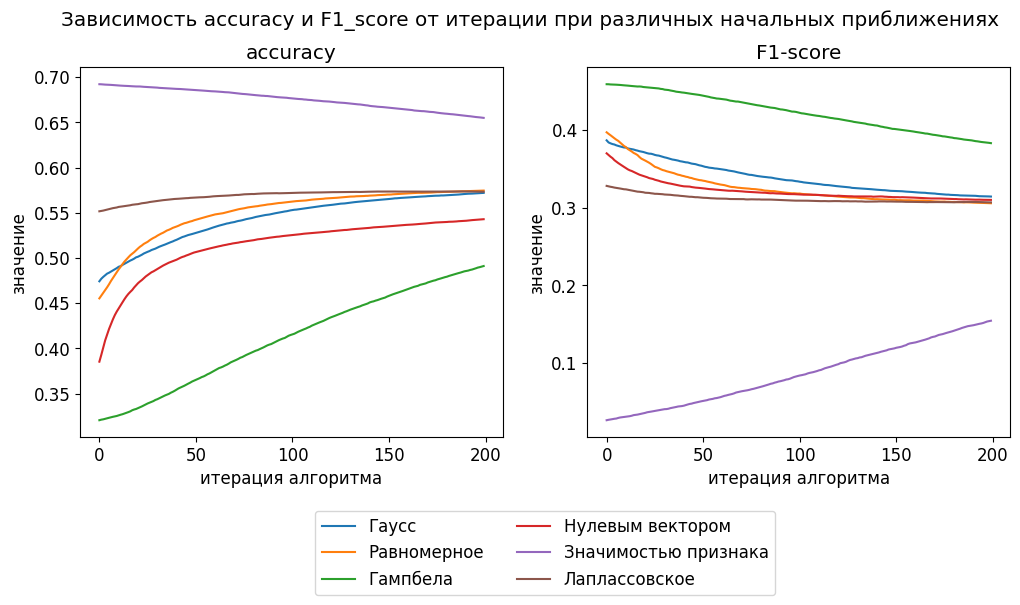

In [1201]:
fig, axis = plt.subplots(1, 2)
fig.set_figwidth(12)
# fig.set_figheight(10)
title = fig.suptitle('Зависимость accuracy и F1_score от итерации при различных начальных приближениях')

axis[0].set_title('accuracy')
axis[0].plot(np.arange(200), history_to_np['history_gauss']['accuracy_mean'], label='Гаусс')
axis[0].plot(np.arange(200), history_to_np['history_uniform']['accuracy_mean'], label='Равномерное')
axis[0].plot(np.arange(200), history_to_np['history_gumbel']['accuracy_mean'], label='Гампбела')
axis[0].plot(np.arange(200), history_to_np['history_zeros']['accuracy_mean'], label='Нулевым вектором')
axis[0].plot(np.arange(200), history_to_np['history_smart']['accuracy_mean'], label='Значимостью признака')
axis[0].plot(np.arange(200), history_to_np['history_laplas']['accuracy_mean'], label='Лаплассовское')

# axis[1][0].set_title('Зависимость дисперсии accuracy')
# axis[1][0].plot(np.arange(200), history_to_np['history_gauss']['accuracy_std'])
# axis[1][0].plot(np.arange(200), history_to_np['history_uniform']['accuracy_std'])
# axis[1][0].plot(np.arange(200), history_to_np['history_gumbel']['accuracy_std'])
# axis[1][0].plot(np.arange(200), history_to_np['history_zeros']['accuracy_std'])
# axis[1][0].plot(np.arange(200), history_to_np['history_smart']['accuracy_std'])
# axis[1][0].plot(np.arange(200), history_to_np['history_laplas']['accuracy_std'])

axis[1].set_title('F1-score')
axis[1].plot(np.arange(200), history_to_np['history_gauss']['F1_score_mean'], label='Гаусс')
axis[1].plot(np.arange(200), history_to_np['history_uniform']['F1_score_mean'], label='Равномерное')
axis[1].plot(np.arange(200), history_to_np['history_gumbel']['F1_score_mean'], label='Гампбела')
axis[1].plot(np.arange(200), history_to_np['history_zeros']['F1_score_mean'], label='Нулевым вектором')
axis[1].plot(np.arange(200), history_to_np['history_smart']['F1_score_mean'], label='Значимостью признака')
axis[1].plot(np.arange(200), history_to_np['history_laplas']['F1_score_mean'], label='Лаплассовское')

# axis[1][1].set_title('Зависимость дисперсии F1_score')
# axis[1][1].plot(np.arange(200), history_to_np['history_gauss']['F1_score_std'])
# axis[1][1].plot(np.arange(200), history_to_np['history_uniform']['F1_score_std'])
# axis[1][1].plot(np.arange(200), history_to_np['history_gumbel']['F1_score_std'])
# axis[1][1].plot(np.arange(200), history_to_np['history_zeros']['F1_score_std'])
# axis[1][1].plot(np.arange(200), history_to_np['history_smart']['F1_score_std'])
# axis[1][1].plot(np.arange(200), history_to_np['history_laplas']['F1_score_std'])

for ax in axis:
    ax.set_xlabel('итерация алгоритма')
    ax.set_ylabel('значение')
    # ax[1].set_xlabel('итерация алгоритма')

# axis[0][0].set_ylabel('значение accuracy')
# axis[1][0].set_ylabel('значение accuracy')
# axis[0][1].set_ylabel('значение F1')
# axis[1][1].set_ylabel('значение F1')


axis[0].legend(loc='lower center', ncol=2, bbox_to_anchor=(1.1, -0.45))
title.set_position([.5, 1])
plt.savefig('./figures/gdc_accuracy_f1_for_init_weights.eps', format='eps', bbox_inches='tight')

In [ ]:
# from matplotlib.collections import LineCollection
# import matplotlib

# fig, axis = plt.subplots(1, 2, sharex=True, sharey=True)
# fig.set_figwidth(12)
# fig.suptitle('Графики зависимости accuracy и F1_score от итерации')


# d_all = np.vstack([history_to_np['history_gauss']['accuracy_std'],
#                history_to_np['history_uniform']['accuracy_std'],
#                history_to_np['history_gumbel']['accuracy_std'],
#                history_to_np['history_zeros']['accuracy_std'],
#                history_to_np['history_smart']['accuracy_std'],
#                history_to_np['history_laplas']['accuracy_std'],])

# n = np.vstack([np.arange(201), history_to_np['history_gauss']['func_mean']]).T.reshape(-1, 1, 2)

# norm = plt.Normalize(d_all.min(), d_all.max())
# cm = matplotlib.colormaps['viridis']
# smap = matplotlib.cm.ScalarMappable(norm=norm, cmap=cm)

# for n, d in [(history_to_np['history_gauss']['accuracy_mean'],   history_to_np['history_gauss']['accuracy_std']),
#              (history_to_np['history_uniform']['accuracy_mean'], history_to_np['history_uniform']['accuracy_std']),
#              (history_to_np['history_gumbel']['accuracy_mean'],  history_to_np['history_gumbel']['accuracy_std']),
#              (history_to_np['history_zeros']['accuracy_mean'],   history_to_np['history_zeros']['accuracy_std']),
#              (history_to_np['history_smart']['accuracy_mean'],   history_to_np['history_smart']['accuracy_std']),
#              (history_to_np['history_laplas']['accuracy_mean'],  history_to_np['history_laplas']['accuracy_std'])]:

#     segments = np.concatenate([n[:-1], n[1:]], axis=1)
#     lc = LineCollection(segments, colors=smap.to_rgba(d), norm=norm)
#     lc.set_array(np.arange(201))
#     lc.set_linewidth(2)
#     line = axis[0].add_collection(lc)
#     fig.colorbar(line, ax=axis[0])

#     axis[0].autoscale()
#     plt.show()

### Дополнительное исследование прочих kearning_rate

То же самое сделаем для других способов определения learning rate

*   exponential_lr - будем фиксировать η=1.0 и γ=0.8
*   linear_lr - будем фиксировать a=1.0 и b=${10}^{-5}$
*   cosine_lr - будем фиксировать a=1.0 и b=${10}^{-5}$



Для экспоненциального

In [ ]:
linsp_eta = np.linspace(0.1, 5, 5)
linsp_gamma = np.linspace(0.001, 1, 5)

In [ ]:
exp_eta_gdc = []
# exp_gamma_gdc = []

for eta in linsp_eta:
    model = GDClassifier(learning_rate=exponential_lr(eta, 0.8), tolerance=None, max_iter=200)
    exp_eta_gdc.append({'eta': eta, **model.fit(default_sparse, default_data.is_toxic.values * 2 - 1, trace=True)})
# for gamma in linsp_gamma:
#   model = GDClassifier(learning_rate=exponential_lr(1, gamma), tolerance=None, max_iter=200)
#   exp_gamma_gdc.append({'gamma': gamma, **model.fit(default_sparse, default_data.is_toxic.values * 2 - 1, trace=True)})

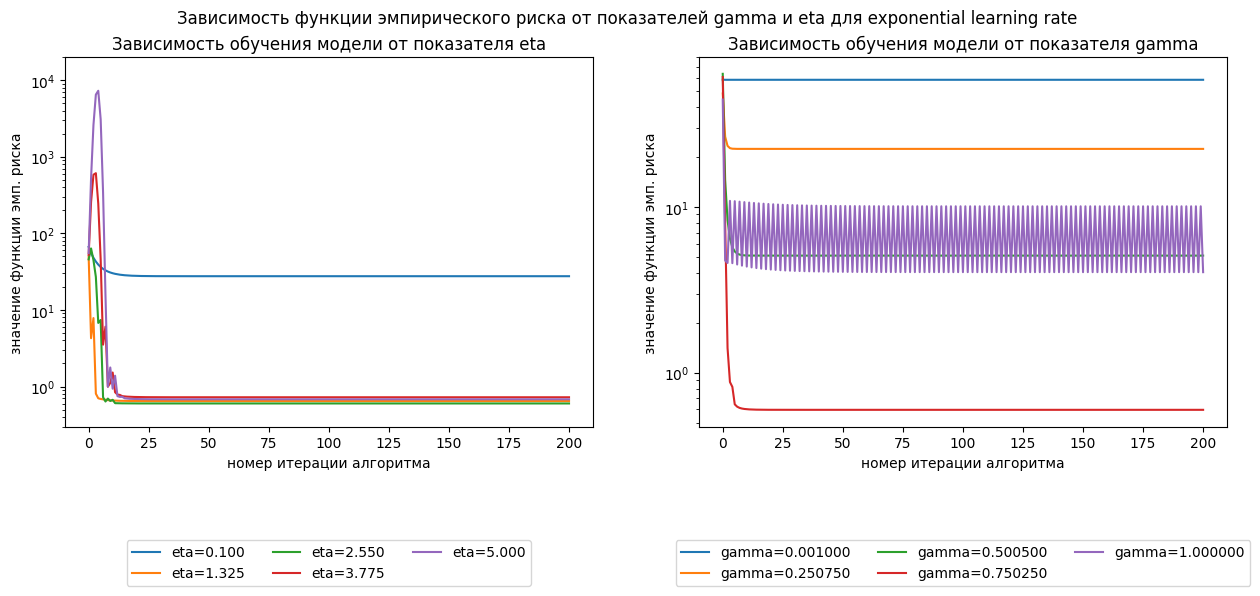

In [ ]:
fig, axis = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.suptitle('Зависимость функции эмпирического риска от показателей gamma и eta для exponential learning rate')

for hist in exp_eta_gdc:
    axis[0].plot(np.arange(201), hist['func'], label=f'eta={hist["eta"]:.3f}')
axis[0].set_ylabel('значение функции эмп. риска')
axis[0].set_xlabel('номер итерации алгоритма')
axis[0].set_title('Зависимость обучения модели от показателя eta')
axis[0].set_yscale('log')
axis[0].legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.45))
axis[0].set_ylim(0.3, 10 ** 4 + 10000)

for hist in exp_gamma_gdc:
    axis[1].plot(np.arange(201), hist['func'], label=f'gamma={hist["gamma"]:3f}')
axis[1].set_ylabel('значение функции эмп. риска')
axis[1].set_xlabel('номер итерации алгоритма')
axis[1].set_title('Зависимость обучения модели от показателя gamma')
axis[1].set_yscale('log')
axis[1].legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.45))

Для линейного

In [ ]:
lnsp_a = np.linspace(5, 0.1, 5)
logsp_b = np.logspace(-1.01, -7, 5)

In [ ]:
lin_a_gdc = []
lin_b_gdc = []

for a in lnsp_a:
    print(1e-5, a)
    model = GDClassifier(learning_rate=linear_lr(1e-5, a, 200), tolerance=None, max_iter=200)
    lin_a_gdc.append({'a': a, **model.fit(default_sparse, default_data.is_toxic.values * 2 - 1, trace=True)})
for b in logsp_b:
    model = GDClassifier(learning_rate=linear_lr(b, 1, 200), tolerance=None, max_iter=200)
    lin_b_gdc.append({'b': b, **model.fit(default_sparse, default_data.is_toxic.values * 2 - 1, trace=True)})

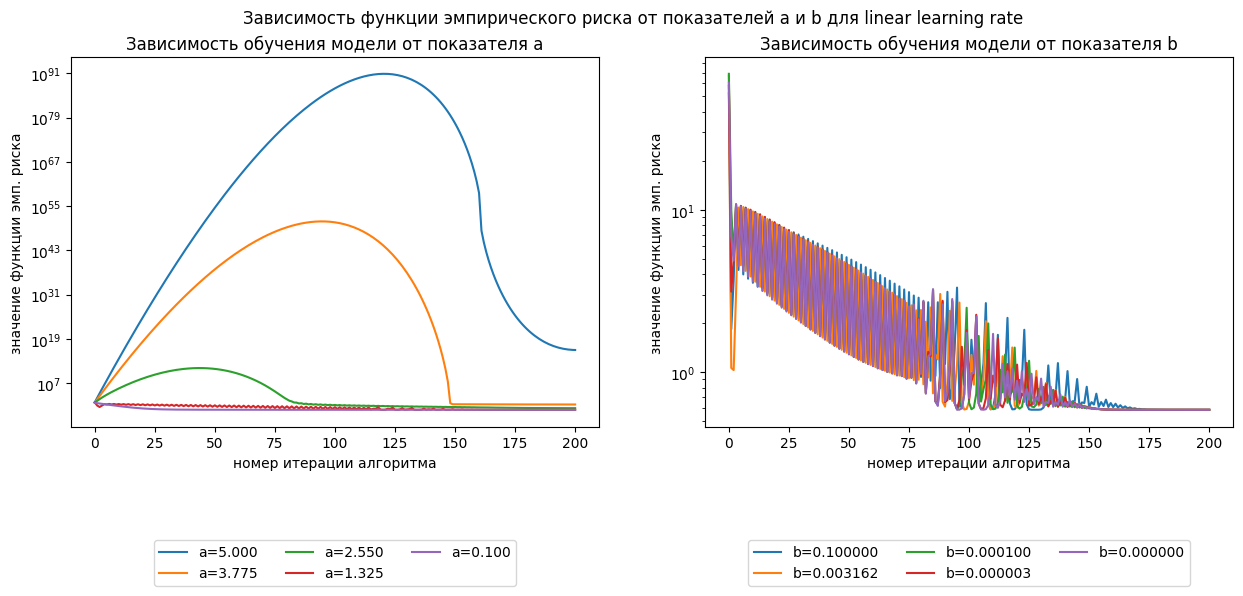

In [ ]:
fig, axis = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.suptitle('Зависимость функции эмпирического риска от показателей a и b для linear learning rate')

for hist in lin_a_gdc:
    axis[0].plot(np.arange(201), hist['func'], label=f'a={hist["a"]:.3f}')
axis[0].set_ylabel('значение функции эмп. риска')
axis[0].set_xlabel('номер итерации алгоритма')
axis[0].set_title('Зависимость обучения модели от показателя a')
axis[0].set_yscale('log')
axis[0].legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.45))


for hist in lin_b_gdc:
    axis[1].plot(np.arange(201), hist['func'], label=f'b={hist["b"]:3f}')
axis[1].set_ylabel('значение функции эмп. риска')
axis[1].set_xlabel('номер итерации алгоритма')
axis[1].set_title('Зависимость обучения модели от показателя b')
axis[1].set_yscale('log')
axis[1].legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.45))

Для косинусного

In [ ]:
cos_a_gdc = []
cos_b_gdc = []

for a in lnsp_a:
    model = GDClassifier(learning_rate=cosine_lr(1e-5, a, 200), tolerance=None, max_iter=200)
    cos_a_gdc.append({'a': a, **model.fit(default_sparse, default_data.is_toxic.values * 2 - 1, trace=True)})
for b in logsp_b:
    model = GDClassifier(learning_rate=cosine_lr(b, 1, 200), tolerance=None, max_iter=200)
    cos_b_gdc.append({'b': b, **model.fit(default_sparse, default_data.is_toxic.values * 2 - 1, trace=True)})

In [ ]:
del

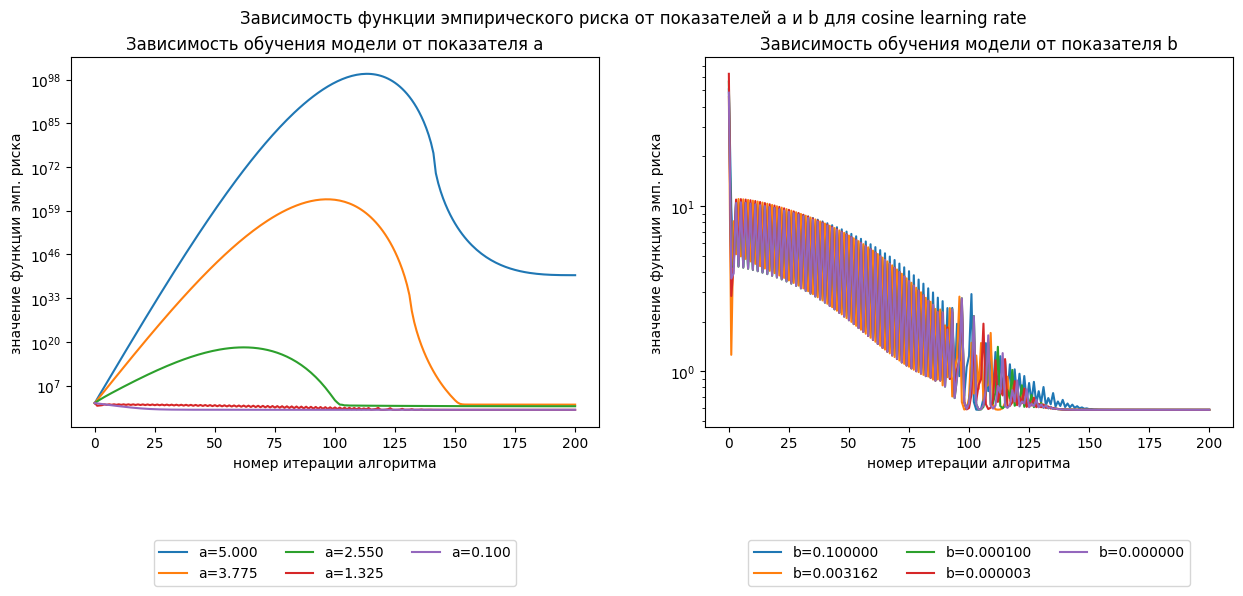

In [ ]:
fig, axis = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.suptitle('Зависимость функции эмпирического риска от показателей a и b для cosine learning rate')

for hist in cos_a_gdc:
    axis[0].plot(np.arange(201), hist['func'], label=f'a={hist["a"]:.3f}')
axis[0].set_ylabel('значение функции эмп. риска')
axis[0].set_xlabel('номер итерации алгоритма')
axis[0].set_title('Зависимость обучения модели от показателя a')
axis[0].set_yscale('log')
axis[0].legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.45))


for hist in cos_b_gdc:
    axis[1].plot(np.arange(201), hist['func'], label=f'b={hist["b"]:3f}')
axis[1].set_ylabel('значение функции эмп. риска')
axis[1].set_xlabel('номер итерации алгоритма')
axis[1].set_title('Зависимость обучения модели от показателя b')
axis[1].set_yscale('log')
axis[1].legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.45))

## Эксперимент №5

Пятый эксперимент по своей сути представляет повторение предыдущих рассуждений, с той лишь только разницей, что стохастические процессы нельзя рассматривать, имея единичные наблюдения ха каждой его составляющей. Пойдем так же, как и ранее, и посмотрим на различие работы модели со стохастическим градиентом при разных значения learning_rate от коэффициентов akpha и beta

За основу возьмем тот же датасет

In [1203]:
X_train = default_sparse
X_test = default_sparse_test
y_train = default_data.is_toxic.values * 2 - 1
y_test = default_data_test.is_toxic.values * 2 - 1

### Посмотрим на зависимость работы алгоритма от alpha и beta

Для сравнения с обычным градиентным спуском, будем проверять работу sgd при тех же параметрах alpha и beta. Выберем начальное значение batch_size. Пусть это будет 20% от всей выборки. Будем выводить для каждой эпохи по значения два раза, чтобы лучше понимать, как ведут себя метрики модели при послежовательно прохождении выборки раз за разом.

In [ ]:
alpha_stats_sgd = []
for beta in [0.0, 0.3, 0.7]:
    for alpha in np.sort(np.hstack([np.logspace(-3.5, 0.7, 32)])):
        model = SGDClassifier(learning_rate=inv_scale_lr(alpha, beta), tolerance=None, max_iter=50, warm_start=False, batch_size=0.2)
        alpha_stats_sgd.append({'alpha': alpha, 'beta': beta, **model.fit(X_train, y_train, trace=True, log_freq=0.49, X_test=X_test, y_test=y_test)})

Посмотрим на скорость сходимости моделей

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


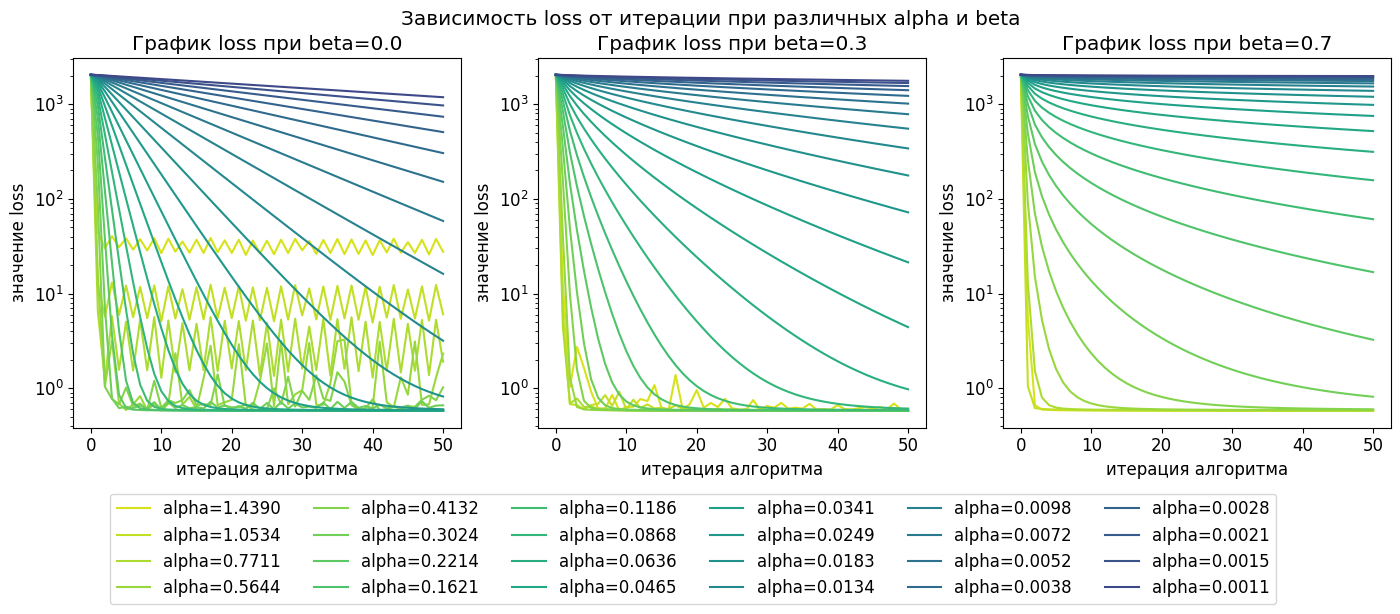

In [1136]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

fig, axis = plt.subplots(1, 3)
fig.set_figwidth(17)
fig.suptitle('Зависимость loss от итерации при различных alpha и beta')

cmap = plt.get_cmap('viridis')
axis[0].set_prop_cycle(color=[cmap(1 - 1.*(i + 2)/32) for i in range(32)])
axis[0].set_title('График loss при beta=0.0')
axis[1].set_prop_cycle(color=[cmap(1 - 1.*(i + 2)/32) for i in range(32)])
axis[1].set_title('График loss при beta=0.3')
axis[2].set_prop_cycle(color=[cmap(1 - 1.*(i + 2)/32) for i in range(32)])
axis[2].set_title('График loss при beta=0.7')
for hist in alpha_stats_sgd[::-1]:
    if hist['alpha'] > 1.5 or hist['alpha'] < 0.0009:
        continue
    if hist['beta'] == 0.0:
        axis[0].plot(np.arange(len(hist['func'])), hist['func'], label=f'alpha={hist["alpha"]:.4f}')
    elif hist['beta'] == 0.3:
        axis[1].plot(np.arange(len(hist['func'])), hist['func'], label=f'alpha={hist["alpha"]:.4f}')
    elif hist['beta'] == 0.7:
        axis[2].plot(np.arange(len(hist['func'])), hist['func'], label=f'alpha={hist["alpha"]:.4f}')

for ax in axis:
    ax.set_yscale('log')
    ax.set_xlabel('итерация алгоритма')
    ax.set_ylabel('значение loss')

plt.legend(loc='lower center', ncol=6, bbox_to_anchor=(-0.8, -0.5))
plt.savefig('./figures/sgdc_loss_for_alphas.eps', format='eps', bbox_inches='tight')

На графиках мы видим примерно такую же картину, как для классического градиентного спуска. Однако можно наблюдать более ярковыраженные колебания в области оптимумов моделей, а так же менее гладкие кривые обучения. Посмотрим на графики качества алгоритма, чтобы оценить решение

In [1133]:
alpha_stats_fix_beta_sgd = list(filter(lambda x: x['beta'] == 0.3, alpha_stats_sgd))

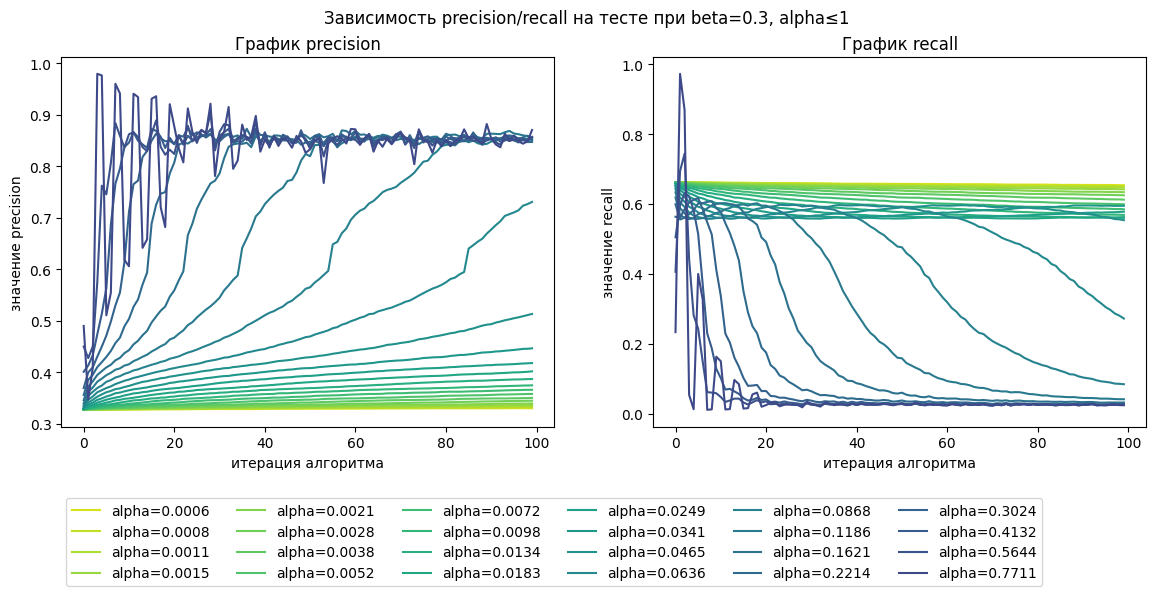

In [ ]:
fig, axis = plt.subplots(1, 2)
fig.set_figwidth(14)
fig.suptitle('Зависимость precision/recall на тесте при beta=0.3, alpha≤1')

cmap = plt.get_cmap('viridis')
axis[0].set_prop_cycle(color=[cmap(1 - 1.*(i + 2)/32) for i in range(32)])
axis[0].set_title('График precision')
axis[1].set_prop_cycle(color=[cmap(1 - 1.*(i + 2)/32) for i in range(32)])
axis[1].set_title('График recall')

for hist in alpha_stats_fix_beta_sgd:
    if hist['alpha'] > 1 or hist['alpha'] < 0.0005:
        continue
    axis[0].plot(np.arange(len(hist['precision'])), hist['precision'], label=f'alpha={hist["alpha"]:.4f}')
    axis[1].plot(np.arange(len(hist['recall'])), hist['recall'], label=f'alpha={hist["alpha"]:.4f}')

axis[0].set_ylabel('значение precision')
axis[1].set_ylabel('значение recall')
for ax in axis:
    ax.set_xlabel('итерация алгоритма')

plt.legend(loc='lower center', ncol=6, bbox_to_anchor=(-0.2, -0.45))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


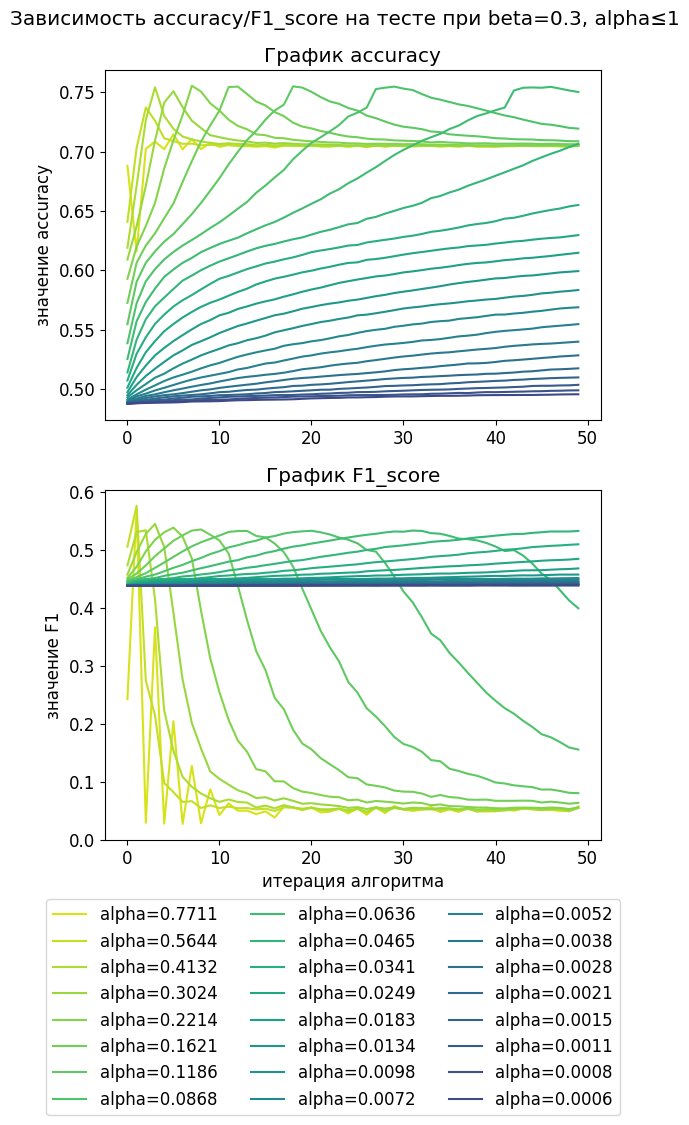

In [1171]:
fig, axis = plt.subplots(2, 1)
# fig.set_figwidth(3)
fig.set_figheight(10)
title = fig.suptitle('Зависимость accuracy/F1_score на тесте при beta=0.3, alpha≤1')

cmap = plt.get_cmap('viridis')
axis[0].set_prop_cycle(color=[cmap(1 - 1.*(i + 2)/32) for i in range(32)])
axis[0].set_title('График accuracy')
axis[1].set_prop_cycle(color=[cmap(1 - 1.*(i + 2)/32) for i in range(32)])
axis[1].set_title('График F1_score')

i = 1
for hist in alpha_stats_fix_beta_sgd[::-1]:
    if hist['alpha'] > 1 or hist['alpha'] < 0.0005:
        continue
    axis[0].plot(np.arange(len(hist['accuracy'])), hist['accuracy'], label=f'alpha={hist["alpha"]:.4f}')
    axis[1].plot(np.arange(len(hist['recall'])), 2 / (np.array(hist['recall']) ** -1 + np.array(hist['precision']) ** -1), label=f'alpha={hist["alpha"]:.4f}')


axis[1].set_xlabel('итерация алгоритма')

axis[0].set_ylabel('значение accuracy')
axis[1].set_ylabel('значение F1')

title.set_position((0.5, 0.94))
plt.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.46, -0.81))
plt.savefig('./figures/sgdc_accuracy_f1_compare.eps', format='eps', bbox_inches='tight')

### Посмотрим на влияние начального приближения на работу алгоритма

Поступим так же, как и в прошлом пункте и применим те же самые методы определения начального приближения, только для SGD. Все так же оставляем обновление статичтики два раза за эпоху, а размерность батча по 20% от всей обучающей выборки

In [ ]:
model = SGDClassifier(learning_rate=inv_scale_lr(alpha, beta), tolerance=None, max_iter=50, warm_start=False, batch_size=0.2)
alpha_stats_sgd.append({'alpha': alpha, 'beta': beta, **model.fit(X_train, y_train, trace=True, log_freq=0.49, X_test=X_test, y_test=y_test)})

In [1228]:
model = SGDClassifier(learning_rate=inv_scale_lr(0.5, 0.5), tolerance=None, max_iter=50, warm_start=False, batch_size=0.2)


def get_smart_first_weights(X, y):
    return (y @ X) / np.sum(X * X, axis=0)


STATISTIC_COUNT = 5

history = {
    'history_gauss': [],
    'history_uniform': [],
    'history_laplas': [],
    'history_gumbel': [],
    'history_zeros': [],
    'history_smart': []
}

for _ in range(STATISTIC_COUNT):
    history['history_gauss'].append(
        model.fit(default_sparse, default_data.is_toxic.values * 2 - 1, w_0=np.random.normal(size=default_sparse.shape[1]),
                  X_test=default_sparse_test, y_test=default_data_test.is_toxic.values * 2 - 1, trace=True, log_freq=0.49)
    )
    history['history_uniform'].append(
        model.fit(default_sparse, default_data.is_toxic.values * 2 - 1, w_0=np.random.uniform(low=-1, high=1, size=default_sparse.shape[1]),
                  X_test=default_sparse_test, y_test=default_data_test.is_toxic.values * 2 - 1, trace=True, log_freq=0.49)
    )
    history['history_laplas'].append(
        model.fit(default_sparse, default_data.is_toxic.values * 2 - 1, w_0=np.random.laplace(size=default_sparse.shape[1]),
                  X_test=default_sparse_test, y_test=default_data_test.is_toxic.values * 2 - 1, trace=True, log_freq=0.49)
    )
    history['history_gumbel'].append(
        model.fit(default_sparse, default_data.is_toxic.values * 2 - 1, w_0=np.random.gumbel(size=default_sparse.shape[1]),
                  X_test=default_sparse_test, y_test=default_data_test.is_toxic.values * 2 - 1, trace=True, log_freq=0.49)
    )
    history['history_zeros'].append(
        model.fit(default_sparse, default_data.is_toxic.values * 2 - 1, w_0=np.zeros(default_sparse.shape[1]).astype(np.float64),
                  X_test=default_sparse_test, y_test=default_data_test.is_toxic.values * 2 - 1, trace=True, log_freq=0.49)
    )
    history['history_smart'].append(
        model.fit(default_sparse, default_data.is_toxic.values * 2 - 1, w_0=get_smart_first_weights(default_sparse.toarray(), default_data.is_toxic.values * 2 - 1),
                  X_test=default_sparse_test, y_test=default_data_test.is_toxic.values * 2 - 1, trace=True, log_freq=0.49)
    )

# dill.dump(history, open('./data_pickles/init_weights_test_history_SGDC.db', 'wb'))

In [1229]:
history_sgd_to_np = {}
for key, lists in history.items():
    ls_precision = np.array([l['precision'] for l in lists])
    ls_recall = np.array([l['recall'] for l in lists])
    ls_accuracy = np.array([l['accuracy'] for l in lists])
    ls_F1_score = 2 / (ls_recall ** -1 + ls_precision ** -1)
    ls_func = np.array([l['func'] for l in lists])
    history_sgd_to_np[key] = {
        'precision_mean': np.mean(ls_precision, axis=0),
        'precision_std': np.std(ls_precision, axis=0),
        'recall_mean': np.mean(ls_recall, axis=0),
        'recall_std': np.std(ls_recall, axis=0),
        'accuracy_mean': np.mean(ls_accuracy, axis=0),
        'accuracy_std': np.std(ls_accuracy, axis=0),
        'F1_score_mean': np.mean(ls_F1_score, axis=0),
        'F1_score_std': np.std(ls_F1_score, axis=0),
        'func_mean': np.mean(ls_func, axis=0),
        'func_std': np.std(ls_func, axis=0),
    }

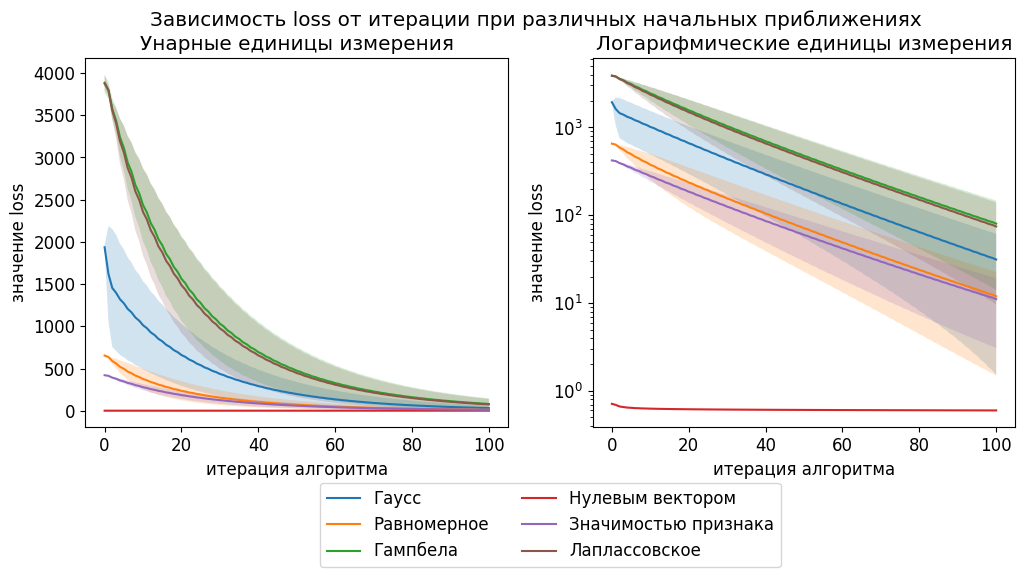

In [1176]:
fig, axis = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.suptitle('Зависимость loss от итерации при различных начальных приближениях')

axis[0].set_title('Унарные единицы измерения')
axis[0].plot(np.arange(101), history_sgd_to_np['history_gauss']['func_mean'], label='Гаусс')
axis[0].plot(np.arange(101), history_sgd_to_np['history_uniform']['func_mean'], label='Равномерное')
axis[0].plot(np.arange(101), history_sgd_to_np['history_gumbel']['func_mean'], label='Гампбела')
axis[0].plot(np.arange(101), history_sgd_to_np['history_zeros']['func_mean'], label='Нулевым вектором')
axis[0].plot(np.arange(101), history_sgd_to_np['history_smart']['func_mean'], label='Значимостью признака')
axis[0].plot(np.arange(101), history_sgd_to_np['history_laplas']['func_mean'], label='Лаплассовское')

axis[0].fill_between(np.arange(101), history_sgd_to_np['history_gauss']['func_mean'] + history_sgd_to_np['history_gauss']['func_std'],
                     history_sgd_to_np['history_gauss']['func_mean'] - history_sgd_to_np['history_gauss']['func_std'], alpha=0.2)
axis[0].fill_between(np.arange(101), history_sgd_to_np['history_uniform']['func_mean'] + history_sgd_to_np['history_uniform']['func_std'],
                     history_sgd_to_np['history_uniform']['func_mean'] - history_sgd_to_np['history_uniform']['func_std'], alpha=0.2)
axis[0].fill_between(np.arange(101), history_sgd_to_np['history_gumbel']['func_mean'] + history_sgd_to_np['history_gumbel']['func_std'],
                     history_sgd_to_np['history_gumbel']['func_mean'] - history_sgd_to_np['history_gumbel']['func_std'], alpha=0.2)
axis[0].fill_between(np.arange(101), history_sgd_to_np['history_zeros']['func_mean'] + history_sgd_to_np['history_zeros']['func_std'],
                     history_sgd_to_np['history_zeros']['func_mean'] - history_sgd_to_np['history_zeros']['func_std'], alpha=0.2)
axis[0].fill_between(np.arange(101), history_sgd_to_np['history_smart']['func_mean'] + history_sgd_to_np['history_smart']['func_std'],
                     history_sgd_to_np['history_smart']['func_mean'] - history_sgd_to_np['history_smart']['func_std'], alpha=0.2)
axis[0].fill_between(np.arange(101), history_sgd_to_np['history_laplas']['func_mean'] + history_sgd_to_np['history_laplas']['func_std'],
                     history_sgd_to_np['history_laplas']['func_mean'] - history_sgd_to_np['history_laplas']['func_std'], alpha=0.2)

axis[1].set_title('Логарифмические единицы измерения')
axis[1].plot(np.arange(101), history_sgd_to_np['history_gauss']['func_mean'], label='Гаусс')
axis[1].plot(np.arange(101), history_sgd_to_np['history_uniform']['func_mean'], label='Равномерное')
axis[1].plot(np.arange(101), history_sgd_to_np['history_gumbel']['func_mean'], label='Гампбела')
axis[1].plot(np.arange(101), history_sgd_to_np['history_zeros']['func_mean'], label='Нулевым вектором')
axis[1].plot(np.arange(101), history_sgd_to_np['history_smart']['func_mean'], label='Значимостью признака')
axis[1].plot(np.arange(101), history_sgd_to_np['history_laplas']['func_mean'], label='Лаплассовское')

axis[1].fill_between(np.arange(101), history_sgd_to_np['history_gauss']['func_mean'] + history_sgd_to_np['history_gauss']['func_std'],
                     history_sgd_to_np['history_gauss']['func_mean'] - history_sgd_to_np['history_gauss']['func_std'], alpha=0.2)
axis[1].fill_between(np.arange(101), history_sgd_to_np['history_uniform']['func_mean'] + history_sgd_to_np['history_uniform']['func_std'],
                     history_sgd_to_np['history_uniform']['func_mean'] - history_sgd_to_np['history_uniform']['func_std'], alpha=0.2)
axis[1].fill_between(np.arange(101), history_sgd_to_np['history_gumbel']['func_mean'] + history_sgd_to_np['history_gumbel']['func_std'],
                     history_sgd_to_np['history_gumbel']['func_mean'] - history_sgd_to_np['history_gumbel']['func_std'], alpha=0.2)
axis[1].fill_between(np.arange(101), history_sgd_to_np['history_zeros']['func_mean'] + history_sgd_to_np['history_zeros']['func_std'],
                     history_sgd_to_np['history_zeros']['func_mean'] - history_sgd_to_np['history_zeros']['func_std'], alpha=0.2)
axis[1].fill_between(np.arange(101), history_sgd_to_np['history_smart']['func_mean'] + history_sgd_to_np['history_smart']['func_std'],
                     history_sgd_to_np['history_smart']['func_mean'] - history_sgd_to_np['history_smart']['func_std'], alpha=0.2)
axis[1].fill_between(np.arange(101), history_sgd_to_np['history_laplas']['func_mean'] + history_sgd_to_np['history_laplas']['func_std'],
                     history_sgd_to_np['history_laplas']['func_mean'] - history_sgd_to_np['history_laplas']['func_std'], alpha=0.2)

for ax in axis:
    ax.set_xlabel('итерация алгоритма')
    ax.set_ylabel('значение loss')

axis[1].set_yscale('log')
plt.legend(loc='lower center', ncol=2, bbox_to_anchor=(-0.1, -0.4))
plt.savefig('./figures/sgdc_init_weight_loss_compare.pdf', format='pdf', bbox_inches='tight')

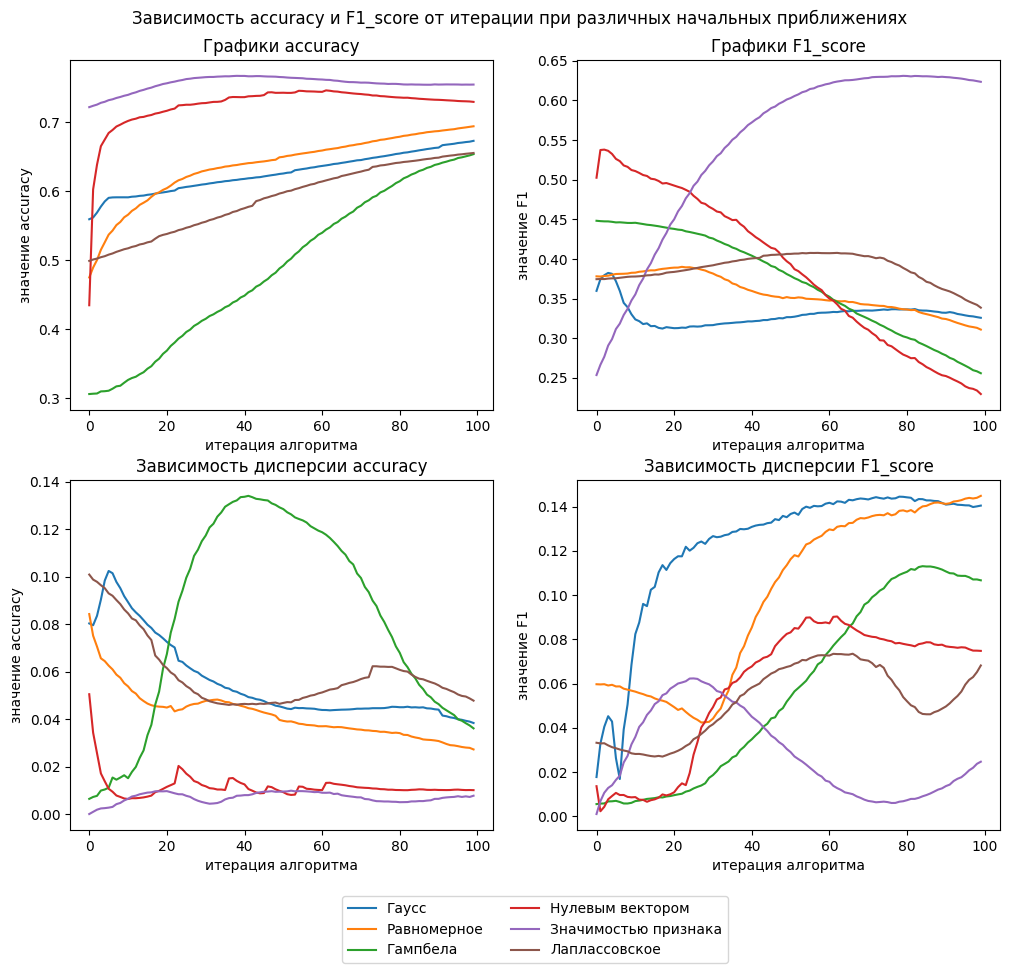

In [ ]:
fig, axis = plt.subplots(2, 2)
fig.set_figwidth(12)
fig.set_figheight(10)
title = fig.suptitle('Зависимость accuracy и F1_score от итерации при различных начальных приближениях')

axis[0][0].set_title('Графики accuracy')
axis[0][0].plot(np.arange(100), history_sgd_to_np['history_gauss']['accuracy_mean'], label='Гаусс')
axis[0][0].plot(np.arange(100), history_sgd_to_np['history_uniform']['accuracy_mean'], label='Равномерное')
axis[0][0].plot(np.arange(100), history_sgd_to_np['history_gumbel']['accuracy_mean'], label='Гампбела')
axis[0][0].plot(np.arange(100), history_sgd_to_np['history_zeros']['accuracy_mean'], label='Нулевым вектором')
axis[0][0].plot(np.arange(100), history_sgd_to_np['history_smart']['accuracy_mean'], label='Значимостью признака')
axis[0][0].plot(np.arange(100), history_sgd_to_np['history_laplas']['accuracy_mean'], label='Лаплассовское')

axis[1][0].set_title('Зависимость дисперсии accuracy')
axis[1][0].plot(np.arange(100), history_sgd_to_np['history_gauss']['accuracy_std'])
axis[1][0].plot(np.arange(100), history_sgd_to_np['history_uniform']['accuracy_std'])
axis[1][0].plot(np.arange(100), history_sgd_to_np['history_gumbel']['accuracy_std'])
axis[1][0].plot(np.arange(100), history_sgd_to_np['history_zeros']['accuracy_std'])
axis[1][0].plot(np.arange(100), history_sgd_to_np['history_smart']['accuracy_std'])
axis[1][0].plot(np.arange(100), history_sgd_to_np['history_laplas']['accuracy_std'])

axis[0][1].set_title('Графики F1_score')
axis[0][1].plot(np.arange(100), history_sgd_to_np['history_gauss']['F1_score_mean'], label='Гаусс')
axis[0][1].plot(np.arange(100), history_sgd_to_np['history_uniform']['F1_score_mean'], label='Равномерное')
axis[0][1].plot(np.arange(100), history_sgd_to_np['history_gumbel']['F1_score_mean'], label='Гампбела')
axis[0][1].plot(np.arange(100), history_sgd_to_np['history_zeros']['F1_score_mean'], label='Нулевым вектором')
axis[0][1].plot(np.arange(100), history_sgd_to_np['history_smart']['F1_score_mean'], label='Значимостью признака')
axis[0][1].plot(np.arange(100), history_sgd_to_np['history_laplas']['F1_score_mean'], label='Лаплассовское')

axis[1][1].set_title('Зависимость дисперсии F1_score')
axis[1][1].plot(np.arange(100), history_sgd_to_np['history_gauss']['F1_score_std'])
axis[1][1].plot(np.arange(100), history_sgd_to_np['history_uniform']['F1_score_std'])
axis[1][1].plot(np.arange(100), history_sgd_to_np['history_gumbel']['F1_score_std'])
axis[1][1].plot(np.arange(100), history_sgd_to_np['history_zeros']['F1_score_std'])
axis[1][1].plot(np.arange(100), history_sgd_to_np['history_smart']['F1_score_std'])
axis[1][1].plot(np.arange(100), history_sgd_to_np['history_laplas']['F1_score_std'])

for ax in axis:
    ax[0].set_xlabel('итерация алгоритма')
    ax[1].set_xlabel('итерация алгоритма')

axis[0][0].set_ylabel('значение accuracy')
axis[1][0].set_ylabel('значение accuracy')
axis[0][1].set_ylabel('значение F1')
axis[1][1].set_ylabel('значение F1')

axis[0][0].legend(loc='lower center', ncol=2, bbox_to_anchor=(1.1, -1.6))
title.set_position([.5, 0.93])

### Проанализируем зависимость стохастического градиентного спуска от batch_size

Главная вещь, что отличает подход стохастического градиентного спуска от обычного градиентного спуска - на каждой итерации нам не приходится пересчитывать градиент по всей выборке, ограничиваясь лишь ее частью, размер которой как раз и задает в нашем случае параметр batch_size. Зафиксируем модель и проведем для нее процесс обучения с разными параметрами по batch_size

In [1204]:
batch_size_stats = []
for bs in np.linspace(0.05, 0.65, 10):
    model = SGDClassifier(learning_rate=inv_scale_lr(0.5, 0.5), tolerance=None, max_iter=50, warm_start=False, batch_size=bs)
    batch_size_stats.append({'bs': bs, **model.fit(X_train, y_train, trace=True, log_freq=0.49, X_test=X_test, y_test=y_test)})

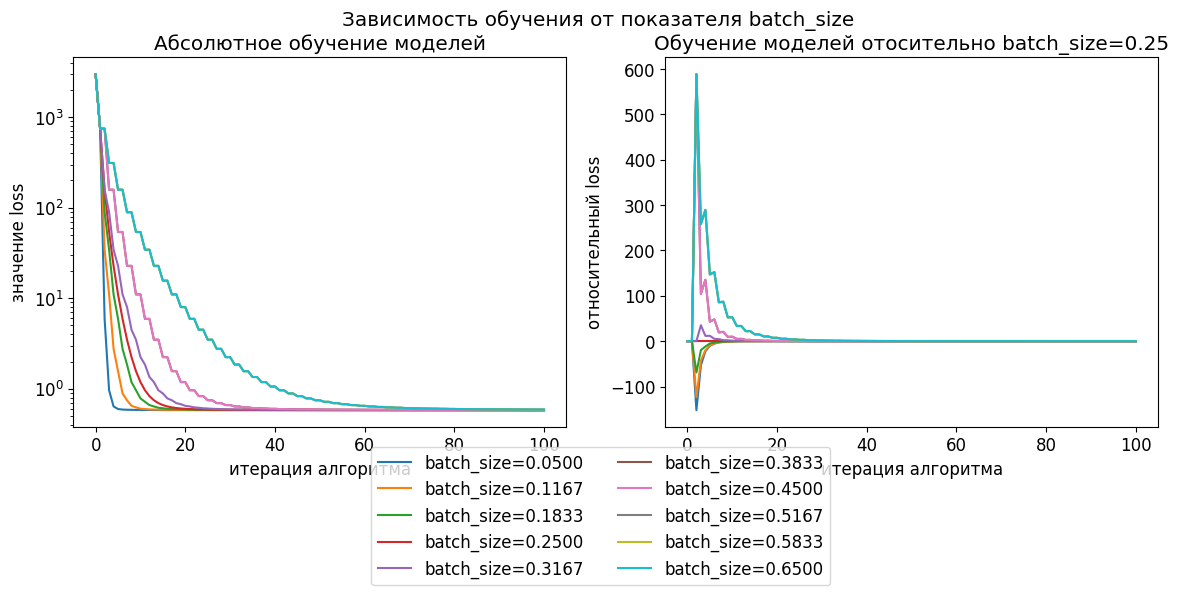

In [1210]:
fig, axis = plt.subplots(1, 2)
fig.set_figwidth(14)
fig.suptitle('Зависимость обучения от показателя batch_size')
axis[0].set_title('Абсолютное обучение моделей')
for history in batch_size_stats:
    temp = history['func']
    if len(temp) == 51:
        temp = np.hstack([temp[0], np.repeat(temp[1:], 2)])
    axis[0].plot(np.arange(len(temp)), temp, label=f'batch_size={history["bs"]:.4f}')

axis[0].set_xlabel('итерация алгоритма')
axis[0].set_ylabel('значение loss')

axis[0].set_yscale('log')

axis[1].set_title('Обучение моделей отосительно batch_size=0.25')
needed = None
for h in batch_size_stats:
    if h['bs'] == 0.25:
        needed = np.array(h['func'])
for history in batch_size_stats:
    temp = history['func']
    if len(temp) == 51:
        temp = np.hstack([temp[0], np.repeat(temp[1:], 2)])

    axis[1].plot(np.arange(len(temp)), (np.array(temp) - needed), label=f'batch_size={history["bs"]:.4f}')

axis[1].set_xlabel('итерация алгоритма')
axis[1].set_ylabel('относительный loss')
# axis[1].set_yscale('log')

plt.legend(loc='lower center', ncol=2, bbox_to_anchor=(-0.13, -0.45))

Как можно заметить, чем меньше показатель batch_size, тем быстрее падает loss, а модель быстрее обучается, если характеризовать скорость обучения количеством эпох, необходимых, чтобы модель обучилась. Таким образом, при меньших batch_size, модель больше уделяет внимания каждому объекту по отдельности. Тогда сравним быстродействие модели при каждом показателе.

Теперь выберем фактором остановки обучения модели параметр tolerance, чтобы сравнить, за какое время каждый из показателей batch_size сможет вывести модель на плато.

In [1240]:
batch_size_time = []
for bs in np.linspace(0.05, 0.65, 10):
    model = SGDClassifier(learning_rate=inv_scale_lr(0.1, 0.5), tolerance=1e-5, max_iter=500, warm_start=False, batch_size=bs)
    batch_size_time.append({'bs': bs, **model.fit(X_train, y_train, trace=True, w_0=np.random.gumbel(size=X_train.shape[1]), log_freq=0.49, X_test=X_test, y_test=y_test)})

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


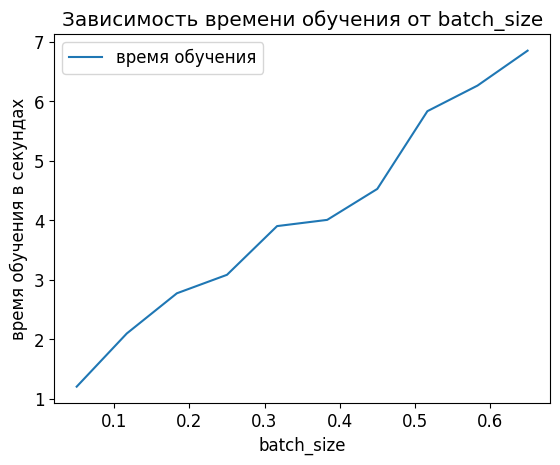

In [1238]:
plt.title('Зависимость времени обучения от batch_size')
plt.ylabel('время обучения в секундах')
plt.xlabel('batch_size')

times = [h['time'][-1] - h['time'][0] for h in batch_size_time]

plt.plot(np.linspace(0.05, 0.65, 10), times, label='время обучения')
plt.legend()
plt.savefig('./figures/sgdc_time_from_batch_size.eps', format='eps', bbox_inches='tight')

Видно, что алгоритмы с самыми малыми размерами батчей сходится наиболее быстро. Проверим теперь, как это сказалось на метриках качества

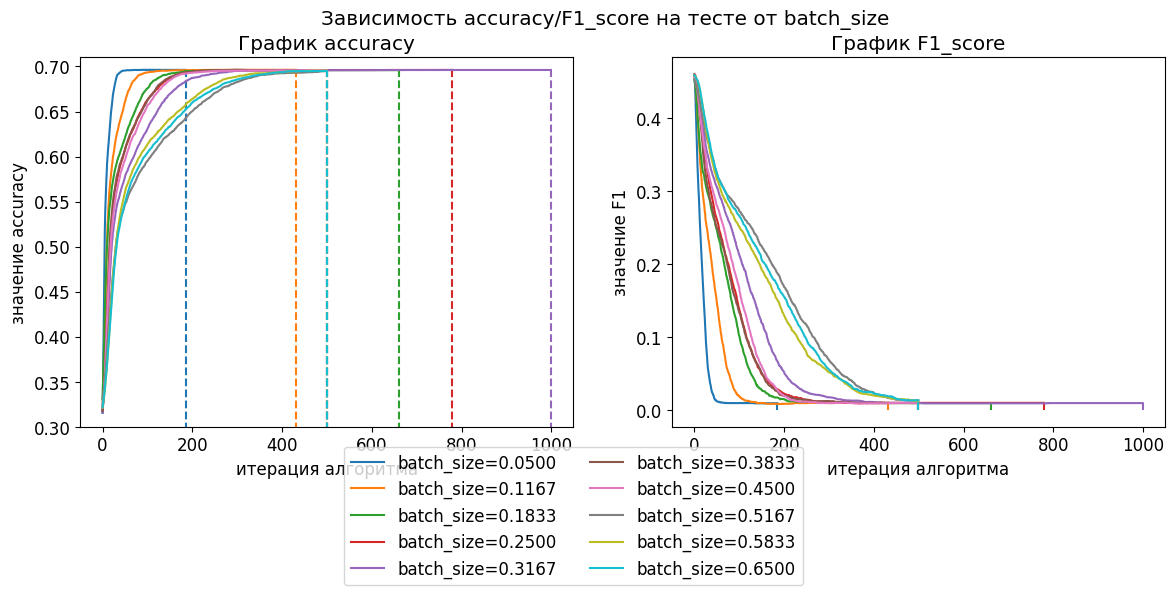

In [1241]:
fig, axis = plt.subplots(1, 2)
fig.set_figwidth(14)
fig.suptitle('Зависимость accuracy/F1_score на тесте от batch_size')

cmap = plt.get_cmap('viridis')
# axis[0].set_prop_cycle(color=[cmap(1 - 1.*(i + 2)/32) for i in range(32)])
axis[0].set_title('График accuracy')
# axis[1].set_prop_cycle(color=[cmap(1 - 1.*(i + 2)/32) for i in range(32)])
axis[1].set_title('График F1_score')

i = 1
for hist in batch_size_time:
    p = axis[0].plot(np.arange(len(hist['accuracy'])), hist['accuracy'], label=f'batch_size={hist["bs"]:.4f}')
    axis[1].plot(np.arange(len(hist['recall'])), 2 / (np.array(hist['recall']) ** -1 + np.array(hist['precision']) ** -1), label=f'batch_size={hist["bs"]:.4f}')

    axis[0].vlines(x=len(hist['accuracy']) - 1, ymin=0, ymax=hist['accuracy'][-1], colors=p[0].get_color(), linestyles='--')
    axis[1].vlines(x=len(hist['recall']) - 1, ymin=0, ymax=(2 / (np.array(hist['recall']) ** -1 + np.array(hist['precision']) ** -1))[-1], colors=p[0].get_color(), linestyles='--')

for ax in axis:
    ax.set_xlabel('итерация алгоритма')

axis[0].set_ylabel('значение accuracy')
axis[1].set_ylabel('значение F1')


axis[0].set_ylim(0.3, 0.71)
plt.legend(loc='lower center', ncol=2, bbox_to_anchor=(-0.2, -0.45))

Как и стоило ожидать, алгоритмы с большими коэффициентами batch_size выходили на плато в метрике accuracy ощутимо дольше, чем соответсвенные алогритмы с малыми коэффициентами.
Однако при этом именно такие алогритмы дольше остальных показывали сколько-нибудь большой F1_score. Тем самым можно прийти к выводу, что от величины коэффициента разбиения на батчи зависит не только скорость обучения алгоритма, но и скорость его переобучения. 

## Эксперимент №6

## Эксперимент №7

### Общий взгляд на доступные решения

В прошлых экспериментах мы наблюдали такую проблему, как почти полное отсутствие умения определять положительный класс при классификации моделями. Учитывая, что именно в задаче классификации положительного класса состоит наша задача, нам необходимо решить данную проблему. Было выдвинуто предположение, из-за чего скложилась такая ситуация: в действительности, изначальные данные не способствуют качественной классификации, так как в них много слов паразитов, слов, не несущих важной информации для классификации, много различных форм и частей речи, что алгоритмом воспринимаются как обособленные и независимые признаки, хотя в реальности это совершенно не так.

Учитывая то, что в действительности проблема скорее всего лежит именно в данных, предлагается проверить, как мы можем манипулировать исходными данными, чтобы улучшить качество классификации. **Рассмотрим следующие меры:**

1.  Преобразуем числительные в формат слов (символы цифр переведем в словестные эквиваленты)
2.  Удалим "стоп-слова" -> так называемые слова паразиты и слова, применяющиеся настолько часто в любой речи, что не способствуют определению окраски и направленности текста
3.  Применим один из двух алогритмов, способствующих решению проблемы о одинаковых словах, воспринимающихся по-разному алогритмом: применим Лемматизацию и Стемминг

Загрузим датасеты `lemmatize_data` и `stem_data`, что мы получили в **Эксперименте №1** и сравним работу моделей, построенных на них, между собой и моделями, на базе начального датасета `default_data`

In [1259]:
lemmatize_data = dill.load(open('./data_pickles/lemmatize_data.pickle', 'rb'))
lemmatize_data_test = dill.load(open('./data_pickles/lemmatize_data_test.pickle', 'rb'))

stem_data = dill.load(open('./data_pickles/stem_data.pickle', 'rb'))
stem_data_test = dill.load(open('./data_pickles/stem_data_test.pickle', 'rb'))

Вновь будем обучать преобразователь текстов в векторное представление на основе только train выборки, однако теперь будем оставлять лишь те слова, что встречались хотя бы в 30 примерах и не более чем в 50% текстов. Данные правки вызваны тем, что мы явным образом увидели несбалансированность классов. А потому слова, что позволяли бы нам правильноо классифицировать положительный класс, могут встречаться относительно редко в датасете. При чем теперь мы имеем уверенность относительно предобработанных документов, что в них нет большого числа незначимых слов.

In [1260]:
from sklearn.feature_extraction.text import CountVectorizer

# default_data
default_CountVectorizer = CountVectorizer(min_df=10, max_df=0.5).fit(default_data.comment_text)
default_sparse = default_CountVectorizer.transform(default_data.comment_text.values)
default_sparse_test = default_CountVectorizer.transform(default_data_test.comment_text.values)

# lemmatized_data
lemmatize_CountVectorizer = CountVectorizer(min_df=10, max_df=0.5).fit(lemmatize_data.comment_text)
lemmatize_sparse = lemmatize_CountVectorizer.transform(lemmatize_data.comment_text.values)
lemmatize_sparse_test = lemmatize_CountVectorizer.transform(lemmatize_data_test.comment_text.values)

# stemmed_data
stemmed_CountVectorizer = CountVectorizer(min_df=10, max_df=0.5).fit(stem_data.comment_text)
stemmed_sparse = stemmed_CountVectorizer.transform(stem_data.comment_text.values)
stemmed_sparse_test = stemmed_CountVectorizer.transform(stem_data_test.comment_text.values)

In [ ]:
print(f'Размерность признакового пространства для default_data:   {default_sparse.shape[1]}')
print(f'Размерность признакового пространства для stemmed_data:   {stemmed_sparse.shape[1]}')
print(f'Размерность признакового пространства для lemmatize_data: {lemmatize_sparse.shape[1]}')

Размерность признакового пространства для default_data:   11219
Размерность признакового пространства для stemmed_data:   7874
Размерность признакового пространства для lemmatize_data: 9812


Ярко видно, как сильно позволили сократить размерность пространства приемы лемматизации и стемминга. При чем стемминг справился с конкретно этой задачей намного лучше, чем лемматизация. Связано это с тем, что в отличии от лемматизации, стемминг не учитывает части речи и даже разные по семантике слова и работает благодаря предположению, что для определения смысла слова в большинстве случаев нам достаточно хотя бы знать его корень, забывая об окончаниях и даже суффиксах

In [ ]:
# default dataset
X_train_default = default_sparse
X_test_default = default_sparse_test
y_train_default = default_data.is_toxic.values * 2 - 1
y_test_default = default_data_test.is_toxic.values * 2 - 1

# stemmed dataset
X_train_stemmed = stemmed_sparse
X_test_stemmed = stemmed_sparse_test
y_train_stemmed = stem_data.is_toxic.values * 2 - 1
y_test_stemmed = stem_data_test.is_toxic.values * 2 - 1

# lemmatized dataset
X_train_lemmatize = lemmatize_sparse
X_test_lemmatize = lemmatize_sparse_test
y_train_lemmatize = lemmatize_data.is_toxic.values * 2 - 1
y_test_lemmatize = lemmatize_data_test.is_toxic.values * 2 - 1

In [ ]:
alphas = [0.01, 0.03, 0.07, 0.1, 0.5, 0.75, 1.0, 1.2, 1.5, 1.8, 2.0, 2.5]
betas = [0.3, 0.7, 1.0, 1.2]
batch_size = 0.25

cross_dataset_stats = []

for alpha in alphas:
    for beta in betas:
        model_default = SGDClassifier(learning_rate=inv_scale_lr(alpha, beta), tolerance=5 * 1e-5, max_iter=50, batch_size=batch_size)
        cross_dataset_stats.append({'dataset': 'default', 'alpha': alpha, 'beta': beta, 'batch_size': batch_size,
                                    **model_default.fit(X_train_default, y_train_default, trace=True, log_freq=0.49, X_test=X_test_default, y_test=y_test_default)})

        model_stem = SGDClassifier(learning_rate=inv_scale_lr(alpha, beta), tolerance=5 * 1e-5, max_iter=50, batch_size=batch_size)
        cross_dataset_stats.append({'dataset': 'stem', 'alpha': alpha, 'beta': beta, 'batch_size': batch_size,
                                    **model_stem.fit(X_train_stemmed, y_train_stemmed, trace=True, log_freq=0.49, X_test=X_test_stemmed, y_test=y_test_stemmed)})

        model_lem = SGDClassifier(learning_rate=inv_scale_lr(alpha, beta), tolerance=5 * 1e-5, max_iter=50, batch_size=batch_size)
        cross_dataset_stats.append({'dataset': 'lemmatize', 'alpha': alpha, 'beta': beta, 'batch_size': batch_size,
                                    **model_lem.fit(X_train_lemmatize, y_train_lemmatize, trace=True, log_freq=0.49, X_test=X_test_lemmatize, y_test=y_test_lemmatize)})

/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_30173/707067454.py:18: RuntimeWarning: divide by zero encountered in reciprocal
  return 2 / (np.array(h['recall']) ** -1 + np.array(h['precision']) ** -1)


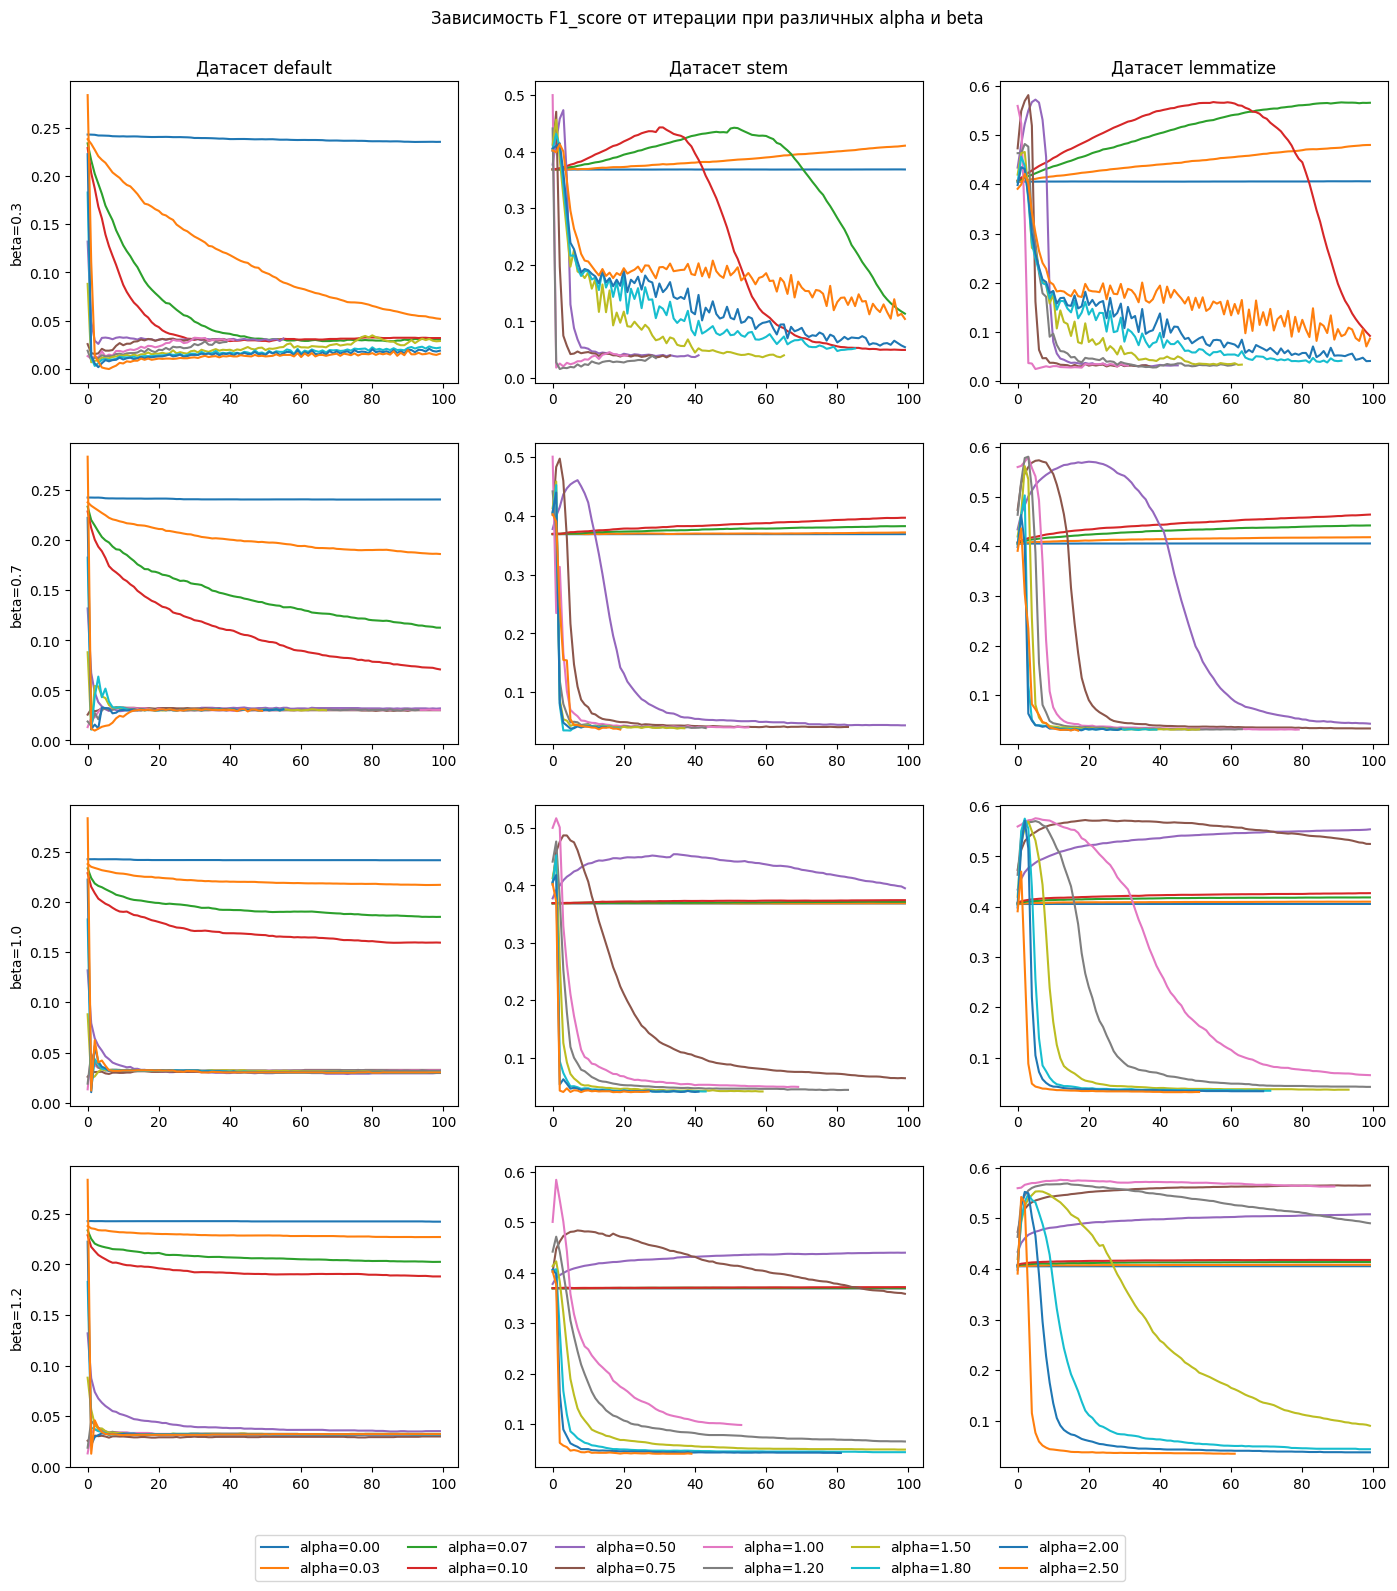

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

fig, axis = plt.subplots(4, 3)
fig.set_figwidth(17)
fig.set_figheight(18)
title = fig.suptitle('Зависимость F1_score от итерации при различных alpha и beta')

cmap = plt.get_cmap('viridis')

# for ax in axis:
#     ax[0].set_prop_cycle(color=[cmap(1 - 1.*(i + 1)/13) for i in range(32)])
#     ax[1].set_prop_cycle(color=[cmap(1 - 1.*(i + 1)/13) for i in range(32)])
#     ax[2].set_prop_cycle(color=[cmap(1 - 1.*(i + 1)/13) for i in range(32)])


def get_F1_score(h):
    return 2 / (np.array(h['recall']) ** -1 + np.array(h['precision']) ** -1)


for hist in cross_dataset_stats:
    if hist['beta'] != 0.3:
        continue
    if hist['dataset'] == 'default':
        axis[0][0].plot(np.arange(len(hist['accuracy'])), get_F1_score(hist), label=f'alpha={hist["alpha"]:.2f}')
    if hist['dataset'] == 'stem':
        axis[0][1].plot(np.arange(len(hist['accuracy'])), get_F1_score(hist), label=f'alpha={hist["alpha"]:.2f}')
    if hist['dataset'] == 'lemmatize':
        axis[0][2].plot(np.arange(len(hist['accuracy'])), get_F1_score(hist), label=f'alpha={hist["alpha"]:.2f}')

for hist in cross_dataset_stats:
    if hist['beta'] != 0.7:
        continue
    if hist['dataset'] == 'default':
        axis[1][0].plot(np.arange(len(hist['accuracy'])), get_F1_score(hist), label=f'alpha={hist["alpha"]:.2f}')
    if hist['dataset'] == 'stem':
        axis[1][1].plot(np.arange(len(hist['accuracy'])), get_F1_score(hist), label=f'alpha={hist["alpha"]:.2f}')
    if hist['dataset'] == 'lemmatize':
        axis[1][2].plot(np.arange(len(hist['accuracy'])), get_F1_score(hist), label=f'alpha={hist["alpha"]:.2f}')

for hist in cross_dataset_stats:
    if hist['beta'] != 1.0:
        continue
    if hist['dataset'] == 'default':
        axis[2][0].plot(np.arange(len(hist['accuracy'])), get_F1_score(hist), label=f'alpha={hist["alpha"]:.2f}')
    if hist['dataset'] == 'stem':
        axis[2][1].plot(np.arange(len(hist['accuracy'])), get_F1_score(hist), label=f'alpha={hist["alpha"]:.2f}')
    if hist['dataset'] == 'lemmatize':
        axis[2][2].plot(np.arange(len(hist['accuracy'])), get_F1_score(hist), label=f'alpha={hist["alpha"]:.2f}')

for hist in cross_dataset_stats:
    if hist['beta'] != 1.2:
        continue
    if hist['dataset'] == 'default':
        axis[3][0].plot(np.arange(len(hist['accuracy'])), get_F1_score(hist), label=f'alpha={hist["alpha"]:.2f}')
    if hist['dataset'] == 'stem':
        axis[3][1].plot(np.arange(len(hist['accuracy'])), get_F1_score(hist), label=f'alpha={hist["alpha"]:.2f}')
    if hist['dataset'] == 'lemmatize':
        axis[3][2].plot(np.arange(len(hist['accuracy'])), get_F1_score(hist), label=f'alpha={hist["alpha"]:.2f}')

axis[0][0].set_title('Датасет default')
axis[0][1].set_title('Датасет stem')
axis[0][2].set_title('Датасет lemmatize')

axis[0][0].set_ylabel('beta=0.3')
axis[1][0].set_ylabel('beta=0.7')
axis[2][0].set_ylabel('beta=1.0')
axis[3][0].set_ylabel('beta=1.2')

# for ax in axis:
#     ax[0].set_yscale('log')
#     ax[1].set_yscale('log')
#     ax[2].set_yscale('log')


plt.legend(loc='lower center', ncol=6, bbox_to_anchor=(-0.8, -0.4))
title.set_position([.5, 0.92])

Заметим, что только для моделей, обученных на датасетах `lemmatize_data` и `stem_data` существуют такие модели при beta=1.2, что для alpha не близких к нулю имеют хороший F1_score. Попробуем теперь ближе рассмотреть эти два класса моделей на `lemmatize_data` и `stem_data`

In [ ]:
spec_classes = list(filter(lambda x: x['beta'] == 1.2 and (x['dataset'] == 'lemmatize' or x['dataset'] == 'stem'), cross_dataset_stats))

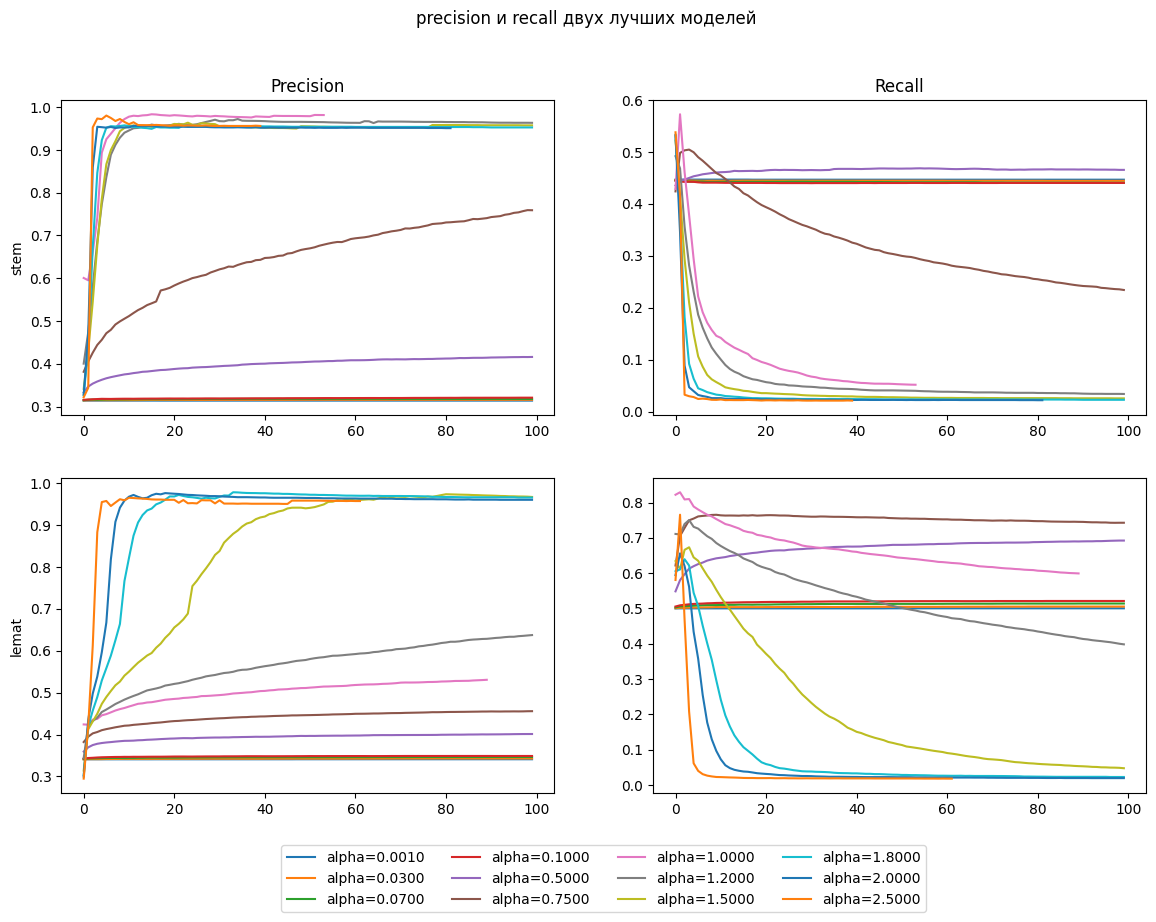

In [ ]:
fig, axis = plt.subplots(2, 2)
fig.set_figwidth(14)
fig.set_figheight(9)
fig.suptitle('precision и recall двух лучших моделей')

axis[0][0].set_title('Precision')
axis[0][1].set_title('Recall')
axis[0][0].set_ylabel('stem')
axis[1][0].set_ylabel('lemat')

for hist in spec_classes:
    if hist['dataset'] == 'stem':
        axis[0][0].plot(np.arange(len(hist['precision'])), hist['precision'], label=f'alpha={hist["alpha"]:.4f}')
        axis[0][1].plot(np.arange(len(hist['recall'])), hist['recall'], label=f'alpha={hist["alpha"]:.4f}')

for hist in spec_classes:
    if hist['dataset'] == 'lemmatize':
        axis[1][0].plot(np.arange(len(hist['precision'])), hist['precision'], label=f'alpha={hist["alpha"]:.4f}')
        axis[1][1].plot(np.arange(len(hist['recall'])), hist['recall'], label=f'alpha={hist["alpha"]:.4f}')

plt.legend(loc='lower center', ncol=4, bbox_to_anchor=(-0.1, -0.4))

### Работа с датасетом с лемматизацией и стеммингом

Загрузим датасет и применим к нему метод векторизации

In [1488]:
from sklearn.feature_extraction.text import CountVectorizer

# default dataset
default_data = dill.load(open('./data_pickles/default_data.pickle', 'rb'))
default_data_test = dill.load(open('./data_pickles/default_data_test.pickle', 'rb'))
default_CountVectorizer = CountVectorizer(min_df=50).fit(default_data.comment_text)
default_sparse = default_CountVectorizer.transform(default_data.comment_text.values)
default_sparse_test = default_CountVectorizer.transform(default_data_test.comment_text.values)

# stemmed
stem_data = dill.load(open('./data_pickles/stem_data.pickle', 'rb'))
stem_data_test = dill.load(open('./data_pickles/stem_data_test.pickle', 'rb'))
stemmed_CountVectorizer = CountVectorizer(min_df=50).fit(stem_data.comment_text)
stemmed_sparse = stemmed_CountVectorizer.transform(stem_data.comment_text.values)
stemmed_sparse_test = stemmed_CountVectorizer.transform(stem_data_test.comment_text.values)

# lematized
lemmatize_data = dill.load(open('./data_pickles/lemmatize_data.pickle', 'rb'))
lemmatize_data_test = dill.load(open('./data_pickles/lemmatize_data_test.pickle', 'rb'))
lemmatize_CountVectorizer = CountVectorizer(min_df=50).fit(lemmatize_data.comment_text)
lemmatize_sparse = lemmatize_CountVectorizer.transform(lemmatize_data.comment_text.values)
lemmatize_sparse_test = lemmatize_CountVectorizer.transform(lemmatize_data_test.comment_text.values)

Теперь попробуем обучить несколько моделей на двух датасетах (`default_data` и `lemmatize_data`) с одинаковыми настройками.

Определим, что мы хотим сравнить для двух таких моделей:

*   Скорость обучения модели
*   Изменение качества классификации
* Размерность признакового пространства


In [1264]:
print(f'Размерность признакового пространства для default_data:   {default_sparse.shape[1]}')
print(f'Размерность признакового пространства для stemmed_data:   {stemmed_sparse.shape[1]}')
print(f'Размерность признакового пространства для lemmatize_data: {lemmatize_sparse.shape[1]}')

Размерность признакового пространства для default_data:   11222
Размерность признакового пространства для stemmed_data:   7874
Размерность признакового пространства для lemmatize_data: 9816


Как видно, с помощью дкматизации нам удалось избавиться от полуторы тысячи слов в датасете при таких параметрах. 

Посмотрим на зависимость времени обучения от датасета, на котором модель обучалась

In [1489]:
# default dataset
X_train_default = default_sparse
X_test_default = default_sparse_test
y_train_default = default_data.is_toxic.values * 2 - 1
y_test_default = default_data_test.is_toxic.values * 2 - 1

# stemmed dataset
X_train_stemmed = stemmed_sparse
X_test_stemmed = stemmed_sparse_test
y_train_stemmed = stem_data.is_toxic.values * 2 - 1
y_test_stemmed = stem_data_test.is_toxic.values * 2 - 1

# lemmatized dataset
X_train_lemmatize = lemmatize_sparse
X_test_lemmatize = lemmatize_sparse_test
y_train_lemmatize = lemmatize_data.is_toxic.values * 2 - 1
y_test_lemmatize = lemmatize_data_test.is_toxic.values * 2 - 1

In [ ]:
np.random.gumbel()

In [1492]:
model_lem = SGDClassifier(learning_rate=inv_scale_lr(5, 0.2), l2_coef=0, tolerance=None, max_iter=400)
history1 = model_lem.fit(X_train_lemmatize, y_train_lemmatize, trace=True, X_test=X_test_lemmatize, y_test=y_test_lemmatize, w_0=np.zeros(X_train_lemmatize.shape[1]), intercept=0)
model_lem = SGDClassifier(learning_rate=inv_scale_lr(5, 0.2), l2_coef=0, tolerance=None, max_iter=400)
history2 = model_lem.fit(X_train_stemmed, y_train_stemmed, trace=True, X_test=X_test_stemmed, y_test=y_test_stemmed, w_0=np.zeros(X_train_stemmed.shape[1]), intercept=0)

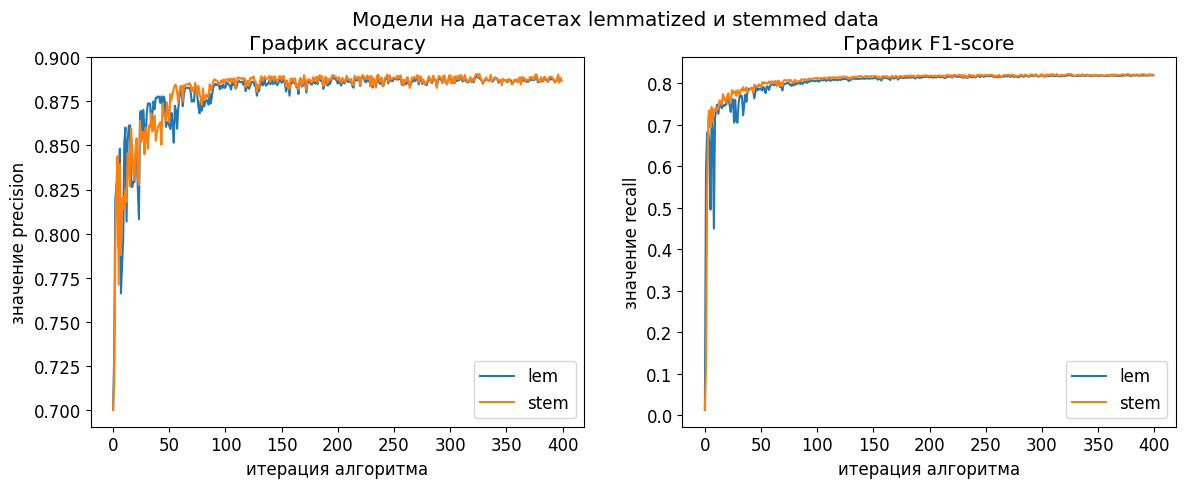

In [1493]:
fig, axis = plt.subplots(1, 2)
fig.set_figwidth(14)
fig.suptitle('Модели на датасетах lemmatized и stemmed data')

# cmap = plt.get_cmap('viridis')
# axis[0].set_prop_cycle(color=[cmap(1 - 1.*(i + 2)/32) for i in range(32)])
axis[0].set_title('График accuracy')
# axis[1].set_prop_cycle(color=[cmap(1 - 1.*(i + 2)/32) for i in range(32)])
axis[1].set_title('График F1-score')

# axis[0].set_yscale('log')
axis[0].plot(np.arange(len(history1['accuracy'])), history1['accuracy'], label='lem')
axis[1].plot(np.arange(len(history1['recall'])), 2 / (np.array(history1['recall']) ** -1 + np.array(history1['precision']) ** -1), label='lem')
axis[0].plot(np.arange(len(history2['accuracy'])), history2['accuracy'], label='stem')
axis[1].plot(np.arange(len(history2['recall'])), 2 / (np.array(history2['recall']) ** -1 + np.array(history2['precision']) ** -1), label='stem')

axis[0].legend()
axis[1].legend()
axis[0].set_ylabel('значение precision')
axis[1].set_ylabel('значение recall')
for ax in axis:
    ax.set_xlabel('итерация алгоритма')


# plt.legend(loc='lower center', ncol=6, bbox_to_anchor=(-0.2, -0.45))

In [ ]:
first_lematize_versus = []

alphas = [12, 15]
betas = [0.01, 0.05, 0.1, 0.2, 0.4, 0.7, 1.0]
batch_size = 0.25

for alpha in alphas:
    for beta in betas:
        model_default = SGDClassifier(learning_rate=inv_scale_lr(alpha, beta), tolerance=1e-4, max_iter=400, batch_size=batch_size, l2_coef=0)
        first_lematize_versus.append({'dataset': 'default', 'alpha': alpha, 'beta': beta, 'batch_size': batch_size,
                                      **model_default.fit(X_train_default, y_train_default, trace=True, log_freq=0.49, X_test=X_test_default, y_test=y_test_default)})
        model_stem = SGDClassifier(learning_rate=inv_scale_lr(alpha, beta), tolerance=1e-4, max_iter=400, batch_size=batch_size, l2_coef=0)
        first_lematize_versus.append({'dataset': 'stem', 'alpha': alpha, 'beta': beta, 'batch_size': batch_size,
                                      **model_stem.fit(X_train_stemmed, y_train_stemmed, trace=True, log_freq=0.49, X_test=X_test_stemmed, y_test=y_test_stemmed)})
        model_lem = SGDClassifier(learning_rate=inv_scale_lr(alpha, beta), tolerance=1e-4, max_iter=400, batch_size=batch_size, l2_coef=0)
        first_lematize_versus.append({'dataset': 'lemmatize', 'alpha': alpha, 'beta': beta, 'batch_size': batch_size,
                                      **model_lem.fit(X_train_lemmatize, y_train_lemmatize, trace=True, log_freq=0.49, X_test=X_test_lemmatize, y_test=y_test_lemmatize)})

In [1365]:
alphas = [0.1, 0.5, 1.0, 3.0, 5, 7.5, 10, 12]

In [1357]:
{x['alpha'] for x in first_lematize_versus}

{0.1, 0.5, 1.0, 3.0, 5, 7.5, 10, 12, 15}

In [1359]:
first_lematize_versus = list(filter(lambda x: x['alpha'] < 14, first_lematize_versus))

In [1360]:
dill.dump(first_lematize_versus, open('./data_pickles/lemotize_stam_versus_default_task7.db', 'wb'))

#### Усреднив по beta построить граффик по времени от каждого alpha обоих алгоритмов

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


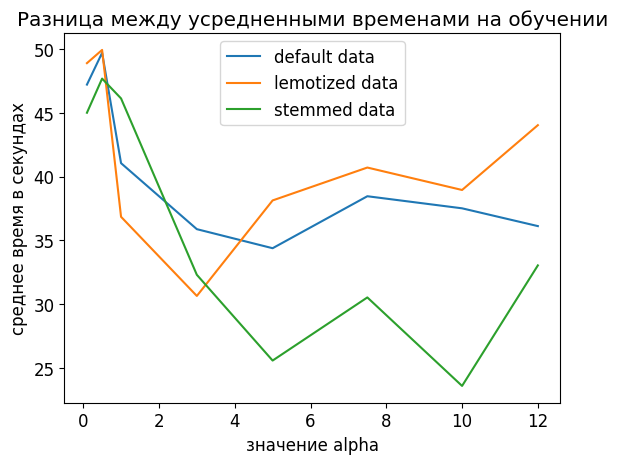

In [1366]:
alpha_set_default = np.array([[t['time'][-1] - t['time'][0] for t in filter(lambda x: x['dataset'] == 'default' and x['alpha'] == alp, first_lematize_versus)] for alp in alphas])
alpha_set_lemotized = np.array([[t['time'][-1] - t['time'][0] for t in filter(lambda x: x['dataset'] == 'lemmatize' and x['alpha'] == alp, first_lematize_versus)] for alp in alphas])
alpha_set_stemmed = np.array([[t['time'][-1] - t['time'][0] for t in filter(lambda x: x['dataset'] == 'stem' and x['alpha'] == alp, first_lematize_versus)] for alp in alphas])

mean_default = np.mean(alpha_set_default, axis=1)
mean_lemotized = np.mean(alpha_set_lemotized, axis=1)
mean_stem = np.mean(alpha_set_stemmed, axis=1)
max_default = np.max(alpha_set_default, axis=1)
min_default = np.min(alpha_set_default, axis=1)
max_lemotized = np.max(alpha_set_lemotized, axis=1)
min_lemotized = np.min(alpha_set_lemotized, axis=1)
max_stemmed = np.max(alpha_set_stemmed, axis=1)
min_stemmed = np.min(alpha_set_stemmed, axis=1)

plt.title('Разница между усредненными временами на обучении')
plt.xlabel('значение alpha')
plt.ylabel('среднее время в секундах')

plt.plot(alphas, mean_default, label='default data')
plt.plot(alphas, mean_lemotized, label='lemotized data')
plt.plot(alphas, mean_stem, label='stemmed data')

plt.legend()
plt.savefig('./figures/time_consume_comp_for_stem_lem_def.eps', format='eps', bbox_inches='tight')

Видно, что в среднем время, затрачиваемое на обучение модели, c значительно упало на стеммированных данных данных

#### Посмотрим теперь на качество, что выдают данные алогиртмы при данных настройках CountVectorizer в своих пространствах

In [38]:
! pipenv install tabulate

Courtesy Notice: Pipenv found itself running within a virtual environment, so it will automatically use that environment, instead of creating its own for any project. You can set PIPENV_IGNORE_VIRTUALENVS=1 to force pipenv to ignore that environment and create its own instead. You can set PIPENV_VERBOSITY=-1 to suppress this warning.
Installing tabulate...
Resolving tabulate...
✔ Installation Succeeded
⠋ Installing tabulate...
Installing dependencies from Pipfile.lock (ee3c8b)...
To activate this project's virtualenv, run pipenv shell.
Alternatively, run a command inside the virtualenv with pipenv run.


#### `default_dataset`

In [1391]:
import tabulate

sorted_by_alpha = sorted(list(filter(lambda x: x['dataset'] == 'default', first_lematize_versus)), key=lambda x: x['alpha'])

table_accuracy = [
    *[
        [beta, *[f'{t["accuracy"][-1]:0.3f}' for t in filter(lambda x: x['beta'] == beta, sorted_by_alpha)]] for beta in betas
    ]
]
table_recall = [
    *[
        [beta, *[f'{t["recall"][-1]:0.3f}' for t in filter(lambda x: x['beta'] == beta, sorted_by_alpha)]] for beta in betas
    ]
]
table_precision = [
    *[
        [beta, *[f'{t["precision"][-1]:0.3f}' for t in filter(lambda x: x['beta'] == beta, sorted_by_alpha)]] for beta in betas
    ]
]
table_f1 = [
    *[
        [beta, *[f'{(2 / ((t["recall"][-1] + 1e-15) ** -1 + (t["precision"][-1] + 1e-15) ** -1 )):0.3f}' for t in filter(lambda x: x['beta'] == beta, sorted_by_alpha)]] for beta in betas
    ]
]

0.01 & 0.756 & 0.583 & 0.813 & 0.69  & 0.796 & 0.663 & 0.865 & 0.784 & 0.884 & 0.807 & 0.889 & 0.818 & 0.876 & 0.813 & 0.821 & 0.76  \\
0.05 & 0.746 & 0.568 & 0.804 & 0.674 & 0.806 & 0.681 & 0.839 & 0.748 & 0.874 & 0.791 & 0.866 & 0.788 & 0.885 & 0.819 & 0.839 & 0.777 \\
0.1  & 0.734 & 0.549 & 0.794 & 0.655 & 0.818 & 0.7   & 0.821 & 0.703 & 0.772 & 0.665 & 0.854 & 0.784 & 0.877 & 0.809 & 0.883 & 0.807 \\
0.2  & 0.705 & 0.502 & 0.77  & 0.61  & 0.796 & 0.659 & 0.809 & 0.686 & 0.804 & 0.67  & 0.845 & 0.748 & 0.842 & 0.76  & 0.871 & 0.785 \\
0.4  & 0.656 & 0.431 & 0.725 & 0.533 & 0.753 & 0.579 & 0.793 & 0.653 & 0.81  & 0.686 & 0.816 & 0.697 & 0.785 & 0.645 & 0.726 & 0.608 \\
0.7  & 0.602 & 0.342 & 0.656 & 0.431 & 0.686 & 0.476 & 0.732 & 0.547 & 0.753 & 0.579 & 0.767 & 0.604 & 0.778 & 0.624 & 0.785 & 0.638 \\
1    & 0.582 & 0.304 & 0.61  & 0.358 & 0.635 & 0.397 & 0.678 & 0.463 & 0.698 & 0.492 & 0.716 & 0.519 & 0.729 & 0.542 & 0.737 & 0.554 \\

In [1395]:
print('Accuracy for default_dataset')
print(tabulate.tabulate(table_accuracy, headers=['beta\\alpha', *alphas], tablefmt="simple_grid"))

print('F1_score for default_dataset')
print(tabulate.tabulate(table_f1, headers=['beta\\alpha', *alphas], tablefmt="simple_grid"))

Accuracy for default_dataset
┌──────────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│   beta\alpha │   0.1 │   0.5 │   1.0 │   3.0 │     5 │   7.5 │    10 │    12 │
├──────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│         0.01 │ 0.756 │ 0.813 │ 0.796 │ 0.865 │ 0.884 │ 0.889 │ 0.876 │ 0.821 │
├──────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│         0.05 │ 0.746 │ 0.804 │ 0.806 │ 0.839 │ 0.874 │ 0.866 │ 0.885 │ 0.839 │
├──────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│         0.1  │ 0.734 │ 0.794 │ 0.818 │ 0.821 │ 0.772 │ 0.854 │ 0.877 │ 0.883 │
├──────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│         0.2  │ 0.705 │ 0.77  │ 0.796 │ 0.809 │ 0.804 │ 0.845 │ 0.842 │ 0.871 │
├──────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│         0.4  │ 0.656 │ 0.725 │ 0.753 │ 0.793 │ 0.81  │ 0.816 │ 0.785 │ 0.726 │

In [1349]:
print('Precision for default_dataset')
print(tabulate.tabulate(table_precision, headers=['beta\\alpha', *alphas], tablefmt="latex"))

print('Recall for default_dataset')
print(tabulate.tabulate(table_recall, headers=['beta\\alpha', *alphas], tablefmt="latex"))

Precision for default_dataset
┌──────────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│   beta\alpha │   0.1 │   0.5 │   1.0 │   3.0 │     5 │   7.5 │    10 │
├──────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│         0.01 │ 0.601 │ 0.69  │ 0.662 │ 0.759 │ 0.812 │ 0.81  │ 0.747 │
├──────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│         0.05 │ 0.583 │ 0.677 │ 0.678 │ 0.708 │ 0.79  │ 0.756 │ 0.782 │
├──────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│         0.1  │ 0.561 │ 0.663 │ 0.697 │ 0.704 │ 0.597 │ 0.708 │ 0.762 │
├──────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│         0.2  │ 0.513 │ 0.625 │ 0.665 │ 0.68  │ 0.682 │ 0.733 │ 0.702 │
├──────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│         0.4  │ 0.431 │ 0.546 │ 0.597 │ 0.662 │ 0.686 │ 0.691 │ 0.644 │
├──────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│         0.7  │ 0.34

#### `lemmatized_dataset`

In [1405]:
sorted_by_alpha = sorted(list(filter(lambda x: x['dataset'] == 'lemmatize', first_lematize_versus)), key=lambda x: x['alpha'])

table_accuracy = [
    *[
        [beta, *[f'{t["accuracy"][-1]:0.3f}' for t in filter(lambda x: x['beta'] == beta, sorted_by_alpha)]] for beta in betas
    ]
]
table_recall = [
    *[
        [beta, *[f'{t["recall"][-1]:0.3f}' for t in filter(lambda x: x['beta'] == beta, sorted_by_alpha)]] for beta in betas
    ]
]
table_precision = [
    *[
        [beta, *[f'{t["precision"][-1]:0.3f}' for t in filter(lambda x: x['beta'] == beta, sorted_by_alpha)]] for beta in betas
    ]
]
table_f1 = [
    *[
        [beta, *[f'{(2 / ((t["recall"][-1] + 1e-15) ** -1 + (t["precision"][-1] + 1e-15) ** -1 )):0.3f}' for t in filter(lambda x: x['beta'] == beta, sorted_by_alpha)]] for beta in betas
    ]
]

0.01 & 0.756 & 0.586 & 0.822 & 0.707 & 0.805 & 0.681 & 0.877 & 0.79  & 0.89  & 0.819 & 0.849 & 0.788 & 0.892 & 0.827 & 0.827 & 0.767 \\
0.05 & 0.744 & 0.564 & 0.813 & 0.691 & 0.817 & 0.697 & 0.801 & 0.7   & 0.885 & 0.812 & 0.891 & 0.821 & 0.891 & 0.826 & 0.892 & 0.828 \\
0.1  & 0.727 & 0.531 & 0.799 & 0.666 & 0.806 & 0.678 & 0.786 & 0.649 & 0.836 & 0.692 & 0.887 & 0.815 & 0.889 & 0.821 & 0.892 & 0.824 \\
0.2  & 0.699 & 0.471 & 0.774 & 0.619 & 0.803 & 0.674 & 0.81  & 0.69  & 0.82  & 0.702 & 0.85  & 0.741 & 0.831 & 0.751 & 0.872 & 0.8   \\
0.4  & 0.659 & 0.367 & 0.718 & 0.511 & 0.752 & 0.578 & 0.798 & 0.665 & 0.819 & 0.702 & 0.818 & 0.699 & 0.812 & 0.686 & 0.809 & 0.69  \\
0.7  & 0.627 & 0.282 & 0.659 & 0.367 & 0.681 & 0.424 & 0.726 & 0.529 & 0.752 & 0.579 & 0.77  & 0.612 & 0.783 & 0.635 & 0.791 & 0.65  \\
1    & 0.595 & 0.267 & 0.632 & 0.291 & 0.643 & 0.324 & 0.675 & 0.414 & 0.694 & 0.462 & 0.712 & 0.5   & 0.727 & 0.532 & 0.736 & 0.551 \\

In [1404]:
print('Accuracy for lemotized_dataset')
print(tabulate.tabulate(table_accuracy, headers=['beta\\alpha', *alphas], tablefmt="simple_grid"))

print('F1_score for lemotized_dataset')
print(tabulate.tabulate(table_f1, headers=['beta\\alpha', *alphas], tablefmt="simple_grid"))

Accuracy for lemotized_dataset
┌──────────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│   beta\alpha │   0.1 │   0.5 │   1.0 │   3.0 │     5 │   7.5 │    10 │    12 │
├──────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│         0.01 │ 0.756 │ 0.822 │ 0.805 │ 0.877 │ 0.89  │ 0.849 │ 0.892 │ 0.827 │
├──────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│         0.05 │ 0.744 │ 0.813 │ 0.817 │ 0.801 │ 0.885 │ 0.891 │ 0.891 │ 0.892 │
├──────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│         0.1  │ 0.727 │ 0.799 │ 0.806 │ 0.786 │ 0.836 │ 0.887 │ 0.889 │ 0.892 │
├──────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│         0.2  │ 0.699 │ 0.774 │ 0.803 │ 0.81  │ 0.82  │ 0.85  │ 0.831 │ 0.872 │
├──────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│         0.4  │ 0.659 │ 0.718 │ 0.752 │ 0.798 │ 0.819 │ 0.818 │ 0.812 │ 0.809

In [1352]:
print('Precision for lemotized_dataset')
print(tabulate.tabulate(table_precision, headers=['beta\\alpha', *alphas], tablefmt="simple_grid"))

print('Recall for lemotized_dataset')
print(tabulate.tabulate(table_recall, headers=['beta\\alpha', *alphas], tablefmt="simple_grid"))

Precision for lemotized_dataset
┌──────────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│   beta\alpha │   0.1 │   0.5 │   1.0 │   3.0 │     5 │   7.5 │    10 │
├──────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│         0.01 │ 0.6   │ 0.703 │ 0.674 │ 0.814 │ 0.815 │ 0.684 │ 0.802 │
├──────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│         0.05 │ 0.581 │ 0.687 │ 0.697 │ 0.642 │ 0.798 │ 0.815 │ 0.796 │
├──────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│         0.1  │ 0.551 │ 0.668 │ 0.681 │ 0.642 │ 0.801 │ 0.807 │ 0.797 │
├──────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│         0.2  │ 0.502 │ 0.631 │ 0.674 │ 0.681 │ 0.703 │ 0.771 │ 0.678 │
├──────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│         0.4  │ 0.418 │ 0.535 │ 0.593 │ 0.667 │ 0.698 │ 0.698 │ 0.692 │
├──────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│         0.7  │ 0.

#### `stemmed_dataset`

In [1384]:
sorted_by_alpha = sorted(list(filter(lambda x: x['dataset'] == 'stem', first_lematize_versus)), key=lambda x: x['alpha'])

table_accuracy = [
    *[
        [beta, *[f'{t["accuracy"][-1]:0.3f}' for t in filter(lambda x: x['beta'] == beta, sorted_by_alpha)]] for beta in betas
    ]
]
table_recall = [
    *[
        [beta, *[f'{t["recall"][-1]:0.3f}' for t in filter(lambda x: x['beta'] == beta, sorted_by_alpha)]] for beta in betas
    ]
]
table_precision = [
    *[
        [beta, *[f'{t["precision"][-1]:0.3f}' for t in filter(lambda x: x['beta'] == beta, sorted_by_alpha)]] for beta in betas
    ]
]
table_f1 = [
    *[
        [beta, *[f'{(2 / ((t["recall"][-1] + 1e-15) ** -1 + (t["precision"][-1] + 1e-15) ** -1 )):0.3f}' for t in filter(lambda x: x['beta'] == beta, sorted_by_alpha)]] for beta in betas
    ]
]

0.01 & 0.766 & 0.608 & 0.825 & 0.716 & 0.837 & 0.737 & 0.83  & 0.722 & 0.814 & 0.655 & 0.89  & 0.813 & 0.837 & 0.772 & 0.871 & 0.81  \\
0.05 & 0.756 & 0.592 & 0.816 & 0.7   & 0.836 & 0.736 & 0.844 & 0.748 & 0.822 & 0.701 & 0.871 & 0.8   & 0.851 & 0.786 & 0.873 & 0.81  \\
0.1  & 0.744 & 0.574 & 0.805 & 0.679 & 0.828 & 0.723 & 0.84  & 0.744 & 0.828 & 0.717 & 0.847 & 0.757 & 0.862 & 0.788 & 0.87  & 0.8   \\
0.2  & 0.719 & 0.542 & 0.782 & 0.637 & 0.808 & 0.685 & 0.836 & 0.736 & 0.844 & 0.751 & 0.836 & 0.739 & 0.825 & 0.709 & 0.837 & 0.733 \\
0.4  & 0.655 & 0.464 & 0.737 & 0.563 & 0.762 & 0.603 & 0.804 & 0.678 & 0.822 & 0.711 & 0.834 & 0.731 & 0.838 & 0.74  & 0.843 & 0.747 \\
0.7  & 0.587 & 0.379 & 0.655 & 0.464 & 0.691 & 0.509 & 0.744 & 0.573 & 0.763 & 0.604 & 0.778 & 0.631 & 0.789 & 0.651 & 0.798 & 0.665 \\
1    & 0.555 & 0.366 & 0.597 & 0.387 & 0.629 & 0.426 & 0.684 & 0.503 & 0.711 & 0.536 & 0.729 & 0.558 & 0.741 & 0.572 & 0.751 & 0.586 \\

In [1387]:
print('Accuracy for stemmed_dataset')
print(tabulate.tabulate(table_accuracy, headers=['beta\\alpha', *alphas], tablefmt="simple_grid"))

print('F1_score for stemmed_dataset')
print(tabulate.tabulate(table_f1, headers=['beta\\alpha', *alphas], tablefmt="simple_grid"))

Accuracy for stemmed_dataset
┌──────────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│   beta\alpha │   0.1 │   0.5 │   1.0 │   3.0 │     5 │   7.5 │    10 │    12 │
├──────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│         0.01 │ 0.766 │ 0.825 │ 0.837 │ 0.83  │ 0.814 │ 0.89  │ 0.837 │ 0.871 │
├──────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│         0.05 │ 0.756 │ 0.816 │ 0.836 │ 0.844 │ 0.822 │ 0.871 │ 0.851 │ 0.873 │
├──────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│         0.1  │ 0.744 │ 0.805 │ 0.828 │ 0.84  │ 0.828 │ 0.847 │ 0.862 │ 0.87  │
├──────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│         0.2  │ 0.719 │ 0.782 │ 0.808 │ 0.836 │ 0.844 │ 0.836 │ 0.825 │ 0.837 │
├──────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│         0.4  │ 0.655 │ 0.737 │ 0.762 │ 0.804 │ 0.822 │ 0.834 │ 0.838 │ 0.843 │

In [1382]:
print('Precision for stemmed_dataset')
print(tabulate.tabulate(table_precision, headers=['beta\\alpha', *alphas], tablefmt="simple_grid"))

print('Recall for stemmed_dataset')
print(tabulate.tabulate(table_recall, headers=['beta\\alpha', *alphas], tablefmt="simple_grid"))

Precision for stemmed_dataset
┌──────────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│   beta\alpha │   0.1 │   0.5 │   1.0 │   3.0 │     5 │   7.5 │    10 │    12 │
├──────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│         0.01 │ 0.614 │ 0.701 │ 0.72  │ 0.714 │ 0.742 │ 0.831 │ 0.669 │ 0.727 │
├──────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│         0.05 │ 0.598 │ 0.69  │ 0.714 │ 0.728 │ 0.711 │ 0.755 │ 0.695 │ 0.737 │
├──────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│         0.1  │ 0.578 │ 0.675 │ 0.705 │ 0.718 │ 0.711 │ 0.726 │ 0.735 │ 0.75  │
├──────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│         0.2  │ 0.533 │ 0.639 │ 0.679 │ 0.718 │ 0.723 │ 0.713 │ 0.712 │ 0.728 │
├──────────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│         0.4  │ 0.437 │ 0.564 │ 0.608 │ 0.674 │ 0.697 │ 0.714 │ 0.72  │ 0.725 

## Эксперимент №8

Мы заметили, что предобработка текста уже смогла изменить качество классификации классификации. Однако важной составляющей создания прихнакового пространства является именно постобработка текстов и перевод их в векторное пространство. Мы уже воспользовались одним из таких средств, однако мы не изучили поведение обучения модели в зависимости от параметров, передаваемых ему. Вместе тем мы уже наблюдали, как пространство признаков зависит от настроек такого оператора перевода. 

Вместе с тем сузествует более сильный подход по переводу текстов в числовое векторное пространство. Данный раздел посвящен анализу зависимости работы алогритма от выбранного спсоба перевода:
*   `CountVectorizer`
*   `TfidfTransformer`

И параметров, передаваемых им

### Изучим поведение для CountVectorizer

Будем работать с Лемматизированными и Стеммированными данными

In [1420]:
lemmatize_data = dill.load(open('./data_pickles/lemmatize_data.pickle', 'rb'))
lemmatize_data_test = dill.load(open('./data_pickles/lemmatize_data_test.pickle', 'rb'))

stem_data = dill.load(open('./data_pickles/stem_data.pickle', 'rb'))
stem_data_test = dill.load(open('./data_pickles/stem_data_test.pickle', 'rb'))

Проведем перебор по сетке и выведем размерность каждого из пространств. Для этого перебора стоит придерживаться разумных величин, потому зададим вручную

In [1446]:
lower_bounds = [0.0, 10, 20, 50, 100, 200, 300, 500]
upper_bounds = [40, 75, 150, 250, 600, 1.0]

sets = []

for low in lower_bounds:
    for high in upper_bounds:
        if high < low and high != 1.0:
            sets.append({'lower_bound': low, 'upper_bound': high, 'data': 'lem', 'vectorizer': None})
            sets.append({'lower_bound': low, 'upper_bound': high, 'data': 'stem', 'vectorizer': None})
        else:
            vectorizer = CountVectorizer(min_df=low, max_df=high).fit(lemmatize_data.comment_text)
            sets.append({'lower_bound': low, 'upper_bound': high, 'data': 'lem', 'vectorizer': vectorizer})
            vectorizer = CountVectorizer(min_df=low, max_df=high).fit(stem_data.comment_text)
            sets.append({'lower_bound': low, 'upper_bound': high, 'data': 'stem', 'vectorizer': vectorizer})

In [1444]:
sorted_by_lower = sorted(filter(lambda x: x['data'] == 'lem', sets), key=lambda x: x['lower_bound'])

table_shapes_lem = [
    *[
        [upper, *[f'{t["vectorizer"].transform(lemmatize_data.comment_text.values).shape[1] if t["vectorizer"] is not None else -1}' for t in filter(lambda x: x['upper_bound'] == upper, sorted_by_lower)]] for upper in upper_bounds
    ]
]

print('Размерности пространства признаков при различных коэффициентах min_df и max_df для lemmatized_data')
print(tabulate.tabulate(table_shapes_lem, headers=['upper\\lower', *lower_bounds], tablefmt="latex"))

Размерности пространства признаков при различных коэффициентах min_df и max_df для lemmatized_data
\begin{tabular}{rrrrrrrrr}
\hline
   upper\textbackslash{}lower &   0.0 &   10 &   20 &   50 &   100 &   200 &   300 &   500 \\
\hline
            40 & 75474 & 5825 & 2342 &   -1 &    -1 &    -1 &    -1 &    -1 \\
            75 & 76832 & 7183 & 3700 &  881 &    -1 &    -1 &    -1 &    -1 \\
           150 & 77875 & 8226 & 4743 & 1924 &   575 &    -1 &    -1 &    -1 \\
           250 & 78415 & 8766 & 5283 & 2464 &  1115 &   227 &    -1 &    -1 \\
           600 & 78948 & 9299 & 5816 & 2997 &  1648 &   760 &   392 &    96 \\
             1 & 79465 & 9816 & 6333 & 3514 &  2165 &  1277 &   909 &   613 \\
\hline
\end{tabular}


40 & 62071 & 4488 & 1808 &   -1 &    -1 &    -1 &    -1 &    -1 \\
75 & 63109 & 5526 & 2846 &  669 &    -1 &    -1 &    -1 &    -1 \\
150 & 63936 & 6353 & 3673 & 1496 &   466 &    -1 &    -1 &    -1 \\
250 & 64395 & 6812 & 4132 & 1955 &   925 &   203 &    -1 &    -1 \\
600 & 64910 & 7327 & 4647 & 2470 &  1440 &   718 &   376 &    90 \\
1 & 65461 & 7878 & 5198 & 3021 &  1991 &  1269 &   927 &   641 \\

In [1432]:
sorted_by_lower = sorted(filter(lambda x: x['data'] == 'stem', sets), key=lambda x: x['lower_bound'])

table_shapes_stem = [
    *[
        [upper, *[f'{t["vectorizer"].transform(stem_data.comment_text.values).shape[1] if t["vectorizer"] is not None else -1}' for t in filter(lambda x: x['upper_bound'] == upper, sorted_by_lower)]] for upper in upper_bounds
    ]
]

print('Размерности пространства признаков при различных коэффициентах min_df и max_df для stammed_data')
print(tabulate.tabulate(table_shapes_stem, headers=['upper\\lower', *lower_bounds], tablefmt="simple_grid"))

Размерности пространства признаков при различных коэффициентах min_df и max_df для stammed_data
\begin{tabular}{rrrrrrrrr}
\hline
   upper\textbackslash{}lower &   0.0 &   10 &   20 &   50 &   100 &   200 &   300 &   500 \\
\hline
            40 & 62071 & 4488 & 1808 &   -1 &    -1 &    -1 &    -1 &    -1 \\
            75 & 63109 & 5526 & 2846 &  669 &    -1 &    -1 &    -1 &    -1 \\
           150 & 63936 & 6353 & 3673 & 1496 &   466 &    -1 &    -1 &    -1 \\
           250 & 64395 & 6812 & 4132 & 1955 &   925 &   203 &    -1 &    -1 \\
           600 & 64910 & 7327 & 4647 & 2470 &  1440 &   718 &   376 &    90 \\
             1 & 65461 & 7878 & 5198 & 3021 &  1991 &  1269 &   927 &   641 \\
\hline
\end{tabular}


**Проведем интрепритацию получившихся таблиц**

Что мы хотели увидеть, как будет вести пространство признаков при каждом из ограничений. max_df отвечает за отсечение такиз слов, что встречаются чаще, чем указанное число раз. В то же время min_df отвечает за отсечение таких слов из признаков, что встречаются реже положенного числа раз. В таблице -1 помечены те комбинации коэффициентов, при которых размерность пространства получилась бы равной 0.

Посмотрим на сами значения в каждой из ячеек. По таблице можно сделать несколько показательных утверждений относительно выборки с лематизацией:
-   В нашей обучающей выборке абсолютное большинство слов встречаются меньше 40 раз
-   Абсолютное большинство слов встречается меньше 10 раз

In [1464]:
batch_size = 0.15

for obj in sets:
    if obj['vectorizer'] is None:
        obj['hist'] = None
        continue

    if obj['data'] == 'stem':
        pass
        # X_train_stem = obj['vectorizer'].transform(stem_data.comment_text.values)
        # X_test_stem = obj['vectorizer'].transform(stem_data_test.comment_text.values)
        # y_train_stem = lemmatize_data.is_toxic.values * 2 - 1
        # y_test_stem = lemmatize_data_test.is_toxic.values * 2 - 1

        # model_stem = SGDClassifier(learning_rate=inv_scale_lr(7, 0.01), tolerance=1e-4, max_iter=75, batch_size=batch_size, l2_coef=0.1)
        # obj['hist'] = model_stem.fit(X_train_stem, y_train_stem, trace=True, log_freq=0.49, X_test=X_test_stem, y_test=y_test_stem)
    else:
        X_train_lemmatize = obj['vectorizer'].transform(lemmatize_data.comment_text.values)
        X_test_lemmatize = obj['vectorizer'].transform(lemmatize_data_test.comment_text.values)
        y_train_lemmatize = lemmatize_data.is_toxic.values * 2 - 1
        y_test_lemmatize = lemmatize_data_test.is_toxic.values * 2 - 1

        model_lem = SGDClassifier(learning_rate=inv_scale_lr(7, 0.01), tolerance=1e-4, max_iter=75, batch_size=batch_size, l2_coef=0.1)
        obj['hist'] = model_lem.fit(X_train_lemmatize, y_train_lemmatize, trace=True, log_freq=0.49, X_test=X_test_lemmatize, y_test=y_test_lemmatize)

In [1448]:
dill.dump(sets, open('./data_pickles/diff_vectorize_settings_versus1.db', 'wb'))

Сравним теперь метрики качества алгоритмов на каждом из полученных странств

In [1435]:
lower_bounds = [0.0, 10, 20, 50, 100, 200, 300, 500]
upper_bounds = [40, 75, 150, 250, 600, 1.0]

Время работы CountVectorizer

In [1469]:
sorted_by_lower = sorted(sets, key=lambda x: x['lower_bound'])

table_time = [
    *[
        [upper, *[f'{(t["hist"]["time"][-1]- t["hist"]["time"][0] if t["vectorizer"] is not None else -1):0.3f}' for t in filter(lambda x: x['upper_bound'] == upper and x['data'] == 'lem', sorted_by_lower)]] for upper in upper_bounds
    ]
]


print('time при различных коэффициентах min_df и max_df')
print(tabulate.tabulate(table_time, headers=['upper\\lower', *lower_bounds], tablefmt="latex"))

time при различных коэффициентах min_df и max_df
\begin{tabular}{rrrrrrrrr}
\hline
   upper\textbackslash{}lower &   0.0 &     10 &     20 &     50 &    100 &    200 &    300 &    500 \\
\hline
            40 & 0.969 &  0.323 &  0.576 & -1     & -1     & -1     & -1     & -1     \\
            75 & 0.931 &  0.43  &  0.398 &  0.042 & -1     & -1     & -1     & -1     \\
           150 & 2.573 &  0.633 &  0.265 &  0.362 &  0.266 & -1     & -1     & -1     \\
           250 & 6.841 &  1.842 &  2.637 &  0.727 &  0.6   &  0.398 & -1     & -1     \\
           600 & 2.615 &  0.651 &  2.407 &  0.223 &  0.316 &  0.086 &  0.047 &  0.022 \\
             1 & 9.949 & 14.473 & 10.944 & 11.685 & 11.744 &  7.862 &  7.036 &  6.408 \\
\hline
\end{tabular}


### Тепер посмотрим на работу Tfidfvectorizer

Данное отображение текстов в числовое векторное пространство работает схожим образом с предыдущим рассмотренным методом. Однако оно, в свою очередь, кодирует каждый текст не только опираясь на число вхождений каждого из слов, но и на основе частоты встречаемости каждого слова. Посмотрим, как внедрение такого отображения изменит показатели модели. Пробежимся по той же сетке параметров min_df и max_df

In [1481]:
from sklearn.feature_extraction.text import TfidfVectorizer

lower_bounds = [0.0, 10, 20, 50, 100, 200, 300, 500]
upper_bounds = [40, 75, 150, 250, 600, 1.0]

sets_Tfid = []

for low in lower_bounds:
    for high in upper_bounds:
        if high < low and high != 1.0:
            sets_Tfid.append({'lower_bound': low, 'upper_bound': high, 'vectorizer': None})
        else:
            vectorizer = TfidfVectorizer(min_df=low, max_df=high).fit(lemmatize_data.comment_text)
            sets_Tfid.append({'lower_bound': low, 'upper_bound': high, 'vectorizer': vectorizer})

In [1482]:
sorted_by_lower = sorted(sets_Tfid, key=lambda x: x['lower_bound'])

table_shapes = [
    *[
        [upper, *[f'{t["vectorizer"].transform(lemmatize_data.comment_text.values).shape[1] if t["vectorizer"] is not None else -1}' for t in filter(lambda x: x['upper_bound'] == upper, sorted_by_lower)]] for upper in upper_bounds
    ]
]

print('Размерности пространства признаков при различных коэффициентах min_df и max_df для TfidfVectorizer')
print(tabulate.tabulate(table_shapes, headers=['upper\\lower', *lower_bounds], tablefmt="simple_grid"))

Размерности пространства признаков при различных коэффициентах min_df и max_df для TfidfVectorizer
┌───────────────┬───────┬──────┬──────┬──────┬───────┬───────┬───────┬───────┐
│   upper\lower │   0.0 │   10 │   20 │   50 │   100 │   200 │   300 │   500 │
├───────────────┼───────┼──────┼──────┼──────┼───────┼───────┼───────┼───────┤
│            40 │ 75474 │ 5825 │ 2342 │   -1 │    -1 │    -1 │    -1 │    -1 │
├───────────────┼───────┼──────┼──────┼──────┼───────┼───────┼───────┼───────┤
│            75 │ 76832 │ 7183 │ 3700 │  881 │    -1 │    -1 │    -1 │    -1 │
├───────────────┼───────┼──────┼──────┼──────┼───────┼───────┼───────┼───────┤
│           150 │ 77875 │ 8226 │ 4743 │ 1924 │   575 │    -1 │    -1 │    -1 │
├───────────────┼───────┼──────┼──────┼──────┼───────┼───────┼───────┼───────┤
│           250 │ 78415 │ 8766 │ 5283 │ 2464 │  1115 │   227 │    -1 │    -1 │
├───────────────┼───────┼──────┼──────┼──────┼───────┼───────┼───────┼───────┤
│           600 │ 78948 │ 9299 │

In [169]:
dill.dump(sets_Tfid, open('./data_pickles/Tdiff_vectorize_settings_versus.db', 'wb'))

Имеем те же самые значения размерности, что является ожидаемым результатом. Теперь сравним работу алогритмов на полученных пространствах

In [1494]:
for obj in sets_Tfid:
    if obj['vectorizer'] is None:
        obj['hist'] = None
        continue

    X_train_lemmatize = obj['vectorizer'].transform(lemmatize_data.comment_text.values)
    X_test_lemmatize = obj['vectorizer'].transform(lemmatize_data_test.comment_text.values)
    y_train_lemmatize = lemmatize_data.is_toxic.values * 2 - 1
    y_test_lemmatize = lemmatize_data_test.is_toxic.values * 2 - 1

    model_lem = SGDClassifier(loss_function='binary_logistic', learning_rate=inv_scale_lr(5, 0.01), tolerance=1e-4, max_iter=75, batch_size=batch_size)
    obj['hist'] = model_lem.fit(X_train_lemmatize, y_train_lemmatize, trace=True, log_freq=0.49, X_test=X_test_lemmatize, y_test=y_test_lemmatize)

/Users/artemon/.local/share/virtualenvs/Logistic_regression-MlYyAm1p/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_17319/1703002341.py:52: RuntimeWarning: overflow encountered in multiply
  regul = np.sum(w * w) * self._l2_coef / 2
/var/folders/hk/5434dpv95nl2rxl497d7c0lm0000gn/T/ipykernel_17319/2672580646.py:362: RuntimeWarning: invalid value encountered in scalar subtract
  len(history['func']) > 1 and abs(history['func'][-1] - history['func'][-2]) < self.tolerance:


In [1496]:
sorted_by_lower = sorted(sets_Tfid, key=lambda x: x['lower_bound'])

table_time = [
    *[
        [upper, *[f'{(t["hist"]["time"][-1]- t["hist"]["time"][0] if t["vectorizer"] is not None else -1):0.3f}' for t in filter(lambda x: x['upper_bound'] == upper, sorted_by_lower)]] for upper in upper_bounds
    ]
]

print('время при различных коэффициентах min_df и max_df')
print(tabulate.tabulate(table_time, headers=['upper\\lower', *lower_bounds], tablefmt="latex"))

время при различных коэффициентах min_df и max_df
\begin{tabular}{rrrrrrrrr}
\hline
   upper\textbackslash{}lower &    0.0 &    10 &    20 &     50 &    100 &    200 &    300 &    500 \\
\hline
            40 &  2.045 & 1.221 & 1.034 & -1     & -1     & -1     & -1     & -1     \\
            75 &  2.286 & 3.035 & 2.555 &  0.985 & -1     & -1     & -1     & -1     \\
           150 &  2.624 & 1.816 & 1.669 &  1.362 &  2.156 & -1     & -1     & -1     \\
           250 &  2.752 & 2.988 & 2.03  &  1.716 &  1.514 &  1.815 & -1     & -1     \\
           600 &  3.986 & 2.867 & 2.712 &  2.448 &  2.222 &  1.711 &  1.377 &  0.984 \\
             1 & 11.842 & 8.108 & 9.214 & 10.382 & 13.21  &  7.208 &  6.592 &  6.136 \\
\hline
\end{tabular}


### сравнение эффективности

In [11]:
lemmatize_data = dill.load(open('./data_pickles/lemmatize_data.pickle', 'rb'))
lemmatize_data_test = dill.load(open('./data_pickles/lemmatize_data_test.pickle', 'rb'))

**min_df = 10, max_df = 1.0 -> l2_coef = 0, a/b = 10, 0.2**

In [1518]:
hist_counter = []
hist_tfid = []

for min_df, max_df in [(10, 1.0), (50, 1.0), (20, 250), (50, 600), (0.0, 1.0), (10, 600)]:
    count_vectorizer = CountVectorizer(min_df=min_df, max_df=max_df).fit(lemmatize_data.comment_text)
    tfid_vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df).fit(lemmatize_data.comment_text)

    lemmatize_sparse = count_vectorizer.transform(lemmatize_data.comment_text.values)
    lemmatize_sparse_test = count_vectorizer.transform(lemmatize_data_test.comment_text.values)

    X_train_lemmatize = lemmatize_sparse
    X_test_lemmatize = lemmatize_sparse_test
    y_train_lemmatize = lemmatize_data.is_toxic.values * 2 - 1
    y_test_lemmatize = lemmatize_data_test.is_toxic.values * 2 - 1

    model_lem = SGDClassifier(learning_rate=inv_scale_lr(12, 0.2), l2_coef=0, tolerance=None, max_iter=400)
    hist_counter.append({'pair': (min_df, max_df), **model_lem.fit(X_train_lemmatize, y_train_lemmatize, trace=True, X_test=X_test_lemmatize, y_test=y_test_lemmatize)})

    lemmatize_sparse = tfid_vectorizer.transform(lemmatize_data.comment_text.values)
    lemmatize_sparse_test = tfid_vectorizer.transform(lemmatize_data_test.comment_text.values)

    X_train_lemmatize = lemmatize_sparse
    X_test_lemmatize = lemmatize_sparse_test
    y_train_lemmatize = lemmatize_data.is_toxic.values * 2 - 1
    y_test_lemmatize = lemmatize_data_test.is_toxic.values * 2 - 1

    model_lem = SGDClassifier(learning_rate=inv_scale_lr(13, 0.01), l2_coef=0, tolerance=None, max_iter=400)
    hist_tfid.append({'pair': (min_df, max_df), **model_lem.fit(X_train_lemmatize, y_train_lemmatize, trace=True, X_test=X_test_lemmatize, y_test=y_test_lemmatize)})

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


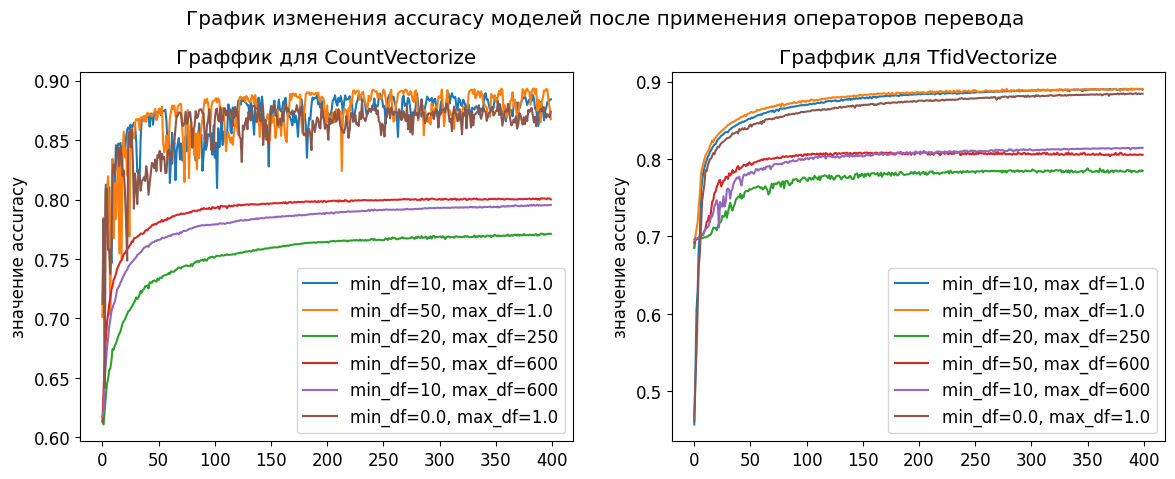

In [1530]:
fig, axis = plt.subplots(1, 2)
fig.set_figwidth(14)
title = fig.suptitle('График изменения accuracy моделей после применения операторов перевода')
title.set_position((0.5, 1.01))
# cmap = plt.get_cmap('viridis')
# axis[0].set_prop_cycle(color=[cmap(1 - 1.*(i + 2)/32) for i in range(32)])
axis[0].set_title('Граффик для CountVectorize')
# axis[1].set_prop_cycle(color=[cmap(1 - 1.*(i + 2)/32) for i in range(32)])
axis[1].set_title('Граффик для TfidVectorize')

for h1, h2 in zip(hist_counter[:4] + hist_counter[5:] + hist_counter[4:5], hist_tfid[:4] + hist_tfid[5:] + hist_tfid[4:5]):
    axis[0].plot(np.arange(len(h1['accuracy'])), h1['accuracy'], label=f'min_df={h1["pair"][0]}, max_df={h1["pair"][1]}')
    axis[1].plot(np.arange(len(h2['accuracy'])), h2['accuracy'], label=f'min_df={h2["pair"][0]}, max_df={h2["pair"][1]}')

axis[0].legend()
axis[1].legend()
axis[0].set_ylabel('значение accuracy')
axis[1].set_ylabel('значение accuracy')

plt.savefig('./figures/accuracy_comp_for_diff_operators.eps', format='eps', bbox_inches='tight')

## Эксперимент №9

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer

lemmatize_data = dill.load(open('./data_pickles/lemmatize_data.pickle', 'rb'))
lemmatize_data_test = dill.load(open('./data_pickles/lemmatize_data_test.pickle', 'rb'))

tfid_vectorizer = TfidfVectorizer(min_df=50).fit(lemmatize_data.comment_text)

lemmatize_sparse = tfid_vectorizer.transform(lemmatize_data.comment_text.values)
lemmatize_sparse_test = tfid_vectorizer.transform(lemmatize_data_test.comment_text.values)

X_train_lemmatize = lemmatize_sparse
X_test_lemmatize = lemmatize_sparse_test
y_train_lemmatize = lemmatize_data.is_toxic.values * 2 - 1
y_test_lemmatize = lemmatize_data_test.is_toxic.values * 2 - 1


finally_best_models = []

for alpha in [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]:
    for beta in [0.01, 0.05, 0.2, 0.6]:
        model = SGDClassifier(learning_rate=inv_scale_lr(alpha, beta), l2_coef=0, tolerance=1e-6, max_iter=400)
        finally_best_models.append({'alpha': alpha, 'beta': beta, **model.fit(X_train_lemmatize, y_train_lemmatize, trace=True, X_test=X_test_lemmatize, y_test=y_test_lemmatize)})

In [1563]:
finally_best_models = dill.load(open('./data_pickles/finally_lem_models.db', 'rb'))

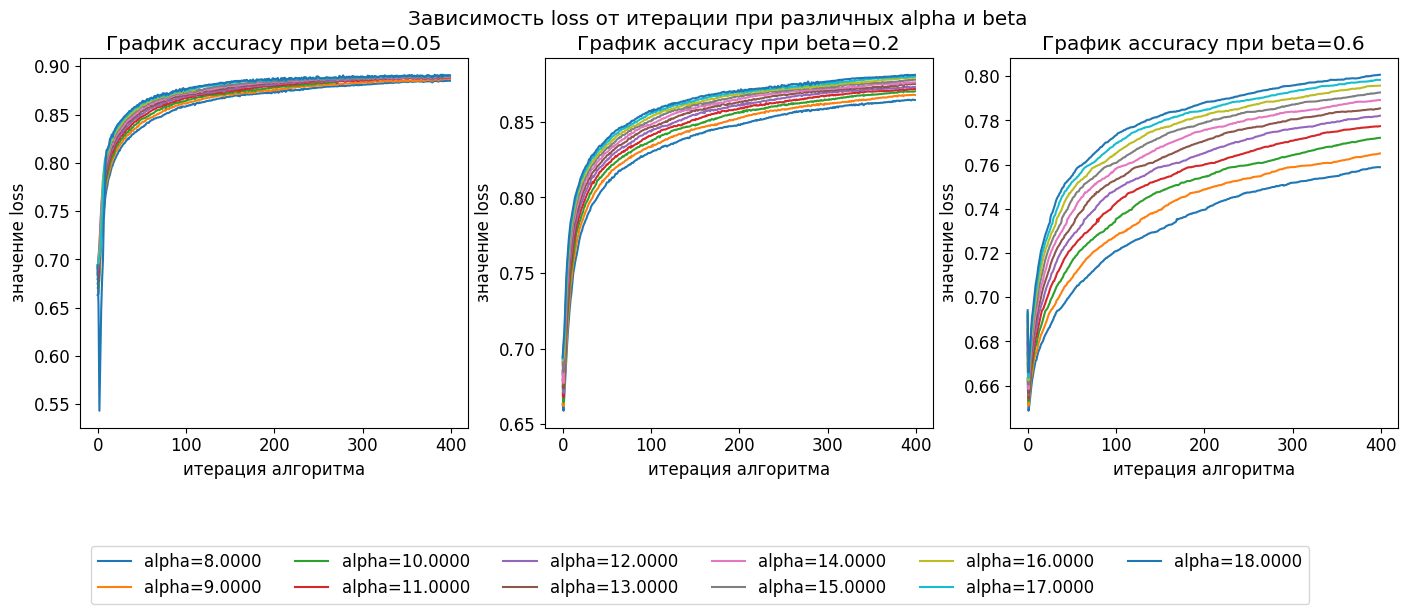

In [1557]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

fig, axis = plt.subplots(1, 3)
fig.set_figwidth(17)
fig.suptitle('Зависимость loss от итерации при различных alpha и beta')

cmap = plt.get_cmap('viridis')
# axis[0].set_prop_cycle(color=[cmap(1 - 1.*(i + 2)/32) for i in range(32)])
axis[0].set_title('График accuracy при beta=0.05')
# axis[1].set_prop_cycle(color=[cmap(1 - 1.*(i + 2)/32) for i in range(32)])
axis[1].set_title('График accuracy при beta=0.2')
# axis[2].set_prop_cycle(color=[cmap(1 - 1.*(i + 2)/32) for i in range(32)])
axis[2].set_title('График accuracy при beta=0.6')
for hist in finally_best_models:
    if hist['beta'] == 0.05:
        axis[0].plot(np.arange(len(hist['accuracy'])), hist['accuracy'], label=f'alpha={hist["alpha"]:.4f}')
    elif hist['beta'] == 0.2:
        axis[1].plot(np.arange(len(hist['accuracy'])), hist['accuracy'], label=f'alpha={hist["alpha"]:.4f}')
    elif hist['beta'] == 0.6:
        axis[2].plot(np.arange(len(hist['accuracy'])), hist['accuracy'], label=f'alpha={hist["alpha"]:.4f}')

for ax in axis:
    ax.set_xlabel('итерация алгоритма')
    ax.set_ylabel('значение loss')

plt.legend(loc='lower center', ncol=6, bbox_to_anchor=(-0.8, -0.5))
# plt.savefig('./figures/d.eps', format='eps', bbox_inches='tight')

 0.01 │ 0.888 │ 0.888 │ 0.883 │ 0.89 │ 0.89 │ 0.891 │ 0.891 │ 0.89 │ 0.889 │ 0.89 │ 0.891 │

In [1567]:
sorted_by_alpha = sorted(finally_best_models, key=lambda x: x['alpha'])

table_accuracy = [
    [0.01, 0.888, 0.888, 0.88, 0.89, 0.89, 0.891, 0.891, 0.89, 0.889, 0.89, 0.891],
    *[
        [beta, *[f'{(t["accuracy"][-1]):0.3f}' for t in filter(lambda x: x['beta'] == beta, sorted_by_alpha)]] for beta in [0.05, 0.2, 0.6]
    ]
]

print('Итоговое качество по accuracy для моделей')
print(tabulate.tabulate(table_accuracy, headers=['upper\\lower', *[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]], tablefmt="latex"))

Итоговое качество по accuracy для моделей
\begin{tabular}{rrrrrrrrrrrr}
\hline
   upper\textbackslash{}lower &     8 &     9 &    10 &    11 &    12 &    13 &    14 &    15 &    16 &    17 &    18 \\
\hline
          0.01 & 0.888 & 0.888 & 0.88  & 0.89  & 0.89  & 0.891 & 0.891 & 0.89  & 0.889 & 0.89  & 0.891 \\
          0.05 & 0.885 & 0.887 & 0.882 & 0.888 & 0.888 & 0.889 & 0.889 & 0.89  & 0.875 & 0.891 & 0.891 \\
          0.2  & 0.864 & 0.868 & 0.87  & 0.872 & 0.873 & 0.875 & 0.876 & 0.878 & 0.879 & 0.88  & 0.881 \\
          0.6  & 0.759 & 0.765 & 0.772 & 0.777 & 0.782 & 0.786 & 0.789 & 0.793 & 0.796 & 0.798 & 0.801 \\
\hline
\end{tabular}


In [15]:
top_model = SGDClassifier(learning_rate=inv_scale_lr(18, 0.05), l2_coef=0, tolerance=1e-6, max_iter=400)
hist = top_model.fit(X_train_lemmatize, y_train_lemmatize, trace=True, X_test=X_test_lemmatize, y_test=y_test_lemmatize)
print(f'accuracy: {(hist["accuracy"][-1]):0.3f}')


accuracy: 0.891


In [19]:
from sklearn.metrics import roc_curve, precision_recall_curve, PrecisionRecallDisplay, RocCurveDisplay

# finally_best_models.append({'alpha': alpha, 'beta': beta, **model.fit(X_train_lemmatize, y_train_lemmatize, trace=True, X_test=X_test_lemmatize, y_test=y_test_lemmatize)})


roc_res = roc_curve(y_test_lemmatize, np.asarray(preds)[:, 1])
pr_res = precision_recall_curve(y_test_lemmatize, np.asarray(preds)[:, 1])

plt.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ROC-AUC лучшего классификатора: 0.9545297703565871
PR-AUC лучшего классификатора:  0.9056186201230575




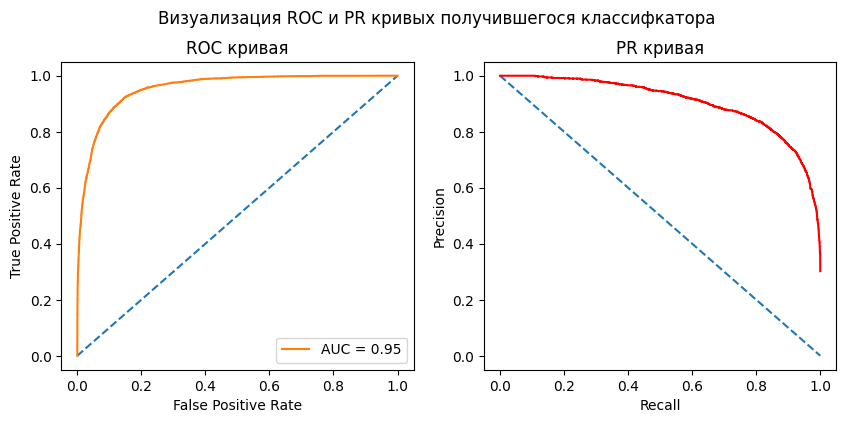

In [135]:
from sklearn.metrics import auc, precision_recall_curve, average_precision_score, roc_curve
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

# подсичтаем нужные данные для построения кривых
preds = top_model.predict_proba(X_test_lemmatize)
auc_curve = roc_curve(y_test_lemmatize, np.asarray(preds)[:, 1])
pr_curve = precision_recall_curve(y_test_lemmatize, np.asarray(preds)[:, 1])

# выведем площади под граффиками
print(f'ROC-AUC лучшего классификатора: {auc(auc_curve[0], auc_curve[1])}')
print(
    f'PR-AUC лучшего классификатора:  {average_precision_score(y_test_lemmatize, np.asarray(preds)[:, 1])}', end='\n\n\n')

# построим граффики для соответсвтующих кривых
fig, axis = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.set_figheight(4)
title = fig.suptitle('Визуализация ROC и PR кривых получившегося классифкатора')
title.set_position((0.5, 1.01))

lnsp = np.linspace(0, 1, 20)

axis[0].plot(lnsp, lnsp, linestyle='--')
axis[1].plot(lnsp, 1 - lnsp, linestyle='--')

axis[0].set_title('ROC кривая')
axis[1].set_title('PR кривая')

RocCurveDisplay(fpr=auc_curve[0], tpr=auc_curve[1], roc_auc=auc(
    auc_curve[0], auc_curve[1])).plot(ax=axis[0])
PrecisionRecallDisplay(
    precision=pr_curve[0], recall=pr_curve[1]).plot(ax=axis[1], c='r')

plt.savefig('./figures/roc_pr_curves.eps', format='eps', bbox_inches='tight')

In [36]:
!pipenv install seaborn

Courtesy Notice: Pipenv found itself running within a virtual environment, so it will automatically use that environment, instead of creating its own for any project. You can set PIPENV_IGNORE_VIRTUALENVS=1 to force pipenv to ignore that environment and create its own instead. You can set PIPENV_VERBOSITY=-1 to suppress this warning.
Installing seaborn...
Resolving seaborn...
Added seaborn to Pipfile's [packages] ...
✔ Installation Succeededn...
⠋ Installing seaborn...
Pipfile.lock (ee3c8b) out of date, updating to (a32f7f)...
Locking [packages] dependencies...
Building requirements...
Resolving dependencies...
✔ Success! Locking...
⠧ Locking...
Locking [dev-packages] dependencies...
Building requirements...
Resolving dependencies...
✔ Success! Locking...
⠏ Locking...
Updated Pipfile.lock (d4d5718c8656046cc922069e3ce47a9cb70a081994ee73bd0c6e7901b7a32f7f)!
Installing dependencies from Pipfile.lock (a32f7f)...
To activate this project's virtualenv, run pipenv shell.
Alternatively, run a 

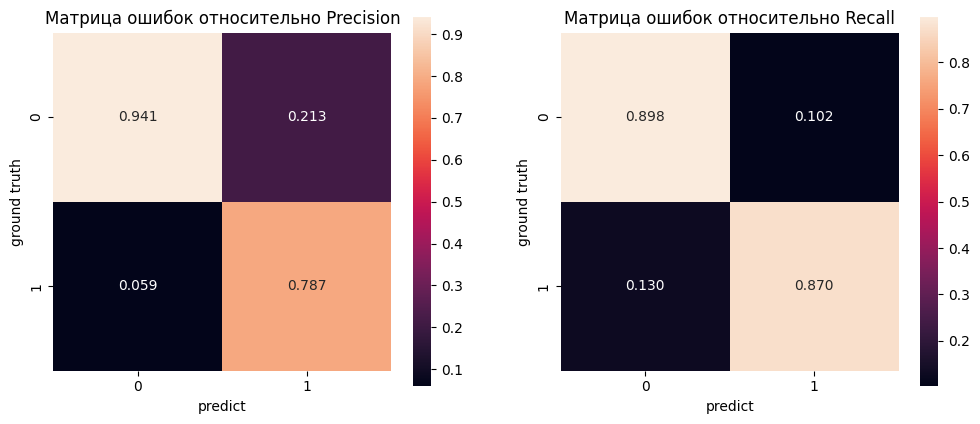

In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

preds = np.asarray(top_model.predict(X_test_lemmatize))


fig, axis = plt.subplots(1, 2)
fig.set_figwidth(12)

matr = confusion_matrix(y_true=y_test_lemmatize, y_pred=preds, normalize='pred')
sns.heatmap(data=matr, square=True, annot=True, fmt='.3f', ax=axis[0]
            ).set(title='Матрица ошибок относительно Precision', xlabel='predict', ylabel='ground truth')

matr = confusion_matrix(y_true=y_test_lemmatize, y_pred=preds,  normalize='true')
sns.heatmap(data=matr, square=True, annot=True, fmt='.3f', ax=axis[1]
            ).set(title='Матрица ошибок относительно Recall', xlabel='predict', ylabel='ground truth')

plt.savefig('./figures/conf_matr.eps', format='eps', bbox_inches='tight')

In [61]:
indexes_1_error = (np.asarray(top_model.predict(X_test_lemmatize)) == 1).flat & (y_test_lemmatize == -1)

In [71]:
data_test.comment_text.values[indexes_1_error][20:40]

array(['" \n :Welcome to hell. Check your self-respect at the door.   |   "',
       '" \n :I agree. 150,000,000 is ridiculous, that would be half of all ""Arabs""   "',
       "Well honestly I cant be fucking bothered tonight. So sleep wee all u editors ans admits . I'm off to bed. CU anaon",
       ':Looks like a Nazi salute.',
       'Why is it a racist saying Pot calling the kettle black',
       'they still shouldnt kill a women for a reason like that christains are soppose to be good people.',
       '::Btw, it is amazing how looks like a tax return form in the US, they assume that everybody is retarded.',
       '" \n\n I really think you are worrying unnecessarily about it. I just happened to come across the article and found a huge close up of her face which was overpixated. Think what you like and do what you like if you disagree.       "',
       ":Cocks. I'm confused now. It is fully protected until 5th December at the moment. Registered users are 'crystal ball' editing it,

In [74]:
weights = top_model.get_weights()
indexes = np.argsort(weights)

In [75]:
weights[indexes][:10]

array([-6.3675539 , -4.12296974, -3.68951073, -3.45442213, -3.42887108,
       -3.27541574, -3.01280604, -2.99561133, -2.96482501, -2.91393219])

In [81]:
tfid_vectorizer.get_feature_names_out()[indexes][-50::-1]

array(['idiotic', 'pig', 'jackass', ..., 'prepared', 'thanks', 'thank'],
      dtype=object)

In [86]:
pd.DataFrame(data={'words': tfid_vectorizer.get_feature_names_out()[indexes][::-1], 'weigths': weights[indexes][::-1]}).to_csv('./data_toxic/words_weigths.csv', index=False, sep=';')